In [1]:
!nvidia-smi 

Thu Jan 23 04:46:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:3B:00.0 Off |                  N/A |
| 77%   73C    P2   196W / 250W |   4508MiB / 11019MiB |     76%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:5E:00.0 Off |                  N/A |
| 31%   43C    P8    16W / 250W |     11MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
!ls

01_CNN.ipynb
SC_CNN_v0.ipynb
SC_CNN_v0.py
SC_CNN_v0_deepSC_Ln_jan20.ipynb
SC_CNN_v0_deepSC_Ln_jan21_nl1_test.ipynb
SC_CNN_v0_deepSC__newbn_jan22.ipynb
SC_CNN_v0_deepSC__nobn_jan23.ipynb
SC_CNN_v0_deepSC_dilation_jan22.ipynb
SC_CNN_v0_deepSC_dilation_newbn_jan22.ipynb
SC_CNN_v0_deepSC_eqln_jan23.ipynb
SC_CNN_v0_deepSC_eqln_newbn_jan22.ipynb
SC_CNN_v0_deepSC_jan22-b64s.ipynb
Untitled.ipynb
__pycache__
batch_testresult
class_acc_no_size.csv
class_acc_sized.csv
data
data.tar.gz
deepsc_nln_jan21.pt
deepscln_jan20.pt
elastic_test.ipynb
ln_jan20_testresult.csv
ln_jan20_testresult_9only.csv
ln_jan20_testresult_nl1.csv
ln_jan20_testresult_nl1_15-Copy1.csv
ln_jan20_testresult_nl1_15-Copy2.csv
ln_jan20_testresult_nl1_15.csv
ln_jan20_testresult_nl1_30.csv
mnist_4x
mnist_4x.tar.gz
mnist_png.tar
mnist_sized
mnist_sized.tar.gz
mnist_sized_trans.ipynb
nohup.out
parallel.py
sized_val
sized_val.tar.gz
test.csv
testresult_dil_jan22.csv
testresult_dil_nbn_jan22.csv
testresult_nbn128_jan22.csv
testresult_n

In [3]:
DATA_PATH = ''

In [4]:
import os

In [5]:
#!tar -zxvf 'mnist_4x.tar.gz'

In [6]:
INTERNAL_DATA_PATH = 'mnist_4x/'
INTERNAL_DATA_PATH_MAIN = 'mnist_4x/resized'
INTERNAL_DATA_PATH_OTHER = 'mnist_4x/centered'

In [7]:
import os
import fnmatch
 
# Get a list of all files in directory
for rootDir, subdirs, filenames in os.walk(INTERNAL_DATA_PATH):
    # Find the files that matches the given patterm
    for filename in fnmatch.filter(filenames, '.*'):
        try:
            #print(filename)
            os.remove(os.path.join(rootDir, filename))
        except OSError:
            print("Error while deleting file")

In [8]:
from time import sleep
from tqdm import tqdm
for _ in tqdm(range(10)):
    sleep(0.001)

100%|██████████| 10/10 [00:00<00:00, 919.76it/s]


In [9]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
import torch
from torch.utils.data import Dataset, DataLoader
import os
import matplotlib.pyplot as plt
import numpy as np

########################################################################
batch_size = 64
########################################################################


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
class SizedMnistDataset(Dataset):
    def __init__(self,dir_list,transform=None):
        self.dir_list = dir_list
        self.transform = transform
        
        self.dataset_list = []
        for i in range(len(dir_list)):
            temp_dataset = datasets.ImageFolder(root=self.dir_list[i],transform = self.transform)
            self.dataset_list.append(temp_dataset)
        
    def __len__(self):
        return len(self.dataset_list[0])
    
    def __getitem__(self,idx):
        return self.dataset_list[0][idx],self.dataset_list[1][idx],self.dataset_list[2][idx],self.dataset_list[3][idx],self.dataset_list[4][idx]
    

In [12]:
new_path = ['data/ds2','data/ds3','data/ds4','data/ds5','data/ds6']

train_dataset_path = [x+"/training" for x in new_path]
test_dataset_path = [x+"/testing" for x in new_path]
test_dataset_path

['data/ds2/testing',
 'data/ds3/testing',
 'data/ds4/testing',
 'data/ds5/testing',
 'data/ds6/testing']

In [13]:
#img_size = [729,243,81,27,9]  

transform = transforms.Compose(
    [
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainMnistDataset = SizedMnistDataset(train_dataset_path,transform)
testMnistDataset = SizedMnistDataset(test_dataset_path,transform)

trainloader = torch.utils.data.DataLoader(trainMnistDataset,
                                          batch_size = batch_size, 
                                          shuffle=True,
                                         num_workers=8)

testloader = torch.utils.data.DataLoader(testMnistDataset,
                                          batch_size = batch_size, 
                                          shuffle=False,
                                        num_workers=8)


In [14]:
import torch.nn as nn
import torch.nn.functional as F

class SCModule1(nn.Module):
    def __init__(self,in_channels,out_channels,output_number):
        super(SCModule1, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.output_number = output_number

        self.conv1 = nn.Conv2d(in_channels, out_channels, 9, stride=9, padding=4)
        self.conv2 = nn.Conv2d(in_channels, out_channels, 3, stride=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels, out_channels, 1)
        
        self.bn1_1 = nn.BatchNorm2d(out_channels)
        self.bn1_2 = nn.BatchNorm2d(out_channels)
        self.bn1_3 = nn.BatchNorm2d(out_channels)
        self.bn1_4 = nn.BatchNorm2d(out_channels)
        self.bn1_5 = nn.BatchNorm2d(out_channels)
        self.bn1_6 = nn.BatchNorm2d(out_channels)
        self.bn1_7 = nn.BatchNorm2d(out_channels)
        
        self.bn2_1 = nn.BatchNorm2d(out_channels)
        self.bn2_2 = nn.BatchNorm2d(out_channels)
        self.bn2_3 = nn.BatchNorm2d(out_channels)
        self.bn2_4 = nn.BatchNorm2d(out_channels)
        self.bn2_5 = nn.BatchNorm2d(out_channels)
        self.bn2_6 = nn.BatchNorm2d(out_channels)
        self.bn2_7 = nn.BatchNorm2d(out_channels)
        
        self.bn3_1 = nn.BatchNorm2d(out_channels)
        self.bn3_2 = nn.BatchNorm2d(out_channels)
        self.bn3_3 = nn.BatchNorm2d(out_channels)
        self.bn3_4 = nn.BatchNorm2d(out_channels)
        self.bn3_5 = nn.BatchNorm2d(out_channels)
        self.bn3_6 = nn.BatchNorm2d(out_channels)
        self.bn3_7 = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        x_1_1 = self.conv1(x[0])
        x_1_2 = self.conv1(x[1])
        x_1_3 = self.conv1(x[2])

        x_2_1 = self.conv2(x[1])
        x_2_2 = self.conv2(x[2])
        x_2_3 = self.conv2(x[3])

        x_3_1 = self.conv3(x[2])
        x_3_2 = self.conv3(x[3])
        x_3_3 = self.conv3(x[4])
        
        ## 81
            
        #L3 (9,3,1)
        o_1_1 = torch.stack([x_1_1,x_2_1,x_3_1]) 
        o_1_1 = self.bn1_1(torch.sum(o_1_1,0))

        #L2 (9,3)
        o_1_2 = torch.stack([F.conv2d(x[1], self.conv1.weight, bias=self.conv1.bias, stride=3, padding=4, dilation=1, groups=1),
                             F.conv2d(x[2], self.conv2.weight, bias=self.conv2.bias, stride=1, padding=1, dilation=1, groups=1)])
        o_1_2 = self.bn1_2(torch.sum(o_1_2,0))

        #L2 (3,1)
        o_1_3 = torch.stack([x_2_1,x_3_1])
        o_1_3 = self.bn1_3(torch.sum(o_1_3,0))

        #L2 (9,1)
        o_1_4 = torch.stack([F.conv2d(x[1], self.conv1.weight, bias=self.conv1.bias, stride=3, padding=4, dilation=1, groups=1),
                             x_3_1])
        o_1_4 = self.bn1_4(torch.sum(o_1_4,0))

        #L1 (9)
        o_1_5 = self.bn1_5(F.conv2d(x[2], self.conv1.weight, bias=self.conv1.bias, stride=1, padding=4, dilation=1, groups=1))

        #L1 (3)
        o_1_6 = self.bn1_6(F.conv2d(x[2], self.conv2.weight, bias=self.conv2.bias, stride=1, padding=1, dilation=1, groups=1))

        #L1 (1)
        o_1_7 = self.bn1_7(x_3_1)

        ## 27

        #L3 (9,3,1)
        o_2_1 = torch.stack([x_1_2,x_2_2,x_3_2]) 
        o_2_1 = self.bn2_1(torch.sum(o_2_1,0))

        #L2 (9,3)
        o_2_2 = torch.stack([F.conv2d(x[2], self.conv1.weight, bias=self.conv1.bias, stride=3, padding=4, dilation=1, groups=1),
                             F.conv2d(x[3], self.conv2.weight, bias=self.conv2.bias, stride=1, padding=1, dilation=1, groups=1)])
        o_2_2 = self.bn2_2(torch.sum(o_2_2,0))

        #L2 (3,1)
        o_2_3 = torch.stack([x_2_2,x_3_2])
        o_2_3 = self.bn2_3(torch.sum(o_2_3,0))

        #L2 (9,1)
        o_2_4 = torch.stack([F.conv2d(x[2], self.conv1.weight, bias=self.conv1.bias, stride=3, padding=4, dilation=1, groups=1),
                             x_3_2])
        o_2_4 = self.bn2_4(torch.sum(o_2_4,0))

        #L1 (9)
        o_2_5 = self.bn2_5(F.conv2d(x[3], self.conv1.weight, bias=self.conv1.bias, stride=1, padding=4, dilation=1, groups=1))

        #L1 (3)
        o_2_6 = self.bn2_6(F.conv2d(x[3], self.conv2.weight, bias=self.conv2.bias, stride=1, padding=1, dilation=1, groups=1))

        #L1 (1)
        o_2_7 = self.bn2_7(x_3_2)

        ## 9

        #L3 (9,3,1)
        o_3_1 = torch.stack([x_1_3,x_2_3,x_3_3]) 
        o_3_1 = self.bn3_1(torch.sum(o_3_1,0)) 

        #L2 (9,3)
        o_3_2 = torch.stack([F.conv2d(x[3], self.conv1.weight, bias=self.conv1.bias, stride=3, padding=4, dilation=1, groups=1),
                             F.conv2d(x[4], self.conv2.weight, bias=self.conv2.bias, stride=1, padding=1, dilation=1, groups=1)])
        o_3_2 = self.bn3_2(torch.sum(o_3_2,0))

        #L2 (3,1)
        o_3_3 = torch.stack([x_2_3,x_3_3])
        o_3_3 = self.bn3_3(torch.sum(o_3_3,0))

        #L2 (9,1)
        o_3_4 = torch.stack([F.conv2d(x[3], self.conv1.weight, bias=self.conv1.bias, stride=3, padding=4, dilation=1, groups=1),
                             x_3_3])
        o_3_4 = self.bn3_4(torch.sum(o_3_4,0))

        #L1 (9)
        o_3_5 = self.bn3_5(F.conv2d(x[4], self.conv1.weight, bias=self.conv1.bias, stride=1, padding=4, dilation=1, groups=1))

        #L1 (3)
        o_3_6 = self.bn3_6(F.conv2d(x[4], self.conv2.weight, bias=self.conv2.bias, stride=1, padding=1, dilation=1, groups=1))

        #L1 (1)
        o_3_7 = self.bn3_7(x_3_3)

        return [torch.cat([o_1_1,o_1_2,o_1_3,o_1_4,o_1_5,o_1_6,o_1_7],dim=1),
                torch.cat([o_2_1,o_2_2,o_2_3,o_2_4,o_2_5,o_2_6,o_2_7],dim=1),
                torch.cat([o_3_1,o_3_2,o_3_3,o_3_4,o_3_5,o_3_6,o_3_7],dim=1)]
        
            
        '''outputs = []
        for i in range(self.output_number):
            x_1_1 = self.conv1(x[0+i]) 
            x_1_2 = self.conv2(x[1+i]) 
            x_1_3 = self.conv3(x[2+i]) 
            #return [x_1_1,x_1_2,x_1_3]
            x_1 = torch.stack([x_1_1,x_1_2,x_1_3])
            x_1 = torch.sum(x_1,0)
            #print(x_1.size())
            #x_1 = torch.cat([x_1_1,x_1_2],dim=1)
            outputs.append(x_1)
        return outputs'''
    

    
#model = SCModule(3,6,3)

In [15]:
import torch.nn as nn
import torch.nn.functional as F

class SCModule2(nn.Module):
    def __init__(self,in_channels,out_channels,output_number):
        super(SCModule2, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.output_number = output_number

        self.conv1 = nn.Conv2d(in_channels, out_channels, 9, stride=9, padding=4)
        self.conv2 = nn.Conv2d(in_channels, out_channels, 3, stride=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels, out_channels, 1)
        
        self.bn4 = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        x_1_1 = self.conv1(x[0]) 
        x_1_2 = self.conv2(x[1]) 
        x_1_3 = self.conv3(x[2]) 
        #return [x_1_1,x_1_2,x_1_3]
        x_1 = torch.stack([x_1_1,x_1_2,x_1_3])
        x_1 = torch.sum(x_1,0)
        #print(x_1.size())
        #x_1 = torch.cat([x_1_1,x_1_2],dim=1)
        return self.bn4(x_1)
        
            
        '''outputs = []
        for i in range(self.output_number):
            x_1_1 = self.conv1(x[0+i]) 
            x_1_2 = self.conv2(x[1+i]) 
            x_1_3 = self.conv3(x[2+i]) 
            #return [x_1_1,x_1_2,x_1_3]
            x_1 = torch.stack([x_1_1,x_1_2,x_1_3])
            x_1 = torch.sum(x_1,0)
            #print(x_1.size())
            #x_1 = torch.cat([x_1_1,x_1_2],dim=1)
            outputs.append(x_1)
        return outputs'''
    

    
#model = SCModule(3,6,3)

In [16]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self,batch_size):
        super(Net, self).__init__()
        self.sc1 = SCModule1(3,3,3) 
        self.sc2 = SCModule1(21,5,3)
        self.sc3 = SCModule1(35,7,3)
        self.sc4 = SCModule1(49,9,3)
        self.sc5 = SCModule2(63,90,1)
        
        self.fc2 = nn.Linear(90*3*3,120)
        self.fc3 = nn.Linear(120,84)
        self.fc4 = nn.Linear(84,10)
        
        tensor = torch.tensor((), dtype=torch.float)
 
        self.pad1 = tensor.new_zeros((batch_size,63,243,243))#.to('cuda')
        self.pad2 = tensor.new_zeros((batch_size,63,81,81))#.to('cuda')


    def forward(self, i1,i2,i3,i4,i5):
        self.pad1 = self.pad1.to(i1.device)
        self.pad2 = self.pad2.to(i1.device)
        x1_1,x1_2,x1_3 = self.sc1([i1,i2,i3,i4,i5])
        #x1_2,x1_3 = self.sc1([i2,i3,i4,i5])
        x1_1 = F.relu(x1_1)
        x1_2 = F.relu(x1_2)
        x1_3 = F.relu(x1_3)
        
        #print(x1_1)
        #print(self.pad1)
        bat_size = x1_1.size()[0]
        chan_size = x1_1.size()[1]
        x2_1,x2_2,x2_3 = self.sc2([self.pad1[:bat_size,:chan_size,:,:],self.pad2[:bat_size,:chan_size,:,:],x1_1,x1_2,x1_3])
        #x1_2,x1_3 = self.sc1([i2,i3,i4,i5])
        x2_1 = F.relu(x2_1)
        x2_2 = F.relu(x2_2)
        x2_3 = F.relu(x2_3)
        
        bat_size = x2_1.size()[0]
        chan_size = x2_1.size()[1]
        x3_1,x3_2,x3_3 = self.sc3([self.pad1[:bat_size,:chan_size,:,:],self.pad2[:bat_size,:chan_size,:,:],x2_1,x2_2,x2_3])
        #x1_2,x1_3 = self.sc1([i2,i3,i4,i5])
        x3_1 = F.relu(x3_1)
        x3_2 = F.relu(x3_2)
        x3_3 = F.relu(x3_3)
        
        bat_size = x3_1.size()[0]
        chan_size = x3_1.size()[1]
        x4_1,x4_2,x4_3 = self.sc4([self.pad1[:bat_size,:chan_size,:,:],self.pad2[:bat_size,:chan_size,:,:],x3_1,x3_2,x3_3])
        #x1_2,x1_3 = self.sc1([i2,i3,i4,i5])
        x4_1 = F.relu(x4_1)
        x4_2 = F.relu(x4_2)
        x4_3 = F.relu(x4_3)
    
        #print(x1_1.size())
        
        #x1_1 = x1_1.view(-1,6*81*81)
        #x1_2 = x1_2.view(-1,6*27*27)
        #x1_3 = x1_3.view(-1,6*9*9)
        
        #x1_1 = F.relu(self.fc1_1(x1_1))
        #x1_2 = F.relu(self.fc1_2(x1_2))
        #x1_3 = F.relu(self.fc1_3(x1_3))
        
        #x2 = torch.cat([x1_1,x1_2,x1_3],dim=1)
        
        x2 = self.sc5([x4_1,x4_2,x4_3])
        x2 = F.relu(x2)
        
        #print(x2.size())
        
        #print(x2_1.size())
        
        #print(x3.size())
        
        x2 = x2.view(-1, 90 * 3 * 3)
        x2 = F.relu(self.fc2(x2))
        x2 = F.relu(self.fc3(x2))
        x2 = self.fc4(x2)
        #print(x4.shape)
        return x2

In [17]:
from parallel import DataParallelModel,DataParallelCriterion
from torch.nn.parallel.data_parallel import DataParallel
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_ids = [0,1]
os.environ['MASTER_ADDR'] = '127.0.0.1'
os.environ['MASTER_PORT'] = '29501'
dist.init_process_group(backend='nccl',rank=0,world_size=1)

In [18]:
model = Net(batch_size).to('cuda:1')
if torch.cuda.device_count() > 10:
    model = DDP(model,device_ids = [2,3])
#model.to(device)

In [19]:
print(device)

cuda


In [20]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
#criterion = DataParallelCriterion(criterion,device_ids=[0,1])
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [21]:
SIZED_VAL_PATH = 'sized_val'
new_path = []
for i in os.listdir('mnist_sized'):
    #print(i)
    temp = []
    for j in range(1,6):
        temp.append(os.path.join(SIZED_VAL_PATH,str(i),'ds'+str(j)))
    new_path.append(temp)

new_path.sort(key=lambda x:int(x[0].split('/')[1]))

val_gen_arr = []
for i in tqdm(range(0,len(new_path))):
    transform = transforms.Compose(
        [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    testMnistDataset = SizedMnistDataset(new_path[i],transform)

    testloader = torch.utils.data.DataLoader(testMnistDataset,
                                              batch_size = batch_size, 
                                              shuffle=False,
                                            num_workers=8)
    val_gen_arr.append(testloader)
#
#val_gen_arr
accuracy = []


100%|██████████| 112/112 [00:01<00:00, 70.20it/s]


In [22]:
import torch.optim as optim
from tqdm import tqdm
import sys

trn_loss_list = []
val_loss_list = []
acc_list = []
num_batches = len(trainloader)
for epoch in range(30):
    running_loss = 0.0
    model.train()
    device = 'cuda:1'
    for i,images in tqdm(enumerate(trainloader)):
        #data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        c1 = images[0][0].to(device)
        c2 = images[1][0].to(device)
        c3 = images[2][0].to(device)
        c4 = images[3][0].to(device)
        c5 = images[4][0].to(device)
        c6 = images[0][1].to(device)
        #c61 = c6[:128].to('cuda:0')
        #c62 = c6[128:].to('cuda:1')
        output = model(c1,c2,c3,c4,c5)
        #output = torch.nn.parallel.gather(output,'cuda:1')
        loss = criterion(output, c6)
        loss.backward()    # calc gradients
        optimizer.step()   # update gradients
        running_loss += loss.item()
        #print(i)
    
    model.eval()
    with torch.no_grad(): # very very very very important!!!
        val_loss = 0.0
        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))
        correct = 0
        total = 0
        for j,val in enumerate(testloader):
            v1 = val[0][0].to(device)
            v2 = val[1][0].to(device)
            v3 = val[2][0].to(device)
            v4 = val[3][0].to(device)
            v5 = val[4][0].to(device)
            val_labels = val[0][1].to(device)
            val_output = model(v1,v2,v3,v4,v5)
            v_loss = criterion(val_output, val_labels)
            val_loss += v_loss
            _, predicted = torch.max(val_output, 1)
            c = (predicted == val_labels).squeeze()
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item()
            for i in range(len(val_labels)):
                val_label = val_labels[i]
                class_correct[val_label] += c[i].item()
                class_total[val_label] += 1

        for i in range(10):
            if class_total[i]==0:
                print('class_total = 0',class_correct,class_total)
            else:
                print('Accuracy of %5s : %2d %%' % (i, 100 * class_correct[i] / class_total[i]))

    print("epoch: {}/{} | step: {}/{} | trn loss: {:.4f} | val loss: {:.4f}".format(
        epoch+1, 30, i+1, num_batches, running_loss / len(trainloader), val_loss / len(testloader)
    ))        
    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

    trn_loss_list.append(running_loss/1875)
    val_loss_list.append(val_loss/len(testloader))
    running_loss = 0.0
    
    temp_acc = []
    for testloader in tqdm(val_gen_arr):
        correct = 0
        total = 0
        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))
        with torch.no_grad():
            for images in testloader:
                c1 = images[0][0].to(device)
                c2 = images[1][0].to(device)
                c3 = images[2][0].to(device)
                c4 = images[3][0].to(device)
                c5 = images[4][0].to(device)
                val_labels = images[0][1].to(device)
                outputs = model(c1,c2,c3,c4,c5)
                _, predicted = torch.max(outputs.data, 1)
                c = (predicted == val_labels).squeeze()
                total += val_labels.size(0)
                correct += (predicted == val_labels).sum().item()
        #print(total,correct,end='')

        print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
        temp_acc.append(100 * correct / total)
    acc_list.append(temp_acc)
        
    #optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    

938it [01:49,  8.56it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 97 %
Accuracy of     1 : 100 %
Accuracy of     2 : 98 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 99 %
Accuracy of     7 : 99 %
Accuracy of     8 : 95 %
Accuracy of     9 : 100 %
epoch: 1/30 | step: 10/938 | trn loss: 0.1213 | val loss: 0.0404
Accuracy of the network on the 10000 test images: 98 %


  1%|          | 1/112 [00:01<02:53,  1.57s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:03<02:53,  1.58s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:04<02:52,  1.58s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:06<02:51,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:07<02:50,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:09<02:49,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:11<02:48,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:12<02:47,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:14<02:45,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:16<02:44,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:17<02:42,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:19<02:41,  1.62s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:20<02:42,  1.64s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:22<02:39,  1.63s/it]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:24<02:36,  1.62s/it]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:25<02:35,  1.62s/it]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:27<02:33,  1.62s/it]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:28<02:31,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:30<02:29,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:32<02:28,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:33<02:26,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:35<02:24,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:37<02:22,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:38<02:20,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:40<02:18,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


 23%|██▎       | 26/112 [00:41<02:16,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:43<02:15,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:44<02:13,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


 26%|██▌       | 29/112 [00:46<02:12,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


 27%|██▋       | 30/112 [00:48<02:10,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


 28%|██▊       | 31/112 [00:49<02:09,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▊       | 32/112 [00:51<02:08,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▉       | 33/112 [00:52<02:07,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


 30%|███       | 34/112 [00:54<02:06,  1.62s/it]

Accuracy of the network on the 10000 test images: 11 %


 31%|███▏      | 35/112 [00:56<02:05,  1.63s/it]

Accuracy of the network on the 10000 test images: 11 %


 32%|███▏      | 36/112 [00:57<02:03,  1.62s/it]

Accuracy of the network on the 10000 test images: 12 %


 33%|███▎      | 37/112 [00:59<02:00,  1.61s/it]

Accuracy of the network on the 10000 test images: 12 %


 34%|███▍      | 38/112 [01:01<01:59,  1.61s/it]

Accuracy of the network on the 10000 test images: 13 %


 35%|███▍      | 39/112 [01:02<01:57,  1.61s/it]

Accuracy of the network on the 10000 test images: 14 %


 36%|███▌      | 40/112 [01:04<01:56,  1.62s/it]

Accuracy of the network on the 10000 test images: 15 %


 37%|███▋      | 41/112 [01:05<01:54,  1.62s/it]

Accuracy of the network on the 10000 test images: 16 %


 38%|███▊      | 42/112 [01:07<01:53,  1.62s/it]

Accuracy of the network on the 10000 test images: 17 %


 38%|███▊      | 43/112 [01:09<01:50,  1.61s/it]

Accuracy of the network on the 10000 test images: 18 %


 39%|███▉      | 44/112 [01:10<01:48,  1.60s/it]

Accuracy of the network on the 10000 test images: 21 %


 40%|████      | 45/112 [01:12<01:47,  1.60s/it]

Accuracy of the network on the 10000 test images: 21 %


 41%|████      | 46/112 [01:13<01:46,  1.62s/it]

Accuracy of the network on the 10000 test images: 23 %


 42%|████▏     | 47/112 [01:15<01:44,  1.61s/it]

Accuracy of the network on the 10000 test images: 24 %


 43%|████▎     | 48/112 [01:17<01:43,  1.62s/it]

Accuracy of the network on the 10000 test images: 26 %


 44%|████▍     | 49/112 [01:18<01:41,  1.61s/it]

Accuracy of the network on the 10000 test images: 28 %


 45%|████▍     | 50/112 [01:20<01:39,  1.60s/it]

Accuracy of the network on the 10000 test images: 30 %


 46%|████▌     | 51/112 [01:22<01:38,  1.61s/it]

Accuracy of the network on the 10000 test images: 32 %


 46%|████▋     | 52/112 [01:23<01:36,  1.60s/it]

Accuracy of the network on the 10000 test images: 34 %


 47%|████▋     | 53/112 [01:25<01:34,  1.59s/it]

Accuracy of the network on the 10000 test images: 36 %


 48%|████▊     | 54/112 [01:26<01:31,  1.58s/it]

Accuracy of the network on the 10000 test images: 38 %


 49%|████▉     | 55/112 [01:28<01:30,  1.58s/it]

Accuracy of the network on the 10000 test images: 41 %


 50%|█████     | 56/112 [01:29<01:28,  1.57s/it]

Accuracy of the network on the 10000 test images: 43 %


 51%|█████     | 57/112 [01:31<01:26,  1.58s/it]

Accuracy of the network on the 10000 test images: 46 %


 52%|█████▏    | 58/112 [01:33<01:25,  1.59s/it]

Accuracy of the network on the 10000 test images: 49 %


 53%|█████▎    | 59/112 [01:34<01:24,  1.59s/it]

Accuracy of the network on the 10000 test images: 51 %


 54%|█████▎    | 60/112 [01:36<01:22,  1.58s/it]

Accuracy of the network on the 10000 test images: 54 %


 54%|█████▍    | 61/112 [01:37<01:20,  1.58s/it]

Accuracy of the network on the 10000 test images: 56 %


 55%|█████▌    | 62/112 [01:39<01:19,  1.59s/it]

Accuracy of the network on the 10000 test images: 58 %


 56%|█████▋    | 63/112 [01:41<01:17,  1.59s/it]

Accuracy of the network on the 10000 test images: 61 %


 57%|█████▋    | 64/112 [01:42<01:16,  1.58s/it]

Accuracy of the network on the 10000 test images: 64 %


 58%|█████▊    | 65/112 [01:44<01:14,  1.59s/it]

Accuracy of the network on the 10000 test images: 67 %


 59%|█████▉    | 66/112 [01:45<01:12,  1.58s/it]

Accuracy of the network on the 10000 test images: 70 %


 60%|█████▉    | 67/112 [01:47<01:11,  1.59s/it]

Accuracy of the network on the 10000 test images: 72 %


 61%|██████    | 68/112 [01:48<01:10,  1.59s/it]

Accuracy of the network on the 10000 test images: 75 %


 62%|██████▏   | 69/112 [01:50<01:07,  1.58s/it]

Accuracy of the network on the 10000 test images: 77 %


 62%|██████▎   | 70/112 [01:52<01:06,  1.58s/it]

Accuracy of the network on the 10000 test images: 79 %


 63%|██████▎   | 71/112 [01:53<01:05,  1.59s/it]

Accuracy of the network on the 10000 test images: 82 %


 64%|██████▍   | 72/112 [01:55<01:03,  1.59s/it]

Accuracy of the network on the 10000 test images: 83 %


 65%|██████▌   | 73/112 [01:56<01:01,  1.59s/it]

Accuracy of the network on the 10000 test images: 85 %


 66%|██████▌   | 74/112 [01:58<01:00,  1.59s/it]

Accuracy of the network on the 10000 test images: 85 %


 67%|██████▋   | 75/112 [02:00<00:58,  1.59s/it]

Accuracy of the network on the 10000 test images: 87 %


 68%|██████▊   | 76/112 [02:01<00:57,  1.60s/it]

Accuracy of the network on the 10000 test images: 88 %


 69%|██████▉   | 77/112 [02:03<00:55,  1.60s/it]

Accuracy of the network on the 10000 test images: 90 %


 70%|██████▉   | 78/112 [02:04<00:54,  1.59s/it]

Accuracy of the network on the 10000 test images: 91 %


 71%|███████   | 79/112 [02:06<00:52,  1.59s/it]

Accuracy of the network on the 10000 test images: 93 %


 71%|███████▏  | 80/112 [02:08<00:50,  1.59s/it]

Accuracy of the network on the 10000 test images: 93 %


 72%|███████▏  | 81/112 [02:09<00:49,  1.59s/it]

Accuracy of the network on the 10000 test images: 94 %


 73%|███████▎  | 82/112 [02:11<00:47,  1.60s/it]

Accuracy of the network on the 10000 test images: 95 %


 74%|███████▍  | 83/112 [02:12<00:46,  1.60s/it]

Accuracy of the network on the 10000 test images: 94 %


 75%|███████▌  | 84/112 [02:14<00:44,  1.59s/it]

Accuracy of the network on the 10000 test images: 95 %


 76%|███████▌  | 85/112 [02:16<00:42,  1.59s/it]

Accuracy of the network on the 10000 test images: 95 %


 77%|███████▋  | 86/112 [02:17<00:41,  1.59s/it]

Accuracy of the network on the 10000 test images: 96 %


 78%|███████▊  | 87/112 [02:19<00:39,  1.59s/it]

Accuracy of the network on the 10000 test images: 96 %


 79%|███████▊  | 88/112 [02:20<00:38,  1.59s/it]

Accuracy of the network on the 10000 test images: 96 %


 79%|███████▉  | 89/112 [02:22<00:36,  1.59s/it]

Accuracy of the network on the 10000 test images: 97 %


 80%|████████  | 90/112 [02:23<00:35,  1.59s/it]

Accuracy of the network on the 10000 test images: 97 %


 81%|████████▏ | 91/112 [02:25<00:33,  1.59s/it]

Accuracy of the network on the 10000 test images: 97 %


 82%|████████▏ | 92/112 [02:27<00:31,  1.58s/it]

Accuracy of the network on the 10000 test images: 97 %


 83%|████████▎ | 93/112 [02:28<00:29,  1.58s/it]

Accuracy of the network on the 10000 test images: 97 %


 84%|████████▍ | 94/112 [02:30<00:28,  1.58s/it]

Accuracy of the network on the 10000 test images: 97 %


 85%|████████▍ | 95/112 [02:31<00:26,  1.59s/it]

Accuracy of the network on the 10000 test images: 97 %


 86%|████████▌ | 96/112 [02:33<00:25,  1.59s/it]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [02:35<00:23,  1.60s/it]

Accuracy of the network on the 10000 test images: 97 %


 88%|████████▊ | 98/112 [02:36<00:22,  1.59s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [02:38<00:20,  1.59s/it]

Accuracy of the network on the 10000 test images: 97 %


 89%|████████▉ | 100/112 [02:39<00:19,  1.59s/it]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [02:41<00:17,  1.61s/it]

Accuracy of the network on the 10000 test images: 97 %


 91%|█████████ | 102/112 [02:43<00:16,  1.62s/it]

Accuracy of the network on the 10000 test images: 98 %


 92%|█████████▏| 103/112 [02:44<00:14,  1.63s/it]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [02:46<00:13,  1.63s/it]

Accuracy of the network on the 10000 test images: 98 %


 94%|█████████▍| 105/112 [02:48<00:11,  1.64s/it]

Accuracy of the network on the 10000 test images: 98 %


 95%|█████████▍| 106/112 [02:49<00:09,  1.63s/it]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▌| 107/112 [02:51<00:08,  1.63s/it]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▋| 108/112 [02:52<00:06,  1.62s/it]

Accuracy of the network on the 10000 test images: 98 %


 97%|█████████▋| 109/112 [02:54<00:04,  1.62s/it]

Accuracy of the network on the 10000 test images: 98 %


 98%|█████████▊| 110/112 [02:56<00:03,  1.62s/it]

Accuracy of the network on the 10000 test images: 98 %


 99%|█████████▉| 111/112 [02:57<00:01,  1.61s/it]

Accuracy of the network on the 10000 test images: 98 %


100%|██████████| 112/112 [02:59<00:00,  1.60s/it]

Accuracy of the network on the 10000 test images: 98 %



938it [01:50,  8.51it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 100 %
Accuracy of     3 : 100 %
Accuracy of     4 : 98 %
Accuracy of     5 : 99 %
Accuracy of     6 : 100 %
Accuracy of     7 : 99 %
Accuracy of     8 : 97 %
Accuracy of     9 : 98 %
epoch: 2/30 | step: 10/938 | trn loss: 0.0422 | val loss: 0.0390
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:01<02:59,  1.62s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:03<02:57,  1.62s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:04<02:55,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:06<02:54,  1.62s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:08<02:51,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:09<02:48,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:11<02:47,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:12<02:45,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:14<02:43,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:15<02:43,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:17<02:42,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:19<02:40,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:20<02:39,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:22<02:38,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:24<02:35,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:25<02:33,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:27<02:31,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:28<02:31,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:30<02:29,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:32<02:28,  1.62s/it]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:33<02:26,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:35<02:25,  1.62s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:36<02:23,  1.62s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:38<02:23,  1.63s/it]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:40<02:22,  1.64s/it]

Accuracy of the network on the 10000 test images: 10 %


 23%|██▎       | 26/112 [00:41<02:20,  1.63s/it]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:43<02:16,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:45<02:15,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


 26%|██▌       | 29/112 [00:46<02:12,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


 27%|██▋       | 30/112 [00:48<02:10,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


 28%|██▊       | 31/112 [00:49<02:09,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▊       | 32/112 [00:51<02:08,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▉       | 33/112 [00:53<02:06,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


 30%|███       | 34/112 [00:54<02:05,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


 31%|███▏      | 35/112 [00:56<02:04,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


 32%|███▏      | 36/112 [00:57<02:01,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


 33%|███▎      | 37/112 [00:59<01:59,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


 34%|███▍      | 38/112 [01:00<01:57,  1.58s/it]

Accuracy of the network on the 10000 test images: 10 %


 35%|███▍      | 39/112 [01:02<01:55,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


 36%|███▌      | 40/112 [01:04<01:54,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


 37%|███▋      | 41/112 [01:05<01:53,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


 38%|███▊      | 42/112 [01:07<01:51,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


 38%|███▊      | 43/112 [01:08<01:49,  1.59s/it]

Accuracy of the network on the 10000 test images: 11 %


 39%|███▉      | 44/112 [01:10<01:47,  1.59s/it]

Accuracy of the network on the 10000 test images: 11 %


 40%|████      | 45/112 [01:12<01:46,  1.58s/it]

Accuracy of the network on the 10000 test images: 12 %


 41%|████      | 46/112 [01:13<01:45,  1.60s/it]

Accuracy of the network on the 10000 test images: 13 %


 42%|████▏     | 47/112 [01:15<01:43,  1.58s/it]

Accuracy of the network on the 10000 test images: 14 %


 43%|████▎     | 48/112 [01:16<01:41,  1.58s/it]

Accuracy of the network on the 10000 test images: 16 %


 44%|████▍     | 49/112 [01:18<01:39,  1.58s/it]

Accuracy of the network on the 10000 test images: 17 %


 45%|████▍     | 50/112 [01:20<01:38,  1.58s/it]

Accuracy of the network on the 10000 test images: 20 %


 46%|████▌     | 51/112 [01:21<01:36,  1.59s/it]

Accuracy of the network on the 10000 test images: 23 %


 46%|████▋     | 52/112 [01:23<01:35,  1.59s/it]

Accuracy of the network on the 10000 test images: 26 %


 47%|████▋     | 53/112 [01:24<01:33,  1.58s/it]

Accuracy of the network on the 10000 test images: 26 %


 48%|████▊     | 54/112 [01:26<01:32,  1.59s/it]

Accuracy of the network on the 10000 test images: 31 %


 49%|████▉     | 55/112 [01:27<01:30,  1.59s/it]

Accuracy of the network on the 10000 test images: 32 %


 50%|█████     | 56/112 [01:29<01:29,  1.59s/it]

Accuracy of the network on the 10000 test images: 37 %


 51%|█████     | 57/112 [01:31<01:27,  1.59s/it]

Accuracy of the network on the 10000 test images: 39 %


 52%|█████▏    | 58/112 [01:32<01:26,  1.60s/it]

Accuracy of the network on the 10000 test images: 45 %


 53%|█████▎    | 59/112 [01:34<01:24,  1.60s/it]

Accuracy of the network on the 10000 test images: 45 %


 54%|█████▎    | 60/112 [01:35<01:22,  1.60s/it]

Accuracy of the network on the 10000 test images: 50 %


 54%|█████▍    | 61/112 [01:37<01:21,  1.60s/it]

Accuracy of the network on the 10000 test images: 51 %


 55%|█████▌    | 62/112 [01:39<01:19,  1.59s/it]

Accuracy of the network on the 10000 test images: 55 %


 56%|█████▋    | 63/112 [01:40<01:18,  1.60s/it]

Accuracy of the network on the 10000 test images: 58 %


 57%|█████▋    | 64/112 [01:42<01:16,  1.59s/it]

Accuracy of the network on the 10000 test images: 63 %


 58%|█████▊    | 65/112 [01:43<01:15,  1.60s/it]

Accuracy of the network on the 10000 test images: 64 %


 59%|█████▉    | 66/112 [01:45<01:13,  1.60s/it]

Accuracy of the network on the 10000 test images: 69 %


 60%|█████▉    | 67/112 [01:47<01:11,  1.60s/it]

Accuracy of the network on the 10000 test images: 70 %


 61%|██████    | 68/112 [01:48<01:10,  1.60s/it]

Accuracy of the network on the 10000 test images: 73 %


 62%|██████▏   | 69/112 [01:50<01:08,  1.60s/it]

Accuracy of the network on the 10000 test images: 74 %


 62%|██████▎   | 70/112 [01:51<01:07,  1.60s/it]

Accuracy of the network on the 10000 test images: 78 %


 63%|██████▎   | 71/112 [01:53<01:05,  1.60s/it]

Accuracy of the network on the 10000 test images: 79 %


 64%|██████▍   | 72/112 [01:55<01:04,  1.60s/it]

Accuracy of the network on the 10000 test images: 82 %


 65%|██████▌   | 73/112 [01:56<01:01,  1.59s/it]

Accuracy of the network on the 10000 test images: 83 %


 66%|██████▌   | 74/112 [01:58<01:00,  1.59s/it]

Accuracy of the network on the 10000 test images: 86 %


 67%|██████▋   | 75/112 [01:59<00:58,  1.59s/it]

Accuracy of the network on the 10000 test images: 86 %


 68%|██████▊   | 76/112 [02:01<00:57,  1.60s/it]

Accuracy of the network on the 10000 test images: 88 %


 69%|██████▉   | 77/112 [02:03<00:56,  1.61s/it]

Accuracy of the network on the 10000 test images: 88 %


 70%|██████▉   | 78/112 [02:04<00:54,  1.60s/it]

Accuracy of the network on the 10000 test images: 90 %


 71%|███████   | 79/112 [02:06<00:53,  1.61s/it]

Accuracy of the network on the 10000 test images: 90 %


 71%|███████▏  | 80/112 [02:07<00:51,  1.60s/it]

Accuracy of the network on the 10000 test images: 92 %


 72%|███████▏  | 81/112 [02:09<00:49,  1.60s/it]

Accuracy of the network on the 10000 test images: 93 %


 73%|███████▎  | 82/112 [02:11<00:47,  1.58s/it]

Accuracy of the network on the 10000 test images: 94 %


 74%|███████▍  | 83/112 [02:12<00:46,  1.59s/it]

Accuracy of the network on the 10000 test images: 94 %


 75%|███████▌  | 84/112 [02:14<00:44,  1.60s/it]

Accuracy of the network on the 10000 test images: 94 %


 76%|███████▌  | 85/112 [02:15<00:43,  1.62s/it]

Accuracy of the network on the 10000 test images: 94 %


 77%|███████▋  | 86/112 [02:17<00:42,  1.62s/it]

Accuracy of the network on the 10000 test images: 95 %


 78%|███████▊  | 87/112 [02:19<00:40,  1.63s/it]

Accuracy of the network on the 10000 test images: 95 %


 79%|███████▊  | 88/112 [02:20<00:38,  1.62s/it]

Accuracy of the network on the 10000 test images: 96 %


 79%|███████▉  | 89/112 [02:22<00:37,  1.62s/it]

Accuracy of the network on the 10000 test images: 96 %


 80%|████████  | 90/112 [02:24<00:35,  1.61s/it]

Accuracy of the network on the 10000 test images: 96 %


 81%|████████▏ | 91/112 [02:25<00:33,  1.60s/it]

Accuracy of the network on the 10000 test images: 96 %


 82%|████████▏ | 92/112 [02:27<00:32,  1.62s/it]

Accuracy of the network on the 10000 test images: 97 %


 83%|████████▎ | 93/112 [02:28<00:30,  1.62s/it]

Accuracy of the network on the 10000 test images: 97 %


 84%|████████▍ | 94/112 [02:30<00:29,  1.63s/it]

Accuracy of the network on the 10000 test images: 97 %


 85%|████████▍ | 95/112 [02:32<00:27,  1.63s/it]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [02:33<00:25,  1.62s/it]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [02:35<00:24,  1.62s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [02:37<00:22,  1.64s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [02:38<00:21,  1.65s/it]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [02:40<00:20,  1.68s/it]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [02:42<00:18,  1.66s/it]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [02:43<00:16,  1.65s/it]

Accuracy of the network on the 10000 test images: 98 %


 92%|█████████▏| 103/112 [02:45<00:14,  1.65s/it]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [02:47<00:13,  1.64s/it]

Accuracy of the network on the 10000 test images: 98 %


 94%|█████████▍| 105/112 [02:48<00:11,  1.64s/it]

Accuracy of the network on the 10000 test images: 99 %


 95%|█████████▍| 106/112 [02:50<00:09,  1.63s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [02:51<00:08,  1.62s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▋| 108/112 [02:53<00:06,  1.63s/it]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [02:55<00:04,  1.62s/it]

Accuracy of the network on the 10000 test images: 98 %


 98%|█████████▊| 110/112 [02:56<00:03,  1.62s/it]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [02:58<00:01,  1.62s/it]

Accuracy of the network on the 10000 test images: 98 %


100%|██████████| 112/112 [03:00<00:00,  1.61s/it]

Accuracy of the network on the 10000 test images: 99 %



938it [01:52,  8.31it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 99 %
Accuracy of     2 : 99 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 99 %
Accuracy of     7 : 99 %
Accuracy of     8 : 99 %
Accuracy of     9 : 99 %
epoch: 3/30 | step: 10/938 | trn loss: 0.0335 | val loss: 0.0199
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:01<02:58,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:03<02:55,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:04<02:55,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:06<02:52,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:07<02:51,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:09<02:49,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:11<02:47,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:12<02:46,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:14<02:43,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:15<02:41,  1.58s/it]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:17<02:40,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:19<02:39,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:20<02:37,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:22<02:35,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:23<02:33,  1.58s/it]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:25<02:32,  1.58s/it]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:27<02:30,  1.58s/it]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:28<02:29,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:30<02:27,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:31<02:25,  1.58s/it]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:33<02:24,  1.58s/it]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:34<02:23,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:36<02:21,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:38<02:19,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:39<02:17,  1.58s/it]

Accuracy of the network on the 10000 test images: 10 %


 23%|██▎       | 26/112 [00:41<02:15,  1.58s/it]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:42<02:14,  1.58s/it]

Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:44<02:12,  1.58s/it]

Accuracy of the network on the 10000 test images: 10 %


 26%|██▌       | 29/112 [00:46<02:10,  1.57s/it]

Accuracy of the network on the 10000 test images: 10 %


 27%|██▋       | 30/112 [00:47<02:08,  1.57s/it]

Accuracy of the network on the 10000 test images: 10 %


 28%|██▊       | 31/112 [00:49<02:06,  1.56s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▊       | 32/112 [00:50<02:05,  1.57s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▉       | 33/112 [00:52<02:03,  1.57s/it]

Accuracy of the network on the 10000 test images: 10 %


 30%|███       | 34/112 [00:53<02:02,  1.57s/it]

Accuracy of the network on the 10000 test images: 10 %


 31%|███▏      | 35/112 [00:55<02:01,  1.58s/it]

Accuracy of the network on the 10000 test images: 10 %


 32%|███▏      | 36/112 [00:57<02:00,  1.58s/it]

Accuracy of the network on the 10000 test images: 10 %


 33%|███▎      | 37/112 [00:58<01:58,  1.58s/it]

Accuracy of the network on the 10000 test images: 10 %


 34%|███▍      | 38/112 [01:00<01:56,  1.58s/it]

Accuracy of the network on the 10000 test images: 11 %


 35%|███▍      | 39/112 [01:01<01:55,  1.58s/it]

Accuracy of the network on the 10000 test images: 12 %


 36%|███▌      | 40/112 [01:03<01:53,  1.58s/it]

Accuracy of the network on the 10000 test images: 12 %


 37%|███▋      | 41/112 [01:04<01:52,  1.58s/it]

Accuracy of the network on the 10000 test images: 14 %


 38%|███▊      | 42/112 [01:06<01:50,  1.58s/it]

Accuracy of the network on the 10000 test images: 15 %


 38%|███▊      | 43/112 [01:08<01:49,  1.59s/it]

Accuracy of the network on the 10000 test images: 16 %


 39%|███▉      | 44/112 [01:09<01:47,  1.59s/it]

Accuracy of the network on the 10000 test images: 17 %


 40%|████      | 45/112 [01:11<01:48,  1.62s/it]

Accuracy of the network on the 10000 test images: 20 %


 41%|████      | 46/112 [01:12<01:46,  1.61s/it]

Accuracy of the network on the 10000 test images: 23 %


 42%|████▏     | 47/112 [01:14<01:43,  1.60s/it]

Accuracy of the network on the 10000 test images: 24 %


 43%|████▎     | 48/112 [01:16<01:41,  1.59s/it]

Accuracy of the network on the 10000 test images: 28 %


 44%|████▍     | 49/112 [01:17<01:40,  1.59s/it]

Accuracy of the network on the 10000 test images: 30 %


 45%|████▍     | 50/112 [01:19<01:38,  1.59s/it]

Accuracy of the network on the 10000 test images: 35 %


 46%|████▌     | 51/112 [01:20<01:36,  1.59s/it]

Accuracy of the network on the 10000 test images: 35 %


 46%|████▋     | 52/112 [01:22<01:35,  1.58s/it]

Accuracy of the network on the 10000 test images: 42 %


 47%|████▋     | 53/112 [01:24<01:33,  1.59s/it]

Accuracy of the network on the 10000 test images: 42 %


 48%|████▊     | 54/112 [01:25<01:32,  1.59s/it]

Accuracy of the network on the 10000 test images: 48 %


 49%|████▉     | 55/112 [01:27<01:30,  1.60s/it]

Accuracy of the network on the 10000 test images: 48 %


 50%|█████     | 56/112 [01:28<01:29,  1.59s/it]

Accuracy of the network on the 10000 test images: 55 %


 51%|█████     | 57/112 [01:30<01:27,  1.60s/it]

Accuracy of the network on the 10000 test images: 54 %


 52%|█████▏    | 58/112 [01:32<01:25,  1.59s/it]

Accuracy of the network on the 10000 test images: 61 %


 53%|█████▎    | 59/112 [01:33<01:24,  1.59s/it]

Accuracy of the network on the 10000 test images: 60 %


 54%|█████▎    | 60/112 [01:35<01:22,  1.58s/it]

Accuracy of the network on the 10000 test images: 67 %


 54%|█████▍    | 61/112 [01:36<01:20,  1.58s/it]

Accuracy of the network on the 10000 test images: 66 %


 55%|█████▌    | 62/112 [01:38<01:18,  1.58s/it]

Accuracy of the network on the 10000 test images: 72 %


 56%|█████▋    | 63/112 [01:39<01:17,  1.58s/it]

Accuracy of the network on the 10000 test images: 72 %


 57%|█████▋    | 64/112 [01:41<01:15,  1.57s/it]

Accuracy of the network on the 10000 test images: 77 %


 58%|█████▊    | 65/112 [01:43<01:14,  1.58s/it]

Accuracy of the network on the 10000 test images: 75 %


 59%|█████▉    | 66/112 [01:44<01:13,  1.60s/it]

Accuracy of the network on the 10000 test images: 81 %


 60%|█████▉    | 67/112 [01:46<01:12,  1.61s/it]

Accuracy of the network on the 10000 test images: 80 %


 61%|██████    | 68/112 [01:47<01:11,  1.62s/it]

Accuracy of the network on the 10000 test images: 84 %


 62%|██████▏   | 69/112 [01:49<01:09,  1.61s/it]

Accuracy of the network on the 10000 test images: 84 %


 62%|██████▎   | 70/112 [01:51<01:07,  1.61s/it]

Accuracy of the network on the 10000 test images: 88 %


 63%|██████▎   | 71/112 [01:52<01:06,  1.62s/it]

Accuracy of the network on the 10000 test images: 88 %


 64%|██████▍   | 72/112 [01:54<01:04,  1.62s/it]

Accuracy of the network on the 10000 test images: 90 %


 65%|██████▌   | 73/112 [01:56<01:02,  1.61s/it]

Accuracy of the network on the 10000 test images: 90 %


 66%|██████▌   | 74/112 [01:57<01:01,  1.61s/it]

Accuracy of the network on the 10000 test images: 92 %


 67%|██████▋   | 75/112 [01:59<00:59,  1.60s/it]

Accuracy of the network on the 10000 test images: 91 %


 68%|██████▊   | 76/112 [02:00<00:57,  1.60s/it]

Accuracy of the network on the 10000 test images: 93 %


 69%|██████▉   | 77/112 [02:02<00:56,  1.61s/it]

Accuracy of the network on the 10000 test images: 93 %


 70%|██████▉   | 78/112 [02:04<00:54,  1.60s/it]

Accuracy of the network on the 10000 test images: 94 %


 71%|███████   | 79/112 [02:05<00:52,  1.60s/it]

Accuracy of the network on the 10000 test images: 95 %


 71%|███████▏  | 80/112 [02:07<00:51,  1.60s/it]

Accuracy of the network on the 10000 test images: 95 %


 72%|███████▏  | 81/112 [02:08<00:49,  1.60s/it]

Accuracy of the network on the 10000 test images: 96 %


 73%|███████▎  | 82/112 [02:10<00:48,  1.60s/it]

Accuracy of the network on the 10000 test images: 96 %


 74%|███████▍  | 83/112 [02:12<00:46,  1.61s/it]

Accuracy of the network on the 10000 test images: 96 %


 75%|███████▌  | 84/112 [02:13<00:45,  1.61s/it]

Accuracy of the network on the 10000 test images: 96 %


 76%|███████▌  | 85/112 [02:15<00:43,  1.63s/it]

Accuracy of the network on the 10000 test images: 97 %


 77%|███████▋  | 86/112 [02:16<00:42,  1.63s/it]

Accuracy of the network on the 10000 test images: 97 %


 78%|███████▊  | 87/112 [02:18<00:40,  1.62s/it]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▊  | 88/112 [02:20<00:38,  1.62s/it]

Accuracy of the network on the 10000 test images: 98 %


 79%|███████▉  | 89/112 [02:21<00:37,  1.63s/it]

Accuracy of the network on the 10000 test images: 98 %


 80%|████████  | 90/112 [02:23<00:35,  1.61s/it]

Accuracy of the network on the 10000 test images: 98 %


 81%|████████▏ | 91/112 [02:25<00:33,  1.62s/it]

Accuracy of the network on the 10000 test images: 98 %


 82%|████████▏ | 92/112 [02:26<00:32,  1.62s/it]

Accuracy of the network on the 10000 test images: 98 %


 83%|████████▎ | 93/112 [02:28<00:30,  1.62s/it]

Accuracy of the network on the 10000 test images: 98 %


 84%|████████▍ | 94/112 [02:29<00:29,  1.61s/it]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [02:31<00:27,  1.61s/it]

Accuracy of the network on the 10000 test images: 99 %


 86%|████████▌ | 96/112 [02:33<00:25,  1.62s/it]

Accuracy of the network on the 10000 test images: 99 %


 87%|████████▋ | 97/112 [02:34<00:24,  1.61s/it]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 98/112 [02:36<00:22,  1.62s/it]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 99/112 [02:38<00:21,  1.63s/it]

Accuracy of the network on the 10000 test images: 99 %


 89%|████████▉ | 100/112 [02:39<00:19,  1.63s/it]

Accuracy of the network on the 10000 test images: 99 %


 90%|█████████ | 101/112 [02:41<00:17,  1.63s/it]

Accuracy of the network on the 10000 test images: 99 %


 91%|█████████ | 102/112 [02:42<00:16,  1.63s/it]

Accuracy of the network on the 10000 test images: 99 %


 92%|█████████▏| 103/112 [02:44<00:14,  1.64s/it]

Accuracy of the network on the 10000 test images: 99 %


 93%|█████████▎| 104/112 [02:46<00:13,  1.64s/it]

Accuracy of the network on the 10000 test images: 99 %


 94%|█████████▍| 105/112 [02:47<00:11,  1.66s/it]

Accuracy of the network on the 10000 test images: 99 %


 95%|█████████▍| 106/112 [02:49<00:09,  1.65s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [02:51<00:08,  1.66s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▋| 108/112 [02:52<00:06,  1.65s/it]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [02:54<00:04,  1.64s/it]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [02:56<00:03,  1.63s/it]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [02:57<00:01,  1.63s/it]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [02:59<00:00,  1.60s/it]

Accuracy of the network on the 10000 test images: 99 %



938it [01:50,  8.48it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 99 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 100 %
Accuracy of     7 : 100 %
Accuracy of     8 : 98 %
Accuracy of     9 : 100 %
epoch: 4/30 | step: 10/938 | trn loss: 0.0242 | val loss: 0.0166
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:01<02:57,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:03<02:56,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:04<02:54,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:06<02:51,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:07<02:49,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:09<02:47,  1.58s/it]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:11<02:45,  1.58s/it]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:12<02:45,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:14<02:43,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:15<02:41,  1.58s/it]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:17<02:39,  1.58s/it]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:19<02:41,  1.62s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:20<02:39,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:22<02:37,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:23<02:35,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:25<02:32,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:27<02:31,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:28<02:29,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:30<02:27,  1.58s/it]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:31<02:26,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:33<02:24,  1.58s/it]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:34<02:22,  1.58s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:36<02:20,  1.58s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:38<02:18,  1.57s/it]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:39<02:17,  1.58s/it]

Accuracy of the network on the 10000 test images: 11 %


 23%|██▎       | 26/112 [00:41<02:16,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:42<02:14,  1.58s/it]

Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:44<02:13,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


 26%|██▌       | 29/112 [00:46<02:11,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


 27%|██▋       | 30/112 [00:47<02:11,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


 28%|██▊       | 31/112 [00:49<02:08,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▊       | 32/112 [00:50<02:06,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▉       | 33/112 [00:52<02:05,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


 30%|███       | 34/112 [00:54<02:03,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


 31%|███▏      | 35/112 [00:55<02:02,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


 32%|███▏      | 36/112 [00:57<02:01,  1.60s/it]

Accuracy of the network on the 10000 test images: 11 %


 33%|███▎      | 37/112 [00:58<02:00,  1.61s/it]

Accuracy of the network on the 10000 test images: 11 %


 34%|███▍      | 38/112 [01:00<01:57,  1.59s/it]

Accuracy of the network on the 10000 test images: 11 %


 35%|███▍      | 39/112 [01:02<01:56,  1.60s/it]

Accuracy of the network on the 10000 test images: 12 %


 36%|███▌      | 40/112 [01:03<01:54,  1.59s/it]

Accuracy of the network on the 10000 test images: 13 %


 37%|███▋      | 41/112 [01:05<01:52,  1.58s/it]

Accuracy of the network on the 10000 test images: 13 %


 38%|███▊      | 42/112 [01:06<01:50,  1.58s/it]

Accuracy of the network on the 10000 test images: 14 %


 38%|███▊      | 43/112 [01:08<01:49,  1.58s/it]

Accuracy of the network on the 10000 test images: 15 %


 39%|███▉      | 44/112 [01:09<01:47,  1.58s/it]

Accuracy of the network on the 10000 test images: 17 %


 40%|████      | 45/112 [01:11<01:46,  1.58s/it]

Accuracy of the network on the 10000 test images: 17 %


 41%|████      | 46/112 [01:13<01:44,  1.59s/it]

Accuracy of the network on the 10000 test images: 19 %


 42%|████▏     | 47/112 [01:14<01:43,  1.59s/it]

Accuracy of the network on the 10000 test images: 20 %


 43%|████▎     | 48/112 [01:16<01:41,  1.58s/it]

Accuracy of the network on the 10000 test images: 23 %


 44%|████▍     | 49/112 [01:17<01:40,  1.59s/it]

Accuracy of the network on the 10000 test images: 26 %


 45%|████▍     | 50/112 [01:19<01:38,  1.59s/it]

Accuracy of the network on the 10000 test images: 29 %


 46%|████▌     | 51/112 [01:21<01:36,  1.59s/it]

Accuracy of the network on the 10000 test images: 32 %


 46%|████▋     | 52/112 [01:22<01:34,  1.58s/it]

Accuracy of the network on the 10000 test images: 36 %


 47%|████▋     | 53/112 [01:24<01:33,  1.59s/it]

Accuracy of the network on the 10000 test images: 37 %


 48%|████▊     | 54/112 [01:25<01:32,  1.59s/it]

Accuracy of the network on the 10000 test images: 42 %


 49%|████▉     | 55/112 [01:27<01:30,  1.59s/it]

Accuracy of the network on the 10000 test images: 43 %


 50%|█████     | 56/112 [01:28<01:29,  1.59s/it]

Accuracy of the network on the 10000 test images: 47 %


 51%|█████     | 57/112 [01:30<01:28,  1.60s/it]

Accuracy of the network on the 10000 test images: 48 %


 52%|█████▏    | 58/112 [01:32<01:26,  1.61s/it]

Accuracy of the network on the 10000 test images: 52 %


 53%|█████▎    | 59/112 [01:33<01:25,  1.61s/it]

Accuracy of the network on the 10000 test images: 52 %


 54%|█████▎    | 60/112 [01:35<01:23,  1.61s/it]

Accuracy of the network on the 10000 test images: 57 %


 54%|█████▍    | 61/112 [01:37<01:23,  1.63s/it]

Accuracy of the network on the 10000 test images: 55 %


 55%|█████▌    | 62/112 [01:38<01:21,  1.63s/it]

Accuracy of the network on the 10000 test images: 60 %


 56%|█████▋    | 63/112 [01:40<01:19,  1.63s/it]

Accuracy of the network on the 10000 test images: 61 %


 57%|█████▋    | 64/112 [01:42<01:18,  1.63s/it]

Accuracy of the network on the 10000 test images: 65 %


 58%|█████▊    | 65/112 [01:43<01:16,  1.62s/it]

Accuracy of the network on the 10000 test images: 65 %


 59%|█████▉    | 66/112 [01:45<01:14,  1.62s/it]

Accuracy of the network on the 10000 test images: 71 %


 60%|█████▉    | 67/112 [01:46<01:12,  1.61s/it]

Accuracy of the network on the 10000 test images: 70 %


 61%|██████    | 68/112 [01:48<01:10,  1.61s/it]

Accuracy of the network on the 10000 test images: 76 %


 62%|██████▏   | 69/112 [01:50<01:11,  1.66s/it]

Accuracy of the network on the 10000 test images: 75 %


 62%|██████▎   | 70/112 [01:51<01:09,  1.65s/it]

Accuracy of the network on the 10000 test images: 80 %


 63%|██████▎   | 71/112 [01:53<01:10,  1.73s/it]

Accuracy of the network on the 10000 test images: 80 %


 64%|██████▍   | 72/112 [01:56<01:19,  1.98s/it]

Accuracy of the network on the 10000 test images: 85 %


 65%|██████▌   | 73/112 [01:58<01:14,  1.90s/it]

Accuracy of the network on the 10000 test images: 84 %


 66%|██████▌   | 74/112 [01:59<01:10,  1.85s/it]

Accuracy of the network on the 10000 test images: 88 %


 67%|██████▋   | 75/112 [02:01<01:08,  1.84s/it]

Accuracy of the network on the 10000 test images: 87 %


 68%|██████▊   | 76/112 [02:03<01:05,  1.81s/it]

Accuracy of the network on the 10000 test images: 91 %


 69%|██████▉   | 77/112 [02:05<01:03,  1.80s/it]

Accuracy of the network on the 10000 test images: 90 %


 70%|██████▉   | 78/112 [02:06<01:01,  1.81s/it]

Accuracy of the network on the 10000 test images: 93 %


 71%|███████   | 79/112 [02:08<00:57,  1.74s/it]

Accuracy of the network on the 10000 test images: 93 %


 71%|███████▏  | 80/112 [02:10<00:54,  1.70s/it]

Accuracy of the network on the 10000 test images: 95 %


 72%|███████▏  | 81/112 [02:11<00:51,  1.67s/it]

Accuracy of the network on the 10000 test images: 94 %


 73%|███████▎  | 82/112 [02:13<00:49,  1.65s/it]

Accuracy of the network on the 10000 test images: 96 %


 74%|███████▍  | 83/112 [02:14<00:47,  1.64s/it]

Accuracy of the network on the 10000 test images: 95 %


 75%|███████▌  | 84/112 [02:16<00:45,  1.64s/it]

Accuracy of the network on the 10000 test images: 96 %


 76%|███████▌  | 85/112 [02:18<00:44,  1.63s/it]

Accuracy of the network on the 10000 test images: 96 %


 77%|███████▋  | 86/112 [02:19<00:42,  1.62s/it]

Accuracy of the network on the 10000 test images: 97 %


 78%|███████▊  | 87/112 [02:21<00:40,  1.63s/it]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▊  | 88/112 [02:23<00:39,  1.65s/it]

Accuracy of the network on the 10000 test images: 98 %


 79%|███████▉  | 89/112 [02:24<00:37,  1.64s/it]

Accuracy of the network on the 10000 test images: 98 %


 80%|████████  | 90/112 [02:26<00:35,  1.63s/it]

Accuracy of the network on the 10000 test images: 98 %


 81%|████████▏ | 91/112 [02:28<00:34,  1.63s/it]

Accuracy of the network on the 10000 test images: 98 %


 82%|████████▏ | 92/112 [02:29<00:32,  1.63s/it]

Accuracy of the network on the 10000 test images: 98 %


 83%|████████▎ | 93/112 [02:31<00:30,  1.62s/it]

Accuracy of the network on the 10000 test images: 98 %


 84%|████████▍ | 94/112 [02:32<00:29,  1.63s/it]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [02:34<00:27,  1.63s/it]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [02:36<00:26,  1.63s/it]

Accuracy of the network on the 10000 test images: 99 %


 87%|████████▋ | 97/112 [02:37<00:24,  1.63s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [02:39<00:22,  1.62s/it]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 99/112 [02:41<00:21,  1.64s/it]

Accuracy of the network on the 10000 test images: 99 %


 89%|████████▉ | 100/112 [02:42<00:19,  1.63s/it]

Accuracy of the network on the 10000 test images: 99 %


 90%|█████████ | 101/112 [02:44<00:17,  1.63s/it]

Accuracy of the network on the 10000 test images: 99 %


 91%|█████████ | 102/112 [02:45<00:16,  1.63s/it]

Accuracy of the network on the 10000 test images: 99 %


 92%|█████████▏| 103/112 [02:47<00:14,  1.62s/it]

Accuracy of the network on the 10000 test images: 99 %


 93%|█████████▎| 104/112 [02:49<00:12,  1.62s/it]

Accuracy of the network on the 10000 test images: 99 %


 94%|█████████▍| 105/112 [02:50<00:11,  1.62s/it]

Accuracy of the network on the 10000 test images: 99 %


 95%|█████████▍| 106/112 [02:52<00:09,  1.62s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [02:54<00:08,  1.63s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▋| 108/112 [02:55<00:06,  1.63s/it]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [02:57<00:04,  1.64s/it]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [02:59<00:03,  1.64s/it]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [03:00<00:01,  1.63s/it]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [03:02<00:00,  1.63s/it]

Accuracy of the network on the 10000 test images: 99 %



938it [01:51,  8.41it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 99 %
Accuracy of     1 : 100 %
Accuracy of     2 : 99 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 100 %
Accuracy of     6 : 100 %
Accuracy of     7 : 96 %
Accuracy of     8 : 98 %
Accuracy of     9 : 97 %
epoch: 5/30 | step: 10/938 | trn loss: 0.0213 | val loss: 0.0517
Accuracy of the network on the 10000 test images: 98 %


  1%|          | 1/112 [00:01<02:56,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:03<02:55,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:04<02:52,  1.58s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:06<02:50,  1.58s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:07<02:48,  1.58s/it]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:09<02:50,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:11<02:48,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:12<02:47,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:14<02:45,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:15<02:42,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:17<02:40,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:19<02:39,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:20<02:36,  1.58s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:22<02:35,  1.58s/it]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:23<02:34,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:25<02:32,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:27<02:30,  1.58s/it]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:28<02:29,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:30<02:27,  1.58s/it]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:31<02:26,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:33<02:24,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:34<02:22,  1.58s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:36<02:21,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:38<02:20,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:39<02:18,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


 23%|██▎       | 26/112 [00:41<02:16,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:42<02:14,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:44<02:13,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


 26%|██▌       | 29/112 [00:46<02:11,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


 27%|██▋       | 30/112 [00:47<02:10,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


 28%|██▊       | 31/112 [00:49<02:11,  1.62s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▊       | 32/112 [00:50<02:08,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▉       | 33/112 [00:52<02:07,  1.62s/it]

Accuracy of the network on the 10000 test images: 10 %


 30%|███       | 34/112 [00:54<02:05,  1.61s/it]

Accuracy of the network on the 10000 test images: 12 %


 31%|███▏      | 35/112 [00:55<02:03,  1.60s/it]

Accuracy of the network on the 10000 test images: 12 %


 32%|███▏      | 36/112 [00:57<02:01,  1.60s/it]

Accuracy of the network on the 10000 test images: 13 %


 33%|███▎      | 37/112 [00:59<02:01,  1.62s/it]

Accuracy of the network on the 10000 test images: 14 %


 34%|███▍      | 38/112 [01:00<02:00,  1.62s/it]

Accuracy of the network on the 10000 test images: 15 %


 35%|███▍      | 39/112 [01:02<01:58,  1.62s/it]

Accuracy of the network on the 10000 test images: 15 %


 36%|███▌      | 40/112 [01:03<01:56,  1.62s/it]

Accuracy of the network on the 10000 test images: 16 %


 37%|███▋      | 41/112 [01:05<01:55,  1.62s/it]

Accuracy of the network on the 10000 test images: 18 %


 38%|███▊      | 42/112 [01:07<01:54,  1.63s/it]

Accuracy of the network on the 10000 test images: 19 %


 38%|███▊      | 43/112 [01:08<01:52,  1.63s/it]

Accuracy of the network on the 10000 test images: 20 %


 39%|███▉      | 44/112 [01:10<01:51,  1.64s/it]

Accuracy of the network on the 10000 test images: 22 %


 40%|████      | 45/112 [01:12<01:49,  1.63s/it]

Accuracy of the network on the 10000 test images: 24 %


 41%|████      | 46/112 [01:13<01:47,  1.63s/it]

Accuracy of the network on the 10000 test images: 26 %


 42%|████▏     | 47/112 [01:15<01:45,  1.63s/it]

Accuracy of the network on the 10000 test images: 27 %


 43%|████▎     | 48/112 [01:17<01:44,  1.63s/it]

Accuracy of the network on the 10000 test images: 30 %


 44%|████▍     | 49/112 [01:18<01:42,  1.63s/it]

Accuracy of the network on the 10000 test images: 33 %


 45%|████▍     | 50/112 [01:20<01:40,  1.63s/it]

Accuracy of the network on the 10000 test images: 37 %


 46%|████▌     | 51/112 [01:21<01:38,  1.61s/it]

Accuracy of the network on the 10000 test images: 37 %


 46%|████▋     | 52/112 [01:23<01:37,  1.62s/it]

Accuracy of the network on the 10000 test images: 41 %


 47%|████▋     | 53/112 [01:25<01:35,  1.62s/it]

Accuracy of the network on the 10000 test images: 41 %


 48%|████▊     | 54/112 [01:26<01:33,  1.61s/it]

Accuracy of the network on the 10000 test images: 46 %


 49%|████▉     | 55/112 [01:28<01:31,  1.61s/it]

Accuracy of the network on the 10000 test images: 48 %


 50%|█████     | 56/112 [01:29<01:30,  1.61s/it]

Accuracy of the network on the 10000 test images: 53 %


 51%|█████     | 57/112 [01:31<01:28,  1.61s/it]

Accuracy of the network on the 10000 test images: 53 %


 52%|█████▏    | 58/112 [01:33<01:26,  1.61s/it]

Accuracy of the network on the 10000 test images: 59 %


 53%|█████▎    | 59/112 [01:34<01:24,  1.60s/it]

Accuracy of the network on the 10000 test images: 58 %


 54%|█████▎    | 60/112 [01:36<01:23,  1.60s/it]

Accuracy of the network on the 10000 test images: 65 %


 54%|█████▍    | 61/112 [01:37<01:21,  1.60s/it]

Accuracy of the network on the 10000 test images: 64 %


 55%|█████▌    | 62/112 [01:39<01:20,  1.60s/it]

Accuracy of the network on the 10000 test images: 71 %


 56%|█████▋    | 63/112 [01:41<01:18,  1.61s/it]

Accuracy of the network on the 10000 test images: 71 %


 57%|█████▋    | 64/112 [01:42<01:17,  1.61s/it]

Accuracy of the network on the 10000 test images: 75 %


 58%|█████▊    | 65/112 [01:44<01:15,  1.61s/it]

Accuracy of the network on the 10000 test images: 75 %


 59%|█████▉    | 66/112 [01:45<01:14,  1.61s/it]

Accuracy of the network on the 10000 test images: 80 %


 60%|█████▉    | 67/112 [01:47<01:12,  1.62s/it]

Accuracy of the network on the 10000 test images: 80 %


 61%|██████    | 68/112 [01:49<01:11,  1.62s/it]

Accuracy of the network on the 10000 test images: 83 %


 62%|██████▏   | 69/112 [01:50<01:09,  1.61s/it]

Accuracy of the network on the 10000 test images: 82 %


 62%|██████▎   | 70/112 [01:52<01:08,  1.62s/it]

Accuracy of the network on the 10000 test images: 85 %


 63%|██████▎   | 71/112 [01:54<01:06,  1.62s/it]

Accuracy of the network on the 10000 test images: 85 %


 64%|██████▍   | 72/112 [01:55<01:04,  1.61s/it]

Accuracy of the network on the 10000 test images: 88 %


 65%|██████▌   | 73/112 [01:57<01:03,  1.62s/it]

Accuracy of the network on the 10000 test images: 88 %


 66%|██████▌   | 74/112 [01:58<01:01,  1.62s/it]

Accuracy of the network on the 10000 test images: 90 %


 67%|██████▋   | 75/112 [02:00<00:59,  1.62s/it]

Accuracy of the network on the 10000 test images: 91 %


 68%|██████▊   | 76/112 [02:02<00:58,  1.61s/it]

Accuracy of the network on the 10000 test images: 92 %


 69%|██████▉   | 77/112 [02:03<00:56,  1.61s/it]

Accuracy of the network on the 10000 test images: 92 %


 70%|██████▉   | 78/112 [02:05<00:55,  1.62s/it]

Accuracy of the network on the 10000 test images: 92 %


 71%|███████   | 79/112 [02:07<00:53,  1.63s/it]

Accuracy of the network on the 10000 test images: 92 %


 71%|███████▏  | 80/112 [02:08<00:51,  1.62s/it]

Accuracy of the network on the 10000 test images: 92 %


 72%|███████▏  | 81/112 [02:10<00:50,  1.62s/it]

Accuracy of the network on the 10000 test images: 93 %


 73%|███████▎  | 82/112 [02:11<00:48,  1.62s/it]

Accuracy of the network on the 10000 test images: 93 %


 74%|███████▍  | 83/112 [02:13<00:47,  1.63s/it]

Accuracy of the network on the 10000 test images: 93 %


 75%|███████▌  | 84/112 [02:15<00:45,  1.62s/it]

Accuracy of the network on the 10000 test images: 94 %


 76%|███████▌  | 85/112 [02:16<00:43,  1.62s/it]

Accuracy of the network on the 10000 test images: 95 %


 77%|███████▋  | 86/112 [02:18<00:41,  1.61s/it]

Accuracy of the network on the 10000 test images: 95 %


 78%|███████▊  | 87/112 [02:19<00:40,  1.62s/it]

Accuracy of the network on the 10000 test images: 95 %


 79%|███████▊  | 88/112 [02:21<00:38,  1.61s/it]

Accuracy of the network on the 10000 test images: 96 %


 79%|███████▉  | 89/112 [02:23<00:37,  1.62s/it]

Accuracy of the network on the 10000 test images: 96 %


 80%|████████  | 90/112 [02:24<00:35,  1.63s/it]

Accuracy of the network on the 10000 test images: 96 %


 81%|████████▏ | 91/112 [02:26<00:34,  1.64s/it]

Accuracy of the network on the 10000 test images: 96 %


 82%|████████▏ | 92/112 [02:28<00:32,  1.63s/it]

Accuracy of the network on the 10000 test images: 97 %


 83%|████████▎ | 93/112 [02:29<00:30,  1.62s/it]

Accuracy of the network on the 10000 test images: 97 %


 84%|████████▍ | 94/112 [02:31<00:29,  1.62s/it]

Accuracy of the network on the 10000 test images: 97 %


 85%|████████▍ | 95/112 [02:32<00:27,  1.62s/it]

Accuracy of the network on the 10000 test images: 97 %


 86%|████████▌ | 96/112 [02:34<00:25,  1.62s/it]

Accuracy of the network on the 10000 test images: 97 %


 87%|████████▋ | 97/112 [02:36<00:24,  1.61s/it]

Accuracy of the network on the 10000 test images: 97 %


 88%|████████▊ | 98/112 [02:37<00:22,  1.61s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [02:39<00:21,  1.62s/it]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [02:41<00:19,  1.62s/it]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [02:42<00:17,  1.62s/it]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [02:44<00:16,  1.62s/it]

Accuracy of the network on the 10000 test images: 98 %


 92%|█████████▏| 103/112 [02:45<00:14,  1.62s/it]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [02:47<00:13,  1.63s/it]

Accuracy of the network on the 10000 test images: 98 %


 94%|█████████▍| 105/112 [02:49<00:11,  1.63s/it]

Accuracy of the network on the 10000 test images: 98 %


 95%|█████████▍| 106/112 [02:50<00:09,  1.63s/it]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▌| 107/112 [02:52<00:08,  1.62s/it]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▋| 108/112 [02:53<00:06,  1.61s/it]

Accuracy of the network on the 10000 test images: 98 %


 97%|█████████▋| 109/112 [02:55<00:04,  1.61s/it]

Accuracy of the network on the 10000 test images: 98 %


 98%|█████████▊| 110/112 [02:57<00:03,  1.63s/it]

Accuracy of the network on the 10000 test images: 98 %


 99%|█████████▉| 111/112 [02:58<00:01,  1.63s/it]

Accuracy of the network on the 10000 test images: 98 %


100%|██████████| 112/112 [03:00<00:00,  1.61s/it]

Accuracy of the network on the 10000 test images: 98 %



938it [01:49,  8.57it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 97 %
Accuracy of     1 : 100 %
Accuracy of     2 : 99 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 100 %
Accuracy of     6 : 100 %
Accuracy of     7 : 100 %
Accuracy of     8 : 99 %
Accuracy of     9 : 96 %
epoch: 6/30 | step: 10/938 | trn loss: 0.0193 | val loss: 0.0310
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:01<02:54,  1.58s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:03<02:53,  1.58s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:04<02:51,  1.58s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:06<02:50,  1.58s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:07<02:47,  1.57s/it]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:09<02:45,  1.56s/it]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:11<02:45,  1.58s/it]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:12<02:43,  1.58s/it]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:14<02:43,  1.58s/it]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:15<02:41,  1.58s/it]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:17<02:40,  1.58s/it]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:18<02:38,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:20<02:37,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:22<02:36,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:23<02:36,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:25<02:34,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:27<02:33,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:28<02:31,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:30<02:29,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:31<02:29,  1.62s/it]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:33<02:29,  1.65s/it]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:35<02:26,  1.63s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:36<02:25,  1.63s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:38<02:22,  1.62s/it]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:40<02:21,  1.62s/it]

Accuracy of the network on the 10000 test images: 10 %


 23%|██▎       | 26/112 [00:41<02:19,  1.62s/it]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:43<02:16,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:44<02:14,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


 26%|██▌       | 29/112 [00:46<02:12,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


 27%|██▋       | 30/112 [00:48<02:12,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


 28%|██▊       | 31/112 [00:49<02:11,  1.62s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▊       | 32/112 [00:51<02:09,  1.62s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▉       | 33/112 [00:52<02:07,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


 30%|███       | 34/112 [00:54<02:04,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


 31%|███▏      | 35/112 [00:56<02:03,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


 32%|███▏      | 36/112 [00:57<02:02,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


 33%|███▎      | 37/112 [00:59<02:02,  1.64s/it]

Accuracy of the network on the 10000 test images: 10 %


 34%|███▍      | 38/112 [01:01<02:00,  1.63s/it]

Accuracy of the network on the 10000 test images: 10 %


 35%|███▍      | 39/112 [01:02<01:58,  1.62s/it]

Accuracy of the network on the 10000 test images: 10 %


 36%|███▌      | 40/112 [01:04<01:56,  1.62s/it]

Accuracy of the network on the 10000 test images: 11 %


 37%|███▋      | 41/112 [01:06<01:57,  1.65s/it]

Accuracy of the network on the 10000 test images: 11 %


 38%|███▊      | 42/112 [01:07<01:54,  1.64s/it]

Accuracy of the network on the 10000 test images: 12 %


 38%|███▊      | 43/112 [01:09<01:52,  1.64s/it]

Accuracy of the network on the 10000 test images: 13 %


 39%|███▉      | 44/112 [01:10<01:51,  1.64s/it]

Accuracy of the network on the 10000 test images: 15 %


 40%|████      | 45/112 [01:12<01:50,  1.64s/it]

Accuracy of the network on the 10000 test images: 16 %


 41%|████      | 46/112 [01:14<01:47,  1.62s/it]

Accuracy of the network on the 10000 test images: 19 %


 42%|████▏     | 47/112 [01:15<01:44,  1.61s/it]

Accuracy of the network on the 10000 test images: 21 %


 43%|████▎     | 48/112 [01:17<01:42,  1.61s/it]

Accuracy of the network on the 10000 test images: 24 %


 44%|████▍     | 49/112 [01:18<01:41,  1.61s/it]

Accuracy of the network on the 10000 test images: 27 %


 45%|████▍     | 50/112 [01:20<01:40,  1.62s/it]

Accuracy of the network on the 10000 test images: 31 %


 46%|████▌     | 51/112 [01:22<01:38,  1.62s/it]

Accuracy of the network on the 10000 test images: 33 %


 46%|████▋     | 52/112 [01:23<01:36,  1.62s/it]

Accuracy of the network on the 10000 test images: 38 %


 47%|████▋     | 53/112 [01:25<01:35,  1.61s/it]

Accuracy of the network on the 10000 test images: 39 %


 48%|████▊     | 54/112 [01:27<01:33,  1.62s/it]

Accuracy of the network on the 10000 test images: 44 %


 49%|████▉     | 55/112 [01:28<01:32,  1.63s/it]

Accuracy of the network on the 10000 test images: 46 %


 50%|█████     | 56/112 [01:30<01:30,  1.62s/it]

Accuracy of the network on the 10000 test images: 51 %


 51%|█████     | 57/112 [01:31<01:28,  1.62s/it]

Accuracy of the network on the 10000 test images: 52 %


 52%|█████▏    | 58/112 [01:33<01:27,  1.62s/it]

Accuracy of the network on the 10000 test images: 59 %


 53%|█████▎    | 59/112 [01:35<01:26,  1.62s/it]

Accuracy of the network on the 10000 test images: 60 %


 54%|█████▎    | 60/112 [01:36<01:24,  1.63s/it]

Accuracy of the network on the 10000 test images: 67 %


 54%|█████▍    | 61/112 [01:38<01:22,  1.62s/it]

Accuracy of the network on the 10000 test images: 66 %


 55%|█████▌    | 62/112 [01:40<01:21,  1.63s/it]

Accuracy of the network on the 10000 test images: 72 %


 56%|█████▋    | 63/112 [01:41<01:19,  1.62s/it]

Accuracy of the network on the 10000 test images: 72 %


 57%|█████▋    | 64/112 [01:43<01:17,  1.62s/it]

Accuracy of the network on the 10000 test images: 78 %


 58%|█████▊    | 65/112 [01:44<01:15,  1.61s/it]

Accuracy of the network on the 10000 test images: 77 %


 59%|█████▉    | 66/112 [01:46<01:14,  1.61s/it]

Accuracy of the network on the 10000 test images: 82 %


 60%|█████▉    | 67/112 [01:48<01:12,  1.61s/it]

Accuracy of the network on the 10000 test images: 81 %


 61%|██████    | 68/112 [01:49<01:10,  1.61s/it]

Accuracy of the network on the 10000 test images: 85 %


 62%|██████▏   | 69/112 [01:51<01:08,  1.59s/it]

Accuracy of the network on the 10000 test images: 84 %


 62%|██████▎   | 70/112 [01:52<01:07,  1.60s/it]

Accuracy of the network on the 10000 test images: 88 %


 63%|██████▎   | 71/112 [01:54<01:05,  1.61s/it]

Accuracy of the network on the 10000 test images: 88 %


 64%|██████▍   | 72/112 [01:56<01:04,  1.61s/it]

Accuracy of the network on the 10000 test images: 89 %


 65%|██████▌   | 73/112 [01:57<01:02,  1.61s/it]

Accuracy of the network on the 10000 test images: 89 %


 66%|██████▌   | 74/112 [01:59<01:01,  1.61s/it]

Accuracy of the network on the 10000 test images: 91 %


 67%|██████▋   | 75/112 [02:00<00:59,  1.62s/it]

Accuracy of the network on the 10000 test images: 91 %


 68%|██████▊   | 76/112 [02:02<00:58,  1.63s/it]

Accuracy of the network on the 10000 test images: 92 %


 69%|██████▉   | 77/112 [02:04<00:57,  1.64s/it]

Accuracy of the network on the 10000 test images: 92 %


 70%|██████▉   | 78/112 [02:05<00:55,  1.63s/it]

Accuracy of the network on the 10000 test images: 93 %


 71%|███████   | 79/112 [02:07<00:53,  1.63s/it]

Accuracy of the network on the 10000 test images: 93 %


 71%|███████▏  | 80/112 [02:09<00:52,  1.65s/it]

Accuracy of the network on the 10000 test images: 94 %


 72%|███████▏  | 81/112 [02:10<00:50,  1.64s/it]

Accuracy of the network on the 10000 test images: 94 %


 73%|███████▎  | 82/112 [02:12<00:49,  1.64s/it]

Accuracy of the network on the 10000 test images: 95 %


 74%|███████▍  | 83/112 [02:14<00:47,  1.63s/it]

Accuracy of the network on the 10000 test images: 95 %


 75%|███████▌  | 84/112 [02:15<00:45,  1.63s/it]

Accuracy of the network on the 10000 test images: 95 %


 76%|███████▌  | 85/112 [02:17<00:43,  1.63s/it]

Accuracy of the network on the 10000 test images: 96 %


 77%|███████▋  | 86/112 [02:18<00:42,  1.62s/it]

Accuracy of the network on the 10000 test images: 96 %


 78%|███████▊  | 87/112 [02:20<00:40,  1.61s/it]

Accuracy of the network on the 10000 test images: 96 %


 79%|███████▊  | 88/112 [02:22<00:38,  1.61s/it]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▉  | 89/112 [02:23<00:37,  1.62s/it]

Accuracy of the network on the 10000 test images: 97 %


 80%|████████  | 90/112 [02:25<00:35,  1.61s/it]

Accuracy of the network on the 10000 test images: 97 %


 81%|████████▏ | 91/112 [02:26<00:34,  1.62s/it]

Accuracy of the network on the 10000 test images: 97 %


 82%|████████▏ | 92/112 [02:28<00:32,  1.63s/it]

Accuracy of the network on the 10000 test images: 98 %


 83%|████████▎ | 93/112 [02:30<00:30,  1.62s/it]

Accuracy of the network on the 10000 test images: 97 %


 84%|████████▍ | 94/112 [02:31<00:29,  1.62s/it]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [02:33<00:27,  1.62s/it]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [02:35<00:25,  1.62s/it]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [02:36<00:24,  1.62s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [02:38<00:22,  1.62s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [02:39<00:21,  1.62s/it]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [02:41<00:19,  1.62s/it]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [02:43<00:17,  1.62s/it]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [02:44<00:16,  1.62s/it]

Accuracy of the network on the 10000 test images: 98 %


 92%|█████████▏| 103/112 [02:46<00:14,  1.63s/it]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [02:48<00:13,  1.65s/it]

Accuracy of the network on the 10000 test images: 98 %


 94%|█████████▍| 105/112 [02:49<00:11,  1.64s/it]

Accuracy of the network on the 10000 test images: 98 %


 95%|█████████▍| 106/112 [02:51<00:09,  1.63s/it]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▌| 107/112 [02:53<00:08,  1.63s/it]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▋| 108/112 [02:54<00:06,  1.63s/it]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [02:56<00:04,  1.62s/it]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [02:57<00:03,  1.62s/it]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [02:59<00:01,  1.63s/it]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [03:01<00:00,  1.62s/it]

Accuracy of the network on the 10000 test images: 99 %



938it [01:45,  8.88it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 99 %
Accuracy of     1 : 100 %
Accuracy of     2 : 99 %
Accuracy of     3 : 100 %
Accuracy of     4 : 99 %
Accuracy of     5 : 97 %
Accuracy of     6 : 100 %
Accuracy of     7 : 100 %
Accuracy of     8 : 98 %
Accuracy of     9 : 99 %
epoch: 7/30 | step: 10/938 | trn loss: 0.0152 | val loss: 0.0342
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:01<03:01,  1.63s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:03<02:58,  1.62s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:04<02:56,  1.62s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:06<02:54,  1.62s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:08<02:53,  1.62s/it]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:09<02:51,  1.62s/it]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:11<02:49,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:12<02:47,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:14<02:45,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:16<02:43,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:17<02:42,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:19<02:40,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:20<02:38,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:22<02:38,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:24<02:35,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:25<02:33,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:27<02:32,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:28<02:30,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:30<02:29,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:32<02:29,  1.62s/it]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:33<02:27,  1.62s/it]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:35<02:25,  1.62s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:37<02:24,  1.62s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:38<02:23,  1.63s/it]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:40<02:21,  1.62s/it]

Accuracy of the network on the 10000 test images: 10 %


 23%|██▎       | 26/112 [00:41<02:18,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:43<02:16,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:45<02:14,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


 26%|██▌       | 29/112 [00:46<02:12,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


 27%|██▋       | 30/112 [00:48<02:11,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


 28%|██▊       | 31/112 [00:49<02:10,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▊       | 32/112 [00:51<02:07,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▉       | 33/112 [00:53<02:06,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


 30%|███       | 34/112 [00:54<02:04,  1.60s/it]

Accuracy of the network on the 10000 test images: 11 %


 31%|███▏      | 35/112 [00:56<02:03,  1.60s/it]

Accuracy of the network on the 10000 test images: 11 %


 32%|███▏      | 36/112 [00:57<02:01,  1.60s/it]

Accuracy of the network on the 10000 test images: 12 %


 33%|███▎      | 37/112 [00:59<02:00,  1.60s/it]

Accuracy of the network on the 10000 test images: 12 %


 34%|███▍      | 38/112 [01:01<01:59,  1.61s/it]

Accuracy of the network on the 10000 test images: 12 %


 35%|███▍      | 39/112 [01:02<01:57,  1.61s/it]

Accuracy of the network on the 10000 test images: 14 %


 36%|███▌      | 40/112 [01:04<01:55,  1.60s/it]

Accuracy of the network on the 10000 test images: 14 %


 37%|███▋      | 41/112 [01:05<01:52,  1.59s/it]

Accuracy of the network on the 10000 test images: 15 %


 38%|███▊      | 42/112 [01:07<01:51,  1.59s/it]

Accuracy of the network on the 10000 test images: 17 %


 38%|███▊      | 43/112 [01:09<01:50,  1.60s/it]

Accuracy of the network on the 10000 test images: 17 %


 39%|███▉      | 44/112 [01:10<01:49,  1.61s/it]

Accuracy of the network on the 10000 test images: 19 %


 40%|████      | 45/112 [01:12<01:47,  1.61s/it]

Accuracy of the network on the 10000 test images: 19 %


 41%|████      | 46/112 [01:13<01:45,  1.61s/it]

Accuracy of the network on the 10000 test images: 22 %


 42%|████▏     | 47/112 [01:15<01:44,  1.61s/it]

Accuracy of the network on the 10000 test images: 23 %


 43%|████▎     | 48/112 [01:17<01:43,  1.62s/it]

Accuracy of the network on the 10000 test images: 26 %


 44%|████▍     | 49/112 [01:18<01:42,  1.62s/it]

Accuracy of the network on the 10000 test images: 30 %


 45%|████▍     | 50/112 [01:20<01:40,  1.63s/it]

Accuracy of the network on the 10000 test images: 34 %


 46%|████▌     | 51/112 [01:22<01:38,  1.62s/it]

Accuracy of the network on the 10000 test images: 35 %


 46%|████▋     | 52/112 [01:23<01:36,  1.61s/it]

Accuracy of the network on the 10000 test images: 41 %


 47%|████▋     | 53/112 [01:25<01:34,  1.61s/it]

Accuracy of the network on the 10000 test images: 41 %


 48%|████▊     | 54/112 [01:26<01:32,  1.60s/it]

Accuracy of the network on the 10000 test images: 47 %


 49%|████▉     | 55/112 [01:28<01:32,  1.61s/it]

Accuracy of the network on the 10000 test images: 48 %


 50%|█████     | 56/112 [01:30<01:30,  1.62s/it]

Accuracy of the network on the 10000 test images: 54 %


 51%|█████     | 57/112 [01:31<01:29,  1.62s/it]

Accuracy of the network on the 10000 test images: 55 %


 52%|█████▏    | 58/112 [01:33<01:27,  1.61s/it]

Accuracy of the network on the 10000 test images: 61 %


 53%|█████▎    | 59/112 [01:34<01:25,  1.61s/it]

Accuracy of the network on the 10000 test images: 61 %


 54%|█████▎    | 60/112 [01:36<01:23,  1.60s/it]

Accuracy of the network on the 10000 test images: 68 %


 54%|█████▍    | 61/112 [01:38<01:21,  1.60s/it]

Accuracy of the network on the 10000 test images: 68 %


 55%|█████▌    | 62/112 [01:39<01:19,  1.60s/it]

Accuracy of the network on the 10000 test images: 73 %


 56%|█████▋    | 63/112 [01:41<01:18,  1.61s/it]

Accuracy of the network on the 10000 test images: 75 %


 57%|█████▋    | 64/112 [01:42<01:17,  1.61s/it]

Accuracy of the network on the 10000 test images: 77 %


 58%|█████▊    | 65/112 [01:44<01:15,  1.61s/it]

Accuracy of the network on the 10000 test images: 79 %


 59%|█████▉    | 66/112 [01:46<01:14,  1.62s/it]

Accuracy of the network on the 10000 test images: 82 %


 60%|█████▉    | 67/112 [01:47<01:12,  1.62s/it]

Accuracy of the network on the 10000 test images: 83 %


 61%|██████    | 68/112 [01:49<01:10,  1.61s/it]

Accuracy of the network on the 10000 test images: 85 %


 62%|██████▏   | 69/112 [01:51<01:09,  1.62s/it]

Accuracy of the network on the 10000 test images: 86 %


 62%|██████▎   | 70/112 [01:52<01:08,  1.63s/it]

Accuracy of the network on the 10000 test images: 89 %


 63%|██████▎   | 71/112 [01:54<01:06,  1.63s/it]

Accuracy of the network on the 10000 test images: 89 %


 64%|██████▍   | 72/112 [01:55<01:05,  1.64s/it]

Accuracy of the network on the 10000 test images: 90 %


 65%|██████▌   | 73/112 [01:57<01:03,  1.64s/it]

Accuracy of the network on the 10000 test images: 90 %


 66%|██████▌   | 74/112 [01:59<01:02,  1.64s/it]

Accuracy of the network on the 10000 test images: 92 %


 67%|██████▋   | 75/112 [02:00<01:00,  1.62s/it]

Accuracy of the network on the 10000 test images: 91 %


 68%|██████▊   | 76/112 [02:02<00:58,  1.63s/it]

Accuracy of the network on the 10000 test images: 93 %


 69%|██████▉   | 77/112 [02:04<00:56,  1.63s/it]

Accuracy of the network on the 10000 test images: 92 %


 70%|██████▉   | 78/112 [02:05<00:54,  1.61s/it]

Accuracy of the network on the 10000 test images: 93 %


 71%|███████   | 79/112 [02:07<00:53,  1.61s/it]

Accuracy of the network on the 10000 test images: 93 %


 71%|███████▏  | 80/112 [02:08<00:51,  1.61s/it]

Accuracy of the network on the 10000 test images: 94 %


 72%|███████▏  | 81/112 [02:10<00:49,  1.61s/it]

Accuracy of the network on the 10000 test images: 94 %


 73%|███████▎  | 82/112 [02:12<00:48,  1.61s/it]

Accuracy of the network on the 10000 test images: 94 %


 74%|███████▍  | 83/112 [02:13<00:46,  1.61s/it]

Accuracy of the network on the 10000 test images: 94 %


 75%|███████▌  | 84/112 [02:15<00:45,  1.61s/it]

Accuracy of the network on the 10000 test images: 95 %


 76%|███████▌  | 85/112 [02:16<00:43,  1.61s/it]

Accuracy of the network on the 10000 test images: 95 %


 77%|███████▋  | 86/112 [02:18<00:41,  1.61s/it]

Accuracy of the network on the 10000 test images: 95 %


 78%|███████▊  | 87/112 [02:20<00:40,  1.61s/it]

Accuracy of the network on the 10000 test images: 95 %


 79%|███████▊  | 88/112 [02:21<00:38,  1.61s/it]

Accuracy of the network on the 10000 test images: 96 %


 79%|███████▉  | 89/112 [02:23<00:37,  1.62s/it]

Accuracy of the network on the 10000 test images: 96 %


 80%|████████  | 90/112 [02:25<00:35,  1.63s/it]

Accuracy of the network on the 10000 test images: 97 %


 81%|████████▏ | 91/112 [02:26<00:34,  1.62s/it]

Accuracy of the network on the 10000 test images: 96 %


 82%|████████▏ | 92/112 [02:28<00:32,  1.63s/it]

Accuracy of the network on the 10000 test images: 97 %


 83%|████████▎ | 93/112 [02:29<00:30,  1.63s/it]

Accuracy of the network on the 10000 test images: 97 %


 84%|████████▍ | 94/112 [02:31<00:29,  1.63s/it]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [02:33<00:28,  1.65s/it]

Accuracy of the network on the 10000 test images: 97 %


 86%|████████▌ | 96/112 [02:34<00:26,  1.64s/it]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [02:36<00:24,  1.64s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [02:38<00:22,  1.62s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [02:39<00:21,  1.62s/it]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [02:41<00:19,  1.63s/it]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [02:43<00:17,  1.63s/it]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [02:44<00:16,  1.64s/it]

Accuracy of the network on the 10000 test images: 98 %


 92%|█████████▏| 103/112 [02:46<00:14,  1.63s/it]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [02:47<00:12,  1.62s/it]

Accuracy of the network on the 10000 test images: 98 %


 94%|█████████▍| 105/112 [02:49<00:11,  1.62s/it]

Accuracy of the network on the 10000 test images: 98 %


 95%|█████████▍| 106/112 [02:51<00:09,  1.63s/it]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▌| 107/112 [02:52<00:08,  1.63s/it]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▋| 108/112 [02:54<00:06,  1.62s/it]

Accuracy of the network on the 10000 test images: 98 %


 97%|█████████▋| 109/112 [02:56<00:04,  1.63s/it]

Accuracy of the network on the 10000 test images: 98 %


 98%|█████████▊| 110/112 [02:57<00:03,  1.62s/it]

Accuracy of the network on the 10000 test images: 98 %


 99%|█████████▉| 111/112 [02:59<00:01,  1.61s/it]

Accuracy of the network on the 10000 test images: 98 %


100%|██████████| 112/112 [03:00<00:00,  1.62s/it]

Accuracy of the network on the 10000 test images: 99 %



938it [01:48,  8.66it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 99 %
Accuracy of     1 : 100 %
Accuracy of     2 : 99 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 100 %
Accuracy of     6 : 100 %
Accuracy of     7 : 99 %
Accuracy of     8 : 98 %
Accuracy of     9 : 95 %
epoch: 8/30 | step: 10/938 | trn loss: 0.0135 | val loss: 0.0283
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:01<02:58,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:03<02:56,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:04<02:55,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:06<02:54,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:08<02:53,  1.62s/it]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:09<02:52,  1.62s/it]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:11<02:49,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:12<02:47,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:14<02:46,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:16<02:44,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:17<02:43,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:19<02:42,  1.63s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:21<02:45,  1.67s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:22<02:41,  1.65s/it]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:24<02:39,  1.65s/it]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:26<02:36,  1.63s/it]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:27<02:34,  1.63s/it]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:29<02:32,  1.62s/it]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:30<02:30,  1.62s/it]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:32<02:28,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:34<02:27,  1.62s/it]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:35<02:26,  1.62s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:37<02:24,  1.62s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:38<02:22,  1.62s/it]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:40<02:20,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


 23%|██▎       | 26/112 [00:42<02:18,  1.61s/it]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:43<02:16,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:45<02:14,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


 26%|██▌       | 29/112 [00:46<02:12,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


 27%|██▋       | 30/112 [00:48<02:11,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


 28%|██▊       | 31/112 [00:50<02:09,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▊       | 32/112 [00:51<02:07,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▉       | 33/112 [00:53<02:05,  1.59s/it]

Accuracy of the network on the 10000 test images: 10 %


 30%|███       | 34/112 [00:54<02:04,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


 31%|███▏      | 35/112 [00:56<02:03,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


 32%|███▏      | 36/112 [00:58<02:01,  1.60s/it]

Accuracy of the network on the 10000 test images: 10 %


 33%|███▎      | 37/112 [00:59<02:01,  1.62s/it]

Accuracy of the network on the 10000 test images: 10 %


 34%|███▍      | 38/112 [01:01<01:59,  1.62s/it]

Accuracy of the network on the 10000 test images: 10 %


 35%|███▍      | 39/112 [01:03<01:58,  1.63s/it]

Accuracy of the network on the 10000 test images: 10 %


 36%|███▌      | 40/112 [01:04<01:57,  1.63s/it]

Accuracy of the network on the 10000 test images: 11 %


 37%|███▋      | 41/112 [01:06<01:55,  1.63s/it]

Accuracy of the network on the 10000 test images: 12 %


 38%|███▊      | 42/112 [01:07<01:53,  1.63s/it]

Accuracy of the network on the 10000 test images: 14 %


 38%|███▊      | 43/112 [01:09<01:51,  1.61s/it]

Accuracy of the network on the 10000 test images: 16 %


 39%|███▉      | 44/112 [01:11<01:49,  1.62s/it]

Accuracy of the network on the 10000 test images: 18 %


 40%|████      | 45/112 [01:12<01:48,  1.62s/it]

Accuracy of the network on the 10000 test images: 21 %


 41%|████      | 46/112 [01:14<01:47,  1.63s/it]

Accuracy of the network on the 10000 test images: 25 %


 42%|████▏     | 47/112 [01:16<01:45,  1.63s/it]

Accuracy of the network on the 10000 test images: 27 %


 43%|████▎     | 48/112 [01:17<01:43,  1.62s/it]

Accuracy of the network on the 10000 test images: 31 %


 44%|████▍     | 49/112 [01:19<01:42,  1.62s/it]

Accuracy of the network on the 10000 test images: 35 %


 45%|████▍     | 50/112 [01:20<01:40,  1.63s/it]

Accuracy of the network on the 10000 test images: 39 %


 46%|████▌     | 51/112 [01:22<01:39,  1.62s/it]

Accuracy of the network on the 10000 test images: 43 %


 46%|████▋     | 52/112 [01:24<01:37,  1.62s/it]

Accuracy of the network on the 10000 test images: 46 %


 47%|████▋     | 53/112 [01:25<01:35,  1.62s/it]

Accuracy of the network on the 10000 test images: 48 %


 48%|████▊     | 54/112 [01:27<01:34,  1.63s/it]

Accuracy of the network on the 10000 test images: 53 %


 49%|████▉     | 55/112 [01:29<01:33,  1.64s/it]

Accuracy of the network on the 10000 test images: 56 %


 50%|█████     | 56/112 [01:30<01:31,  1.64s/it]

Accuracy of the network on the 10000 test images: 60 %


 51%|█████     | 57/112 [01:32<01:29,  1.63s/it]

Accuracy of the network on the 10000 test images: 63 %


 52%|█████▏    | 58/112 [01:34<01:28,  1.65s/it]

Accuracy of the network on the 10000 test images: 66 %


 53%|█████▎    | 59/112 [01:35<01:26,  1.63s/it]

Accuracy of the network on the 10000 test images: 67 %


 54%|█████▎    | 60/112 [01:37<01:25,  1.64s/it]

Accuracy of the network on the 10000 test images: 70 %


 54%|█████▍    | 61/112 [01:38<01:23,  1.64s/it]

Accuracy of the network on the 10000 test images: 71 %


 55%|█████▌    | 62/112 [01:40<01:22,  1.66s/it]

Accuracy of the network on the 10000 test images: 74 %


 56%|█████▋    | 63/112 [01:42<01:20,  1.65s/it]

Accuracy of the network on the 10000 test images: 76 %


 57%|█████▋    | 64/112 [01:43<01:18,  1.64s/it]

Accuracy of the network on the 10000 test images: 78 %


 58%|█████▊    | 65/112 [01:45<01:17,  1.65s/it]

Accuracy of the network on the 10000 test images: 80 %


 59%|█████▉    | 66/112 [01:47<01:15,  1.65s/it]

Accuracy of the network on the 10000 test images: 83 %


 60%|█████▉    | 67/112 [01:48<01:13,  1.63s/it]

Accuracy of the network on the 10000 test images: 83 %


 61%|██████    | 68/112 [01:50<01:11,  1.63s/it]

Accuracy of the network on the 10000 test images: 87 %


 62%|██████▏   | 69/112 [01:52<01:10,  1.63s/it]

Accuracy of the network on the 10000 test images: 86 %


 62%|██████▎   | 70/112 [01:53<01:07,  1.61s/it]

Accuracy of the network on the 10000 test images: 89 %


 63%|██████▎   | 71/112 [01:55<01:06,  1.62s/it]

Accuracy of the network on the 10000 test images: 89 %


 64%|██████▍   | 72/112 [01:56<01:04,  1.61s/it]

Accuracy of the network on the 10000 test images: 92 %


 65%|██████▌   | 73/112 [01:58<01:02,  1.61s/it]

Accuracy of the network on the 10000 test images: 92 %


 66%|██████▌   | 74/112 [02:00<01:01,  1.61s/it]

Accuracy of the network on the 10000 test images: 93 %


 67%|██████▋   | 75/112 [02:01<00:59,  1.62s/it]

Accuracy of the network on the 10000 test images: 93 %


 68%|██████▊   | 76/112 [02:03<00:58,  1.61s/it]

Accuracy of the network on the 10000 test images: 94 %


 69%|██████▉   | 77/112 [02:04<00:56,  1.61s/it]

Accuracy of the network on the 10000 test images: 94 %


 70%|██████▉   | 78/112 [02:06<00:54,  1.61s/it]

Accuracy of the network on the 10000 test images: 95 %


 71%|███████   | 79/112 [02:08<00:53,  1.63s/it]

Accuracy of the network on the 10000 test images: 95 %


 71%|███████▏  | 80/112 [02:09<00:52,  1.63s/it]

Accuracy of the network on the 10000 test images: 96 %


 72%|███████▏  | 81/112 [02:11<00:50,  1.64s/it]

Accuracy of the network on the 10000 test images: 96 %


 73%|███████▎  | 82/112 [02:13<00:48,  1.63s/it]

Accuracy of the network on the 10000 test images: 96 %


 74%|███████▍  | 83/112 [02:14<00:47,  1.63s/it]

Accuracy of the network on the 10000 test images: 97 %


 75%|███████▌  | 84/112 [02:16<00:45,  1.63s/it]

Accuracy of the network on the 10000 test images: 97 %


 76%|███████▌  | 85/112 [02:17<00:43,  1.63s/it]

Accuracy of the network on the 10000 test images: 97 %


 77%|███████▋  | 86/112 [02:19<00:42,  1.63s/it]

Accuracy of the network on the 10000 test images: 97 %


 78%|███████▊  | 87/112 [02:21<00:40,  1.62s/it]

Accuracy of the network on the 10000 test images: 98 %


 79%|███████▊  | 88/112 [02:22<00:39,  1.63s/it]

Accuracy of the network on the 10000 test images: 98 %


 79%|███████▉  | 89/112 [02:24<00:37,  1.62s/it]

Accuracy of the network on the 10000 test images: 98 %


 80%|████████  | 90/112 [02:26<00:35,  1.62s/it]

Accuracy of the network on the 10000 test images: 98 %


 81%|████████▏ | 91/112 [02:27<00:33,  1.62s/it]

Accuracy of the network on the 10000 test images: 98 %


 82%|████████▏ | 92/112 [02:29<00:32,  1.62s/it]

Accuracy of the network on the 10000 test images: 98 %


 83%|████████▎ | 93/112 [02:30<00:30,  1.62s/it]

Accuracy of the network on the 10000 test images: 99 %


 84%|████████▍ | 94/112 [02:32<00:29,  1.62s/it]

Accuracy of the network on the 10000 test images: 99 %


 85%|████████▍ | 95/112 [02:34<00:27,  1.63s/it]

Accuracy of the network on the 10000 test images: 99 %


 86%|████████▌ | 96/112 [02:35<00:25,  1.62s/it]

Accuracy of the network on the 10000 test images: 99 %


 87%|████████▋ | 97/112 [02:37<00:24,  1.62s/it]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 98/112 [02:39<00:23,  1.66s/it]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 99/112 [02:40<00:21,  1.67s/it]

Accuracy of the network on the 10000 test images: 99 %


 89%|████████▉ | 100/112 [02:42<00:19,  1.65s/it]

Accuracy of the network on the 10000 test images: 99 %


 90%|█████████ | 101/112 [02:44<00:18,  1.64s/it]

Accuracy of the network on the 10000 test images: 99 %


 91%|█████████ | 102/112 [02:45<00:16,  1.62s/it]

Accuracy of the network on the 10000 test images: 99 %


 92%|█████████▏| 103/112 [02:47<00:14,  1.60s/it]

Accuracy of the network on the 10000 test images: 99 %


 93%|█████████▎| 104/112 [02:48<00:12,  1.59s/it]

Accuracy of the network on the 10000 test images: 99 %


 94%|█████████▍| 105/112 [02:50<00:11,  1.59s/it]

Accuracy of the network on the 10000 test images: 99 %


 95%|█████████▍| 106/112 [02:51<00:09,  1.60s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [02:53<00:07,  1.60s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▋| 108/112 [02:55<00:06,  1.59s/it]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [02:56<00:04,  1.61s/it]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [02:58<00:03,  1.60s/it]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [02:59<00:01,  1.60s/it]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [03:01<00:00,  1.62s/it]

Accuracy of the network on the 10000 test images: 99 %



938it [01:51,  8.38it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 99 %
Accuracy of     1 : 100 %
Accuracy of     2 : 99 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 100 %
Accuracy of     6 : 97 %
Accuracy of     7 : 100 %
Accuracy of     8 : 95 %
Accuracy of     9 : 97 %
epoch: 9/30 | step: 10/938 | trn loss: 0.0116 | val loss: 0.0338
Accuracy of the network on the 10000 test images: 98 %


  1%|          | 1/112 [00:01<03:12,  1.74s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:03<03:07,  1.70s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:04<03:03,  1.68s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:06<03:01,  1.68s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:08<02:57,  1.66s/it]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:09<02:53,  1.64s/it]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:11<02:52,  1.64s/it]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:13<02:50,  1.64s/it]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:14<02:48,  1.64s/it]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:16<02:46,  1.63s/it]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:18<02:45,  1.63s/it]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:19<02:43,  1.64s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:21<02:41,  1.63s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:22<02:39,  1.63s/it]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:24<02:38,  1.63s/it]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:26<02:35,  1.62s/it]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:27<02:34,  1.62s/it]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:29<02:34,  1.64s/it]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:31<02:32,  1.64s/it]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:32<02:31,  1.65s/it]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:34<02:28,  1.64s/it]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:36<02:27,  1.64s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:37<02:25,  1.63s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:39<02:22,  1.62s/it]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:40<02:22,  1.64s/it]

Accuracy of the network on the 10000 test images: 10 %


 23%|██▎       | 26/112 [00:42<02:21,  1.65s/it]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:44<02:22,  1.67s/it]

Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:46<02:22,  1.70s/it]

Accuracy of the network on the 10000 test images: 10 %


 26%|██▌       | 29/112 [00:47<02:22,  1.71s/it]

Accuracy of the network on the 10000 test images: 10 %


 27%|██▋       | 30/112 [00:49<02:20,  1.71s/it]

Accuracy of the network on the 10000 test images: 10 %


 28%|██▊       | 31/112 [00:51<02:18,  1.71s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▊       | 32/112 [00:52<02:17,  1.72s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▉       | 33/112 [00:54<02:16,  1.72s/it]

Accuracy of the network on the 10000 test images: 11 %


 30%|███       | 34/112 [00:56<02:15,  1.73s/it]

Accuracy of the network on the 10000 test images: 11 %


 31%|███▏      | 35/112 [00:58<02:12,  1.72s/it]

Accuracy of the network on the 10000 test images: 11 %


 32%|███▏      | 36/112 [00:59<02:10,  1.72s/it]

Accuracy of the network on the 10000 test images: 13 %


 33%|███▎      | 37/112 [01:01<02:08,  1.72s/it]

Accuracy of the network on the 10000 test images: 13 %


 34%|███▍      | 38/112 [01:03<02:07,  1.72s/it]

Accuracy of the network on the 10000 test images: 14 %


 35%|███▍      | 39/112 [01:05<02:04,  1.71s/it]

Accuracy of the network on the 10000 test images: 14 %


 36%|███▌      | 40/112 [01:06<02:02,  1.71s/it]

Accuracy of the network on the 10000 test images: 15 %


 37%|███▋      | 41/112 [01:08<02:03,  1.73s/it]

Accuracy of the network on the 10000 test images: 16 %


 38%|███▊      | 42/112 [01:10<02:01,  1.74s/it]

Accuracy of the network on the 10000 test images: 18 %


 38%|███▊      | 43/112 [01:12<02:01,  1.76s/it]

Accuracy of the network on the 10000 test images: 19 %


 39%|███▉      | 44/112 [01:13<01:59,  1.76s/it]

Accuracy of the network on the 10000 test images: 21 %


 40%|████      | 45/112 [01:15<01:56,  1.75s/it]

Accuracy of the network on the 10000 test images: 22 %


 41%|████      | 46/112 [01:17<01:54,  1.73s/it]

Accuracy of the network on the 10000 test images: 24 %


 42%|████▏     | 47/112 [01:19<01:53,  1.74s/it]

Accuracy of the network on the 10000 test images: 26 %


 43%|████▎     | 48/112 [01:20<01:50,  1.73s/it]

Accuracy of the network on the 10000 test images: 28 %


 44%|████▍     | 49/112 [01:22<01:49,  1.73s/it]

Accuracy of the network on the 10000 test images: 30 %


 45%|████▍     | 50/112 [01:24<01:47,  1.74s/it]

Accuracy of the network on the 10000 test images: 32 %


 46%|████▌     | 51/112 [01:25<01:45,  1.74s/it]

Accuracy of the network on the 10000 test images: 35 %


 46%|████▋     | 52/112 [01:27<01:44,  1.74s/it]

Accuracy of the network on the 10000 test images: 38 %


 47%|████▋     | 53/112 [01:29<01:46,  1.81s/it]

Accuracy of the network on the 10000 test images: 38 %


 48%|████▊     | 54/112 [01:31<01:44,  1.81s/it]

Accuracy of the network on the 10000 test images: 42 %


 49%|████▉     | 55/112 [01:33<01:43,  1.81s/it]

Accuracy of the network on the 10000 test images: 44 %


 50%|█████     | 56/112 [01:35<01:42,  1.83s/it]

Accuracy of the network on the 10000 test images: 49 %


 51%|█████     | 57/112 [01:36<01:40,  1.83s/it]

Accuracy of the network on the 10000 test images: 50 %


 52%|█████▏    | 58/112 [01:38<01:38,  1.82s/it]

Accuracy of the network on the 10000 test images: 55 %


 53%|█████▎    | 59/112 [01:40<01:36,  1.82s/it]

Accuracy of the network on the 10000 test images: 55 %


 54%|█████▎    | 60/112 [01:42<01:34,  1.82s/it]

Accuracy of the network on the 10000 test images: 62 %


 54%|█████▍    | 61/112 [01:44<01:32,  1.81s/it]

Accuracy of the network on the 10000 test images: 60 %


 55%|█████▌    | 62/112 [01:46<01:31,  1.83s/it]

Accuracy of the network on the 10000 test images: 65 %


 56%|█████▋    | 63/112 [01:47<01:30,  1.84s/it]

Accuracy of the network on the 10000 test images: 65 %


 57%|█████▋    | 64/112 [01:50<01:33,  1.94s/it]

Accuracy of the network on the 10000 test images: 71 %


 58%|█████▊    | 65/112 [01:51<01:29,  1.90s/it]

Accuracy of the network on the 10000 test images: 70 %


 59%|█████▉    | 66/112 [01:53<01:26,  1.87s/it]

Accuracy of the network on the 10000 test images: 75 %


 60%|█████▉    | 67/112 [01:55<01:22,  1.84s/it]

Accuracy of the network on the 10000 test images: 75 %


 61%|██████    | 68/112 [01:57<01:20,  1.82s/it]

Accuracy of the network on the 10000 test images: 80 %


 62%|██████▏   | 69/112 [01:59<01:17,  1.80s/it]

Accuracy of the network on the 10000 test images: 78 %


 62%|██████▎   | 70/112 [02:00<01:15,  1.81s/it]

Accuracy of the network on the 10000 test images: 83 %


 63%|██████▎   | 71/112 [02:02<01:14,  1.81s/it]

Accuracy of the network on the 10000 test images: 83 %


 64%|██████▍   | 72/112 [02:04<01:12,  1.82s/it]

Accuracy of the network on the 10000 test images: 87 %


 65%|██████▌   | 73/112 [02:06<01:11,  1.82s/it]

Accuracy of the network on the 10000 test images: 87 %


 66%|██████▌   | 74/112 [02:08<01:09,  1.82s/it]

Accuracy of the network on the 10000 test images: 89 %


 67%|██████▋   | 75/112 [02:09<01:06,  1.80s/it]

Accuracy of the network on the 10000 test images: 89 %


 68%|██████▊   | 76/112 [02:11<01:04,  1.79s/it]

Accuracy of the network on the 10000 test images: 91 %


 69%|██████▉   | 77/112 [02:13<01:02,  1.79s/it]

Accuracy of the network on the 10000 test images: 91 %


 70%|██████▉   | 78/112 [02:15<01:00,  1.79s/it]

Accuracy of the network on the 10000 test images: 93 %


 71%|███████   | 79/112 [02:16<00:58,  1.78s/it]

Accuracy of the network on the 10000 test images: 93 %


 71%|███████▏  | 80/112 [02:18<00:57,  1.78s/it]

Accuracy of the network on the 10000 test images: 94 %


 72%|███████▏  | 81/112 [02:20<00:55,  1.80s/it]

Accuracy of the network on the 10000 test images: 94 %


 73%|███████▎  | 82/112 [02:22<00:54,  1.81s/it]

Accuracy of the network on the 10000 test images: 95 %


 74%|███████▍  | 83/112 [02:24<00:52,  1.83s/it]

Accuracy of the network on the 10000 test images: 95 %


 75%|███████▌  | 84/112 [02:26<00:50,  1.81s/it]

Accuracy of the network on the 10000 test images: 96 %


 76%|███████▌  | 85/112 [02:27<00:48,  1.78s/it]

Accuracy of the network on the 10000 test images: 96 %


 77%|███████▋  | 86/112 [02:29<00:46,  1.78s/it]

Accuracy of the network on the 10000 test images: 97 %


 78%|███████▊  | 87/112 [02:31<00:45,  1.80s/it]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▊  | 88/112 [02:33<00:43,  1.80s/it]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▉  | 89/112 [02:35<00:41,  1.81s/it]

Accuracy of the network on the 10000 test images: 97 %


 80%|████████  | 90/112 [02:36<00:39,  1.81s/it]

Accuracy of the network on the 10000 test images: 98 %


 81%|████████▏ | 91/112 [02:38<00:37,  1.80s/it]

Accuracy of the network on the 10000 test images: 97 %


 82%|████████▏ | 92/112 [02:40<00:36,  1.82s/it]

Accuracy of the network on the 10000 test images: 98 %


 83%|████████▎ | 93/112 [02:42<00:34,  1.82s/it]

Accuracy of the network on the 10000 test images: 97 %


 84%|████████▍ | 94/112 [02:44<00:32,  1.81s/it]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [02:45<00:30,  1.81s/it]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [02:47<00:28,  1.80s/it]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [02:49<00:27,  1.80s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [02:51<00:25,  1.80s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [02:53<00:23,  1.80s/it]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [02:54<00:21,  1.80s/it]

Accuracy of the network on the 10000 test images: 99 %


 90%|█████████ | 101/112 [02:56<00:20,  1.83s/it]

Accuracy of the network on the 10000 test images: 99 %


 91%|█████████ | 102/112 [02:58<00:18,  1.81s/it]

Accuracy of the network on the 10000 test images: 99 %


 92%|█████████▏| 103/112 [03:00<00:16,  1.79s/it]

Accuracy of the network on the 10000 test images: 99 %


 93%|█████████▎| 104/112 [03:02<00:14,  1.79s/it]

Accuracy of the network on the 10000 test images: 99 %


 94%|█████████▍| 105/112 [03:03<00:12,  1.81s/it]

Accuracy of the network on the 10000 test images: 99 %


 95%|█████████▍| 106/112 [03:05<00:10,  1.82s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [03:07<00:09,  1.82s/it]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▋| 108/112 [03:09<00:07,  1.84s/it]

Accuracy of the network on the 10000 test images: 98 %


 97%|█████████▋| 109/112 [03:11<00:05,  1.84s/it]

Accuracy of the network on the 10000 test images: 98 %


 98%|█████████▊| 110/112 [03:13<00:03,  1.81s/it]

Accuracy of the network on the 10000 test images: 98 %


 99%|█████████▉| 111/112 [03:14<00:01,  1.81s/it]

Accuracy of the network on the 10000 test images: 98 %


100%|██████████| 112/112 [03:16<00:00,  1.76s/it]

Accuracy of the network on the 10000 test images: 98 %



938it [02:01,  7.73it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 99 %
Accuracy of     2 : 99 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 100 %
Accuracy of     6 : 100 %
Accuracy of     7 : 98 %
Accuracy of     8 : 99 %
Accuracy of     9 : 98 %
epoch: 10/30 | step: 10/938 | trn loss: 0.0107 | val loss: 0.0228
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:01<03:31,  1.90s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:03<03:29,  1.90s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:05<03:25,  1.88s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:07<03:20,  1.85s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:09<03:17,  1.85s/it]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:11<03:13,  1.82s/it]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:12<03:13,  1.84s/it]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:14<03:08,  1.82s/it]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:16<03:06,  1.81s/it]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:18<03:03,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:20<03:03,  1.82s/it]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:21<03:01,  1.82s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:23<02:58,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:25<02:56,  1.81s/it]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:27<02:56,  1.82s/it]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:29<02:53,  1.81s/it]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:30<02:51,  1.81s/it]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:32<02:49,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:34<02:47,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:36<02:45,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:38<02:44,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:39<02:42,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:41<02:40,  1.81s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:43<02:39,  1.82s/it]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:45<02:39,  1.83s/it]

Accuracy of the network on the 10000 test images: 10 %


 23%|██▎       | 26/112 [00:47<02:39,  1.86s/it]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:49<02:38,  1.86s/it]

Accuracy of the network on the 10000 test images: 11 %


 25%|██▌       | 28/112 [00:51<02:35,  1.85s/it]

Accuracy of the network on the 10000 test images: 12 %


 26%|██▌       | 29/112 [00:52<02:32,  1.84s/it]

Accuracy of the network on the 10000 test images: 12 %


 27%|██▋       | 30/112 [00:54<02:29,  1.82s/it]

Accuracy of the network on the 10000 test images: 13 %


 28%|██▊       | 31/112 [00:56<02:28,  1.83s/it]

Accuracy of the network on the 10000 test images: 14 %


 29%|██▊       | 32/112 [00:58<02:26,  1.84s/it]

Accuracy of the network on the 10000 test images: 15 %


 29%|██▉       | 33/112 [01:00<02:26,  1.86s/it]

Accuracy of the network on the 10000 test images: 15 %


 30%|███       | 34/112 [01:02<02:24,  1.86s/it]

Accuracy of the network on the 10000 test images: 17 %


 31%|███▏      | 35/112 [01:04<02:23,  1.86s/it]

Accuracy of the network on the 10000 test images: 17 %


 32%|███▏      | 36/112 [01:05<02:21,  1.86s/it]

Accuracy of the network on the 10000 test images: 18 %


 33%|███▎      | 37/112 [01:07<02:18,  1.84s/it]

Accuracy of the network on the 10000 test images: 19 %


 34%|███▍      | 38/112 [01:09<02:16,  1.84s/it]

Accuracy of the network on the 10000 test images: 20 %


 35%|███▍      | 39/112 [01:11<02:14,  1.84s/it]

Accuracy of the network on the 10000 test images: 20 %


 36%|███▌      | 40/112 [01:13<02:11,  1.82s/it]

Accuracy of the network on the 10000 test images: 20 %


 37%|███▋      | 41/112 [01:14<02:10,  1.83s/it]

Accuracy of the network on the 10000 test images: 21 %


 38%|███▊      | 42/112 [01:16<02:07,  1.82s/it]

Accuracy of the network on the 10000 test images: 23 %


 38%|███▊      | 43/112 [01:18<02:05,  1.82s/it]

Accuracy of the network on the 10000 test images: 24 %


 39%|███▉      | 44/112 [01:20<02:03,  1.82s/it]

Accuracy of the network on the 10000 test images: 24 %


 40%|████      | 45/112 [01:22<02:01,  1.82s/it]

Accuracy of the network on the 10000 test images: 26 %


 41%|████      | 46/112 [01:24<01:59,  1.81s/it]

Accuracy of the network on the 10000 test images: 28 %


 42%|████▏     | 47/112 [01:25<01:57,  1.81s/it]

Accuracy of the network on the 10000 test images: 28 %


 43%|████▎     | 48/112 [01:27<01:57,  1.84s/it]

Accuracy of the network on the 10000 test images: 31 %


 44%|████▍     | 49/112 [01:29<01:55,  1.83s/it]

Accuracy of the network on the 10000 test images: 34 %


 45%|████▍     | 50/112 [01:31<01:54,  1.85s/it]

Accuracy of the network on the 10000 test images: 36 %


 46%|████▌     | 51/112 [01:33<01:52,  1.85s/it]

Accuracy of the network on the 10000 test images: 37 %


 46%|████▋     | 52/112 [01:35<01:49,  1.83s/it]

Accuracy of the network on the 10000 test images: 39 %


 47%|████▋     | 53/112 [01:36<01:46,  1.81s/it]

Accuracy of the network on the 10000 test images: 41 %


 48%|████▊     | 54/112 [01:38<01:45,  1.81s/it]

Accuracy of the network on the 10000 test images: 45 %


 49%|████▉     | 55/112 [01:40<01:42,  1.80s/it]

Accuracy of the network on the 10000 test images: 46 %


 50%|█████     | 56/112 [01:42<01:40,  1.79s/it]

Accuracy of the network on the 10000 test images: 50 %


 51%|█████     | 57/112 [01:43<01:38,  1.79s/it]

Accuracy of the network on the 10000 test images: 50 %


 52%|█████▏    | 58/112 [01:45<01:37,  1.80s/it]

Accuracy of the network on the 10000 test images: 56 %


 53%|█████▎    | 59/112 [01:47<01:35,  1.80s/it]

Accuracy of the network on the 10000 test images: 55 %


 54%|█████▎    | 60/112 [01:49<01:33,  1.81s/it]

Accuracy of the network on the 10000 test images: 61 %


 54%|█████▍    | 61/112 [01:51<01:32,  1.82s/it]

Accuracy of the network on the 10000 test images: 61 %


 55%|█████▌    | 62/112 [01:53<01:30,  1.81s/it]

Accuracy of the network on the 10000 test images: 66 %


 56%|█████▋    | 63/112 [01:54<01:28,  1.81s/it]

Accuracy of the network on the 10000 test images: 66 %


 57%|█████▋    | 64/112 [01:56<01:26,  1.80s/it]

Accuracy of the network on the 10000 test images: 71 %


 58%|█████▊    | 65/112 [01:58<01:24,  1.80s/it]

Accuracy of the network on the 10000 test images: 71 %


 59%|█████▉    | 66/112 [02:00<01:22,  1.80s/it]

Accuracy of the network on the 10000 test images: 75 %


 60%|█████▉    | 67/112 [02:02<01:20,  1.80s/it]

Accuracy of the network on the 10000 test images: 76 %


 61%|██████    | 68/112 [02:03<01:19,  1.80s/it]

Accuracy of the network on the 10000 test images: 80 %


 62%|██████▏   | 69/112 [02:05<01:17,  1.80s/it]

Accuracy of the network on the 10000 test images: 81 %


 62%|██████▎   | 70/112 [02:07<01:16,  1.81s/it]

Accuracy of the network on the 10000 test images: 83 %


 63%|██████▎   | 71/112 [02:09<01:13,  1.80s/it]

Accuracy of the network on the 10000 test images: 84 %


 64%|██████▍   | 72/112 [02:11<01:12,  1.80s/it]

Accuracy of the network on the 10000 test images: 87 %


 65%|██████▌   | 73/112 [02:12<01:10,  1.81s/it]

Accuracy of the network on the 10000 test images: 88 %


 66%|██████▌   | 74/112 [02:14<01:08,  1.80s/it]

Accuracy of the network on the 10000 test images: 90 %


 67%|██████▋   | 75/112 [02:16<01:06,  1.81s/it]

Accuracy of the network on the 10000 test images: 90 %


 68%|██████▊   | 76/112 [02:18<01:05,  1.81s/it]

Accuracy of the network on the 10000 test images: 92 %


 69%|██████▉   | 77/112 [02:20<01:03,  1.81s/it]

Accuracy of the network on the 10000 test images: 92 %


 70%|██████▉   | 78/112 [02:21<01:01,  1.81s/it]

Accuracy of the network on the 10000 test images: 94 %


 71%|███████   | 79/112 [02:23<01:00,  1.82s/it]

Accuracy of the network on the 10000 test images: 94 %


 71%|███████▏  | 80/112 [02:25<00:57,  1.80s/it]

Accuracy of the network on the 10000 test images: 95 %


 72%|███████▏  | 81/112 [02:27<00:55,  1.80s/it]

Accuracy of the network on the 10000 test images: 95 %


 73%|███████▎  | 82/112 [02:29<00:53,  1.79s/it]

Accuracy of the network on the 10000 test images: 96 %


 74%|███████▍  | 83/112 [02:30<00:52,  1.80s/it]

Accuracy of the network on the 10000 test images: 96 %


 75%|███████▌  | 84/112 [02:32<00:50,  1.81s/it]

Accuracy of the network on the 10000 test images: 96 %


 76%|███████▌  | 85/112 [02:34<00:49,  1.84s/it]

Accuracy of the network on the 10000 test images: 97 %


 77%|███████▋  | 86/112 [02:36<00:47,  1.84s/it]

Accuracy of the network on the 10000 test images: 97 %


 78%|███████▊  | 87/112 [02:38<00:45,  1.84s/it]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▊  | 88/112 [02:40<00:43,  1.81s/it]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▉  | 89/112 [02:41<00:41,  1.80s/it]

Accuracy of the network on the 10000 test images: 97 %


 80%|████████  | 90/112 [02:43<00:39,  1.79s/it]

Accuracy of the network on the 10000 test images: 98 %


 81%|████████▏ | 91/112 [02:45<00:37,  1.79s/it]

Accuracy of the network on the 10000 test images: 98 %


 82%|████████▏ | 92/112 [02:47<00:35,  1.79s/it]

Accuracy of the network on the 10000 test images: 98 %


 83%|████████▎ | 93/112 [02:49<00:34,  1.81s/it]

Accuracy of the network on the 10000 test images: 98 %


 84%|████████▍ | 94/112 [02:50<00:32,  1.82s/it]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [02:52<00:30,  1.80s/it]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [02:54<00:28,  1.79s/it]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [02:56<00:26,  1.78s/it]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 98/112 [02:57<00:25,  1.79s/it]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 99/112 [02:59<00:23,  1.79s/it]

Accuracy of the network on the 10000 test images: 99 %


 89%|████████▉ | 100/112 [03:01<00:21,  1.79s/it]

Accuracy of the network on the 10000 test images: 99 %


 90%|█████████ | 101/112 [03:03<00:19,  1.77s/it]

Accuracy of the network on the 10000 test images: 99 %


 91%|█████████ | 102/112 [03:05<00:17,  1.78s/it]

Accuracy of the network on the 10000 test images: 99 %


 92%|█████████▏| 103/112 [03:06<00:16,  1.79s/it]

Accuracy of the network on the 10000 test images: 99 %


 93%|█████████▎| 104/112 [03:08<00:14,  1.79s/it]

Accuracy of the network on the 10000 test images: 99 %


 94%|█████████▍| 105/112 [03:10<00:12,  1.81s/it]

Accuracy of the network on the 10000 test images: 99 %


 95%|█████████▍| 106/112 [03:12<00:10,  1.82s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [03:14<00:09,  1.83s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▋| 108/112 [03:16<00:07,  1.83s/it]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [03:17<00:05,  1.84s/it]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [03:19<00:03,  1.82s/it]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [03:21<00:01,  1.83s/it]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [03:23<00:00,  1.82s/it]

Accuracy of the network on the 10000 test images: 99 %



938it [02:01,  7.71it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 99 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 100 %
Accuracy of     6 : 100 %
Accuracy of     7 : 99 %
Accuracy of     8 : 98 %
Accuracy of     9 : 100 %
epoch: 11/30 | step: 10/938 | trn loss: 0.0126 | val loss: 0.0137
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:01<03:24,  1.84s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:03<03:22,  1.84s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:05<03:19,  1.83s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:07<03:17,  1.83s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:09<03:15,  1.82s/it]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:10<03:13,  1.83s/it]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:12<03:12,  1.83s/it]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:14<03:10,  1.83s/it]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:16<03:06,  1.81s/it]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:18<03:04,  1.81s/it]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:19<03:00,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:21<02:58,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:23<02:56,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:25<02:54,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:27<02:54,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:28<02:53,  1.81s/it]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:30<02:51,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:32<02:48,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:34<02:46,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:36<02:45,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:37<02:44,  1.81s/it]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:39<02:40,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:41<02:39,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:43<02:38,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:45<02:36,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


 23%|██▎       | 26/112 [00:47<02:37,  1.83s/it]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:48<02:34,  1.82s/it]

Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:50<02:31,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


 26%|██▌       | 29/112 [00:52<02:28,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


 27%|██▋       | 30/112 [00:54<02:25,  1.77s/it]

Accuracy of the network on the 10000 test images: 10 %


 28%|██▊       | 31/112 [00:55<02:24,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▊       | 32/112 [00:57<02:22,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▉       | 33/112 [00:59<02:21,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


 30%|███       | 34/112 [01:01<02:19,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


 31%|███▏      | 35/112 [01:03<02:17,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


 32%|███▏      | 36/112 [01:04<02:16,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


 33%|███▎      | 37/112 [01:06<02:13,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


 34%|███▍      | 38/112 [01:08<02:12,  1.79s/it]

Accuracy of the network on the 10000 test images: 11 %


 35%|███▍      | 39/112 [01:10<02:10,  1.79s/it]

Accuracy of the network on the 10000 test images: 11 %


 36%|███▌      | 40/112 [01:11<02:08,  1.79s/it]

Accuracy of the network on the 10000 test images: 12 %


 37%|███▋      | 41/112 [01:13<02:06,  1.79s/it]

Accuracy of the network on the 10000 test images: 13 %


 38%|███▊      | 42/112 [01:15<02:04,  1.78s/it]

Accuracy of the network on the 10000 test images: 16 %


 38%|███▊      | 43/112 [01:17<02:03,  1.79s/it]

Accuracy of the network on the 10000 test images: 17 %


 39%|███▉      | 44/112 [01:19<02:02,  1.80s/it]

Accuracy of the network on the 10000 test images: 20 %


 40%|████      | 45/112 [01:20<02:00,  1.79s/it]

Accuracy of the network on the 10000 test images: 21 %


 41%|████      | 46/112 [01:22<01:56,  1.77s/it]

Accuracy of the network on the 10000 test images: 26 %


 42%|████▏     | 47/112 [01:24<01:54,  1.76s/it]

Accuracy of the network on the 10000 test images: 27 %


 43%|████▎     | 48/112 [01:26<01:51,  1.75s/it]

Accuracy of the network on the 10000 test images: 33 %


 44%|████▍     | 49/112 [01:27<01:49,  1.75s/it]

Accuracy of the network on the 10000 test images: 35 %


 45%|████▍     | 50/112 [01:29<01:50,  1.78s/it]

Accuracy of the network on the 10000 test images: 40 %


 46%|████▌     | 51/112 [01:31<01:49,  1.79s/it]

Accuracy of the network on the 10000 test images: 41 %


 46%|████▋     | 52/112 [01:33<01:47,  1.80s/it]

Accuracy of the network on the 10000 test images: 48 %


 47%|████▋     | 53/112 [01:35<01:45,  1.79s/it]

Accuracy of the network on the 10000 test images: 47 %


 48%|████▊     | 54/112 [01:36<01:44,  1.80s/it]

Accuracy of the network on the 10000 test images: 52 %


 49%|████▉     | 55/112 [01:38<01:42,  1.80s/it]

Accuracy of the network on the 10000 test images: 53 %


 50%|█████     | 56/112 [01:40<01:40,  1.80s/it]

Accuracy of the network on the 10000 test images: 60 %


 51%|█████     | 57/112 [01:42<01:38,  1.80s/it]

Accuracy of the network on the 10000 test images: 59 %


 52%|█████▏    | 58/112 [01:44<01:36,  1.79s/it]

Accuracy of the network on the 10000 test images: 65 %


 53%|█████▎    | 59/112 [01:45<01:34,  1.79s/it]

Accuracy of the network on the 10000 test images: 62 %


 54%|█████▎    | 60/112 [01:47<01:33,  1.80s/it]

Accuracy of the network on the 10000 test images: 69 %


 54%|█████▍    | 61/112 [01:49<01:31,  1.80s/it]

Accuracy of the network on the 10000 test images: 67 %


 55%|█████▌    | 62/112 [01:51<01:29,  1.79s/it]

Accuracy of the network on the 10000 test images: 74 %


 56%|█████▋    | 63/112 [01:53<01:27,  1.79s/it]

Accuracy of the network on the 10000 test images: 73 %


 57%|█████▋    | 64/112 [01:54<01:25,  1.77s/it]

Accuracy of the network on the 10000 test images: 78 %


 58%|█████▊    | 65/112 [01:56<01:24,  1.80s/it]

Accuracy of the network on the 10000 test images: 77 %


 59%|█████▉    | 66/112 [01:58<01:22,  1.80s/it]

Accuracy of the network on the 10000 test images: 82 %


 60%|█████▉    | 67/112 [02:00<01:20,  1.78s/it]

Accuracy of the network on the 10000 test images: 81 %


 61%|██████    | 68/112 [02:01<01:18,  1.78s/it]

Accuracy of the network on the 10000 test images: 86 %


 62%|██████▏   | 69/112 [02:03<01:16,  1.79s/it]

Accuracy of the network on the 10000 test images: 84 %


 62%|██████▎   | 70/112 [02:05<01:15,  1.79s/it]

Accuracy of the network on the 10000 test images: 89 %


 63%|██████▎   | 71/112 [02:07<01:13,  1.80s/it]

Accuracy of the network on the 10000 test images: 88 %


 64%|██████▍   | 72/112 [02:09<01:12,  1.81s/it]

Accuracy of the network on the 10000 test images: 91 %


 65%|██████▌   | 73/112 [02:11<01:10,  1.81s/it]

Accuracy of the network on the 10000 test images: 90 %


 66%|██████▌   | 74/112 [02:12<01:08,  1.80s/it]

Accuracy of the network on the 10000 test images: 93 %


 67%|██████▋   | 75/112 [02:14<01:08,  1.85s/it]

Accuracy of the network on the 10000 test images: 93 %


 68%|██████▊   | 76/112 [02:16<01:05,  1.83s/it]

Accuracy of the network on the 10000 test images: 94 %


 69%|██████▉   | 77/112 [02:18<01:04,  1.83s/it]

Accuracy of the network on the 10000 test images: 94 %


 70%|██████▉   | 78/112 [02:20<01:01,  1.81s/it]

Accuracy of the network on the 10000 test images: 95 %


 71%|███████   | 79/112 [02:21<00:59,  1.80s/it]

Accuracy of the network on the 10000 test images: 95 %


 71%|███████▏  | 80/112 [02:23<00:56,  1.78s/it]

Accuracy of the network on the 10000 test images: 96 %


 72%|███████▏  | 81/112 [02:25<00:55,  1.78s/it]

Accuracy of the network on the 10000 test images: 96 %


 73%|███████▎  | 82/112 [02:27<00:53,  1.78s/it]

Accuracy of the network on the 10000 test images: 97 %


 74%|███████▍  | 83/112 [02:29<00:52,  1.80s/it]

Accuracy of the network on the 10000 test images: 97 %


 75%|███████▌  | 84/112 [02:30<00:50,  1.80s/it]

Accuracy of the network on the 10000 test images: 98 %


 76%|███████▌  | 85/112 [02:32<00:49,  1.83s/it]

Accuracy of the network on the 10000 test images: 98 %


 77%|███████▋  | 86/112 [02:34<00:47,  1.82s/it]

Accuracy of the network on the 10000 test images: 98 %


 78%|███████▊  | 87/112 [02:36<00:45,  1.82s/it]

Accuracy of the network on the 10000 test images: 98 %


 79%|███████▊  | 88/112 [02:38<00:43,  1.82s/it]

Accuracy of the network on the 10000 test images: 98 %


 79%|███████▉  | 89/112 [02:39<00:41,  1.80s/it]

Accuracy of the network on the 10000 test images: 98 %


 80%|████████  | 90/112 [02:41<00:39,  1.79s/it]

Accuracy of the network on the 10000 test images: 98 %


 81%|████████▏ | 91/112 [02:43<00:37,  1.80s/it]

Accuracy of the network on the 10000 test images: 98 %


 82%|████████▏ | 92/112 [02:45<00:35,  1.80s/it]

Accuracy of the network on the 10000 test images: 99 %


 83%|████████▎ | 93/112 [02:47<00:34,  1.81s/it]

Accuracy of the network on the 10000 test images: 98 %


 84%|████████▍ | 94/112 [02:49<00:32,  1.83s/it]

Accuracy of the network on the 10000 test images: 99 %


 85%|████████▍ | 95/112 [02:50<00:31,  1.84s/it]

Accuracy of the network on the 10000 test images: 99 %


 86%|████████▌ | 96/112 [02:52<00:29,  1.84s/it]

Accuracy of the network on the 10000 test images: 99 %


 87%|████████▋ | 97/112 [02:54<00:27,  1.84s/it]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 98/112 [02:56<00:26,  1.87s/it]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 99/112 [02:58<00:23,  1.84s/it]

Accuracy of the network on the 10000 test images: 99 %


 89%|████████▉ | 100/112 [03:00<00:21,  1.83s/it]

Accuracy of the network on the 10000 test images: 99 %


 90%|█████████ | 101/112 [03:01<00:19,  1.81s/it]

Accuracy of the network on the 10000 test images: 99 %


 91%|█████████ | 102/112 [03:03<00:17,  1.80s/it]

Accuracy of the network on the 10000 test images: 99 %


 92%|█████████▏| 103/112 [03:05<00:16,  1.80s/it]

Accuracy of the network on the 10000 test images: 99 %


 93%|█████████▎| 104/112 [03:07<00:14,  1.79s/it]

Accuracy of the network on the 10000 test images: 99 %


 94%|█████████▍| 105/112 [03:08<00:12,  1.78s/it]

Accuracy of the network on the 10000 test images: 99 %


 95%|█████████▍| 106/112 [03:10<00:10,  1.80s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [03:12<00:09,  1.81s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▋| 108/112 [03:14<00:07,  1.86s/it]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [03:16<00:05,  1.85s/it]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [03:18<00:03,  1.84s/it]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [03:20<00:01,  1.84s/it]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [03:21<00:00,  1.80s/it]

Accuracy of the network on the 10000 test images: 99 %



938it [02:03,  7.60it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 99 %
Accuracy of     1 : 100 %
Accuracy of     2 : 99 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 100 %
Accuracy of     6 : 99 %
Accuracy of     7 : 99 %
Accuracy of     8 : 100 %
Accuracy of     9 : 100 %
epoch: 12/30 | step: 10/938 | trn loss: 0.0083 | val loss: 0.0113
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:01<03:19,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:03<03:17,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:05<03:16,  1.81s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:07<03:14,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:09<03:12,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:10<03:09,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:12<03:06,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:14<03:04,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:16<03:02,  1.77s/it]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:17<03:02,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:19<03:01,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:21<02:58,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:23<02:57,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:25<02:57,  1.81s/it]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:26<02:55,  1.81s/it]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:28<02:52,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:30<02:49,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:32<02:47,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:33<02:44,  1.77s/it]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:35<02:43,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:37<02:41,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:39<02:40,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:41<02:38,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:42<02:36,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:44<02:34,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


 23%|██▎       | 26/112 [00:46<02:32,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:48<02:32,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:50<02:30,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


 26%|██▌       | 29/112 [00:51<02:27,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


 27%|██▋       | 30/112 [00:53<02:24,  1.76s/it]

Accuracy of the network on the 10000 test images: 10 %


 28%|██▊       | 31/112 [00:55<02:26,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▊       | 32/112 [00:57<02:22,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▉       | 33/112 [00:58<02:19,  1.77s/it]

Accuracy of the network on the 10000 test images: 10 %


 30%|███       | 34/112 [01:00<02:17,  1.76s/it]

Accuracy of the network on the 10000 test images: 10 %


 31%|███▏      | 35/112 [01:02<02:16,  1.77s/it]

Accuracy of the network on the 10000 test images: 10 %


 32%|███▏      | 36/112 [01:04<02:15,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


 33%|███▎      | 37/112 [01:06<02:13,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


 34%|███▍      | 38/112 [01:07<02:12,  1.79s/it]

Accuracy of the network on the 10000 test images: 11 %


 35%|███▍      | 39/112 [01:09<02:09,  1.78s/it]

Accuracy of the network on the 10000 test images: 12 %


 36%|███▌      | 40/112 [01:11<02:08,  1.79s/it]

Accuracy of the network on the 10000 test images: 13 %


 37%|███▋      | 41/112 [01:13<02:05,  1.77s/it]

Accuracy of the network on the 10000 test images: 15 %


 38%|███▊      | 42/112 [01:14<02:03,  1.76s/it]

Accuracy of the network on the 10000 test images: 16 %


 38%|███▊      | 43/112 [01:16<02:00,  1.75s/it]

Accuracy of the network on the 10000 test images: 17 %


 39%|███▉      | 44/112 [01:18<01:59,  1.76s/it]

Accuracy of the network on the 10000 test images: 19 %


 40%|████      | 45/112 [01:20<01:57,  1.75s/it]

Accuracy of the network on the 10000 test images: 20 %


 41%|████      | 46/112 [01:21<01:55,  1.75s/it]

Accuracy of the network on the 10000 test images: 24 %


 42%|████▏     | 47/112 [01:23<01:53,  1.75s/it]

Accuracy of the network on the 10000 test images: 24 %


 43%|████▎     | 48/112 [01:25<01:53,  1.78s/it]

Accuracy of the network on the 10000 test images: 29 %


 44%|████▍     | 49/112 [01:27<01:52,  1.79s/it]

Accuracy of the network on the 10000 test images: 32 %


 45%|████▍     | 50/112 [01:29<01:51,  1.79s/it]

Accuracy of the network on the 10000 test images: 37 %


 46%|████▌     | 51/112 [01:30<01:48,  1.78s/it]

Accuracy of the network on the 10000 test images: 39 %


 46%|████▋     | 52/112 [01:32<01:47,  1.78s/it]

Accuracy of the network on the 10000 test images: 44 %


 47%|████▋     | 53/112 [01:34<01:46,  1.80s/it]

Accuracy of the network on the 10000 test images: 45 %


 48%|████▊     | 54/112 [01:36<01:44,  1.81s/it]

Accuracy of the network on the 10000 test images: 48 %


 49%|████▉     | 55/112 [01:38<01:42,  1.80s/it]

Accuracy of the network on the 10000 test images: 51 %


 50%|█████     | 56/112 [01:39<01:40,  1.79s/it]

Accuracy of the network on the 10000 test images: 57 %


 51%|█████     | 57/112 [01:41<01:37,  1.77s/it]

Accuracy of the network on the 10000 test images: 58 %


 52%|█████▏    | 58/112 [01:43<01:34,  1.75s/it]

Accuracy of the network on the 10000 test images: 64 %


 53%|█████▎    | 59/112 [01:45<01:33,  1.76s/it]

Accuracy of the network on the 10000 test images: 63 %


 54%|█████▎    | 60/112 [01:46<01:32,  1.78s/it]

Accuracy of the network on the 10000 test images: 69 %


 54%|█████▍    | 61/112 [01:48<01:31,  1.80s/it]

Accuracy of the network on the 10000 test images: 69 %


 55%|█████▌    | 62/112 [01:50<01:30,  1.81s/it]

Accuracy of the network on the 10000 test images: 74 %


 56%|█████▋    | 63/112 [01:52<01:29,  1.82s/it]

Accuracy of the network on the 10000 test images: 76 %


 57%|█████▋    | 64/112 [01:54<01:26,  1.80s/it]

Accuracy of the network on the 10000 test images: 79 %


 58%|█████▊    | 65/112 [01:55<01:24,  1.80s/it]

Accuracy of the network on the 10000 test images: 80 %


 59%|█████▉    | 66/112 [01:57<01:23,  1.82s/it]

Accuracy of the network on the 10000 test images: 84 %


 60%|█████▉    | 67/112 [01:59<01:21,  1.82s/it]

Accuracy of the network on the 10000 test images: 83 %


 61%|██████    | 68/112 [02:01<01:20,  1.84s/it]

Accuracy of the network on the 10000 test images: 87 %


 62%|██████▏   | 69/112 [02:03<01:18,  1.82s/it]

Accuracy of the network on the 10000 test images: 86 %


 62%|██████▎   | 70/112 [02:05<01:17,  1.85s/it]

Accuracy of the network on the 10000 test images: 90 %


 63%|██████▎   | 71/112 [02:07<01:16,  1.87s/it]

Accuracy of the network on the 10000 test images: 89 %


 64%|██████▍   | 72/112 [02:08<01:14,  1.87s/it]

Accuracy of the network on the 10000 test images: 91 %


 65%|██████▌   | 73/112 [02:10<01:11,  1.83s/it]

Accuracy of the network on the 10000 test images: 92 %


 66%|██████▌   | 74/112 [02:12<01:10,  1.86s/it]

Accuracy of the network on the 10000 test images: 93 %


 67%|██████▋   | 75/112 [02:14<01:09,  1.87s/it]

Accuracy of the network on the 10000 test images: 93 %


 68%|██████▊   | 76/112 [02:16<01:06,  1.85s/it]

Accuracy of the network on the 10000 test images: 94 %


 69%|██████▉   | 77/112 [02:18<01:04,  1.84s/it]

Accuracy of the network on the 10000 test images: 94 %


 70%|██████▉   | 78/112 [02:19<01:01,  1.82s/it]

Accuracy of the network on the 10000 test images: 95 %


 71%|███████   | 79/112 [02:21<01:00,  1.83s/it]

Accuracy of the network on the 10000 test images: 95 %


 71%|███████▏  | 80/112 [02:23<00:59,  1.87s/it]

Accuracy of the network on the 10000 test images: 96 %


 72%|███████▏  | 81/112 [02:25<00:57,  1.84s/it]

Accuracy of the network on the 10000 test images: 96 %


 73%|███████▎  | 82/112 [02:27<00:54,  1.82s/it]

Accuracy of the network on the 10000 test images: 96 %


 74%|███████▍  | 83/112 [02:29<00:52,  1.82s/it]

Accuracy of the network on the 10000 test images: 96 %


 75%|███████▌  | 84/112 [02:30<00:50,  1.81s/it]

Accuracy of the network on the 10000 test images: 96 %


 76%|███████▌  | 85/112 [02:32<00:48,  1.80s/it]

Accuracy of the network on the 10000 test images: 96 %


 77%|███████▋  | 86/112 [02:34<00:47,  1.82s/it]

Accuracy of the network on the 10000 test images: 97 %


 78%|███████▊  | 87/112 [02:36<00:45,  1.81s/it]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▊  | 88/112 [02:38<00:43,  1.80s/it]

Accuracy of the network on the 10000 test images: 98 %


 79%|███████▉  | 89/112 [02:39<00:41,  1.80s/it]

Accuracy of the network on the 10000 test images: 97 %


 80%|████████  | 90/112 [02:41<00:39,  1.81s/it]

Accuracy of the network on the 10000 test images: 98 %


 81%|████████▏ | 91/112 [02:43<00:38,  1.83s/it]

Accuracy of the network on the 10000 test images: 98 %


 82%|████████▏ | 92/112 [02:45<00:36,  1.83s/it]

Accuracy of the network on the 10000 test images: 98 %


 83%|████████▎ | 93/112 [02:47<00:35,  1.87s/it]

Accuracy of the network on the 10000 test images: 98 %


 84%|████████▍ | 94/112 [02:49<00:34,  1.89s/it]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [02:51<00:31,  1.86s/it]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [02:52<00:29,  1.85s/it]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [02:54<00:27,  1.83s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [02:56<00:25,  1.83s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [02:58<00:23,  1.83s/it]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [03:00<00:22,  1.84s/it]

Accuracy of the network on the 10000 test images: 99 %


 90%|█████████ | 101/112 [03:02<00:20,  1.86s/it]

Accuracy of the network on the 10000 test images: 99 %


 91%|█████████ | 102/112 [03:04<00:18,  1.86s/it]

Accuracy of the network on the 10000 test images: 99 %


 92%|█████████▏| 103/112 [03:05<00:16,  1.84s/it]

Accuracy of the network on the 10000 test images: 99 %


 93%|█████████▎| 104/112 [03:07<00:14,  1.84s/it]

Accuracy of the network on the 10000 test images: 99 %


 94%|█████████▍| 105/112 [03:09<00:12,  1.84s/it]

Accuracy of the network on the 10000 test images: 99 %


 95%|█████████▍| 106/112 [03:11<00:10,  1.83s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [03:13<00:09,  1.83s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▋| 108/112 [03:14<00:07,  1.83s/it]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [03:16<00:05,  1.85s/it]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [03:18<00:03,  1.87s/it]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [03:20<00:01,  1.85s/it]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [03:22<00:00,  1.81s/it]

Accuracy of the network on the 10000 test images: 99 %



938it [02:03,  7.57it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 98 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 99 %
Accuracy of     7 : 100 %
Accuracy of     8 : 99 %
Accuracy of     9 : 95 %
epoch: 13/30 | step: 10/938 | trn loss: 0.0060 | val loss: 0.0303
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:01<03:11,  1.73s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:03<03:12,  1.75s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:05<03:12,  1.76s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:07<03:11,  1.77s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:08<03:10,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:10<03:09,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:12<03:10,  1.81s/it]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:14<03:08,  1.82s/it]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:16<03:05,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:17<03:01,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:19<02:59,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:21<02:57,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:23<02:56,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:25<02:56,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:26<02:53,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:28<02:50,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:30<02:49,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:32<02:47,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:33<02:45,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:35<02:45,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:37<02:42,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:39<02:41,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:41<02:40,  1.81s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:43<02:39,  1.81s/it]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:44<02:36,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


 23%|██▎       | 26/112 [00:46<02:34,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:48<02:33,  1.81s/it]

Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:50<02:31,  1.81s/it]

Accuracy of the network on the 10000 test images: 10 %


 26%|██▌       | 29/112 [00:52<02:28,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


 27%|██▋       | 30/112 [00:53<02:26,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


 28%|██▊       | 31/112 [00:55<02:24,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▊       | 32/112 [00:57<02:21,  1.77s/it]

Accuracy of the network on the 10000 test images: 11 %


 29%|██▉       | 33/112 [00:59<02:20,  1.78s/it]

Accuracy of the network on the 10000 test images: 11 %


 30%|███       | 34/112 [01:00<02:17,  1.77s/it]

Accuracy of the network on the 10000 test images: 12 %


 31%|███▏      | 35/112 [01:02<02:15,  1.76s/it]

Accuracy of the network on the 10000 test images: 11 %


 32%|███▏      | 36/112 [01:04<02:14,  1.76s/it]

Accuracy of the network on the 10000 test images: 12 %


 33%|███▎      | 37/112 [01:06<02:13,  1.78s/it]

Accuracy of the network on the 10000 test images: 13 %


 34%|███▍      | 38/112 [01:08<02:13,  1.80s/it]

Accuracy of the network on the 10000 test images: 14 %


 35%|███▍      | 39/112 [01:09<02:13,  1.82s/it]

Accuracy of the network on the 10000 test images: 16 %


 36%|███▌      | 40/112 [01:11<02:10,  1.81s/it]

Accuracy of the network on the 10000 test images: 18 %


 37%|███▋      | 41/112 [01:13<02:12,  1.86s/it]

Accuracy of the network on the 10000 test images: 21 %


 38%|███▊      | 42/112 [01:15<02:12,  1.89s/it]

Accuracy of the network on the 10000 test images: 23 %


 38%|███▊      | 43/112 [01:17<02:10,  1.89s/it]

Accuracy of the network on the 10000 test images: 24 %


 39%|███▉      | 44/112 [01:19<02:05,  1.85s/it]

Accuracy of the network on the 10000 test images: 28 %


 40%|████      | 45/112 [01:21<02:02,  1.84s/it]

Accuracy of the network on the 10000 test images: 28 %


 41%|████      | 46/112 [01:22<02:01,  1.83s/it]

Accuracy of the network on the 10000 test images: 33 %


 42%|████▏     | 47/112 [01:24<01:59,  1.83s/it]

Accuracy of the network on the 10000 test images: 33 %


 43%|████▎     | 48/112 [01:26<01:56,  1.82s/it]

Accuracy of the network on the 10000 test images: 40 %


 44%|████▍     | 49/112 [01:28<01:54,  1.82s/it]

Accuracy of the network on the 10000 test images: 40 %


 45%|████▍     | 50/112 [01:30<01:51,  1.80s/it]

Accuracy of the network on the 10000 test images: 47 %


 46%|████▌     | 51/112 [01:31<01:48,  1.78s/it]

Accuracy of the network on the 10000 test images: 46 %


 46%|████▋     | 52/112 [01:33<01:47,  1.79s/it]

Accuracy of the network on the 10000 test images: 51 %


 47%|████▋     | 53/112 [01:35<01:45,  1.78s/it]

Accuracy of the network on the 10000 test images: 51 %


 48%|████▊     | 54/112 [01:37<01:43,  1.79s/it]

Accuracy of the network on the 10000 test images: 56 %


 49%|████▉     | 55/112 [01:38<01:41,  1.78s/it]

Accuracy of the network on the 10000 test images: 56 %


 50%|█████     | 56/112 [01:40<01:40,  1.80s/it]

Accuracy of the network on the 10000 test images: 61 %


 51%|█████     | 57/112 [01:42<01:38,  1.78s/it]

Accuracy of the network on the 10000 test images: 61 %


 52%|█████▏    | 58/112 [01:44<01:37,  1.80s/it]

Accuracy of the network on the 10000 test images: 66 %


 53%|█████▎    | 59/112 [01:46<01:35,  1.81s/it]

Accuracy of the network on the 10000 test images: 64 %


 54%|█████▎    | 60/112 [01:48<01:34,  1.81s/it]

Accuracy of the network on the 10000 test images: 69 %


 54%|█████▍    | 61/112 [01:49<01:32,  1.82s/it]

Accuracy of the network on the 10000 test images: 69 %


 55%|█████▌    | 62/112 [01:51<01:29,  1.79s/it]

Accuracy of the network on the 10000 test images: 73 %


 56%|█████▋    | 63/112 [01:53<01:26,  1.77s/it]

Accuracy of the network on the 10000 test images: 72 %


 57%|█████▋    | 64/112 [01:55<01:25,  1.78s/it]

Accuracy of the network on the 10000 test images: 77 %


 58%|█████▊    | 65/112 [01:56<01:24,  1.80s/it]

Accuracy of the network on the 10000 test images: 76 %


 59%|█████▉    | 66/112 [01:58<01:22,  1.80s/it]

Accuracy of the network on the 10000 test images: 80 %


 60%|█████▉    | 67/112 [02:00<01:20,  1.80s/it]

Accuracy of the network on the 10000 test images: 80 %


 61%|██████    | 68/112 [02:02<01:19,  1.82s/it]

Accuracy of the network on the 10000 test images: 84 %


 62%|██████▏   | 69/112 [02:04<01:18,  1.83s/it]

Accuracy of the network on the 10000 test images: 84 %


 62%|██████▎   | 70/112 [02:06<01:17,  1.84s/it]

Accuracy of the network on the 10000 test images: 87 %


 63%|██████▎   | 71/112 [02:07<01:15,  1.84s/it]

Accuracy of the network on the 10000 test images: 87 %


 64%|██████▍   | 72/112 [02:09<01:14,  1.86s/it]

Accuracy of the network on the 10000 test images: 90 %


 65%|██████▌   | 73/112 [02:11<01:12,  1.85s/it]

Accuracy of the network on the 10000 test images: 90 %


 66%|██████▌   | 74/112 [02:13<01:10,  1.84s/it]

Accuracy of the network on the 10000 test images: 92 %


 67%|██████▋   | 75/112 [02:15<01:07,  1.83s/it]

Accuracy of the network on the 10000 test images: 92 %


 68%|██████▊   | 76/112 [02:17<01:06,  1.85s/it]

Accuracy of the network on the 10000 test images: 93 %


 69%|██████▉   | 77/112 [02:19<01:04,  1.83s/it]

Accuracy of the network on the 10000 test images: 93 %


 70%|██████▉   | 78/112 [02:20<01:02,  1.83s/it]

Accuracy of the network on the 10000 test images: 94 %


 71%|███████   | 79/112 [02:22<01:00,  1.84s/it]

Accuracy of the network on the 10000 test images: 94 %


 71%|███████▏  | 80/112 [02:24<00:58,  1.83s/it]

Accuracy of the network on the 10000 test images: 95 %


 72%|███████▏  | 81/112 [02:26<00:56,  1.81s/it]

Accuracy of the network on the 10000 test images: 95 %


 73%|███████▎  | 82/112 [02:28<00:54,  1.83s/it]

Accuracy of the network on the 10000 test images: 96 %


 74%|███████▍  | 83/112 [02:29<00:52,  1.83s/it]

Accuracy of the network on the 10000 test images: 96 %


 75%|███████▌  | 84/112 [02:31<00:51,  1.84s/it]

Accuracy of the network on the 10000 test images: 97 %


 76%|███████▌  | 85/112 [02:33<00:49,  1.83s/it]

Accuracy of the network on the 10000 test images: 97 %


 77%|███████▋  | 86/112 [02:35<00:47,  1.83s/it]

Accuracy of the network on the 10000 test images: 97 %


 78%|███████▊  | 87/112 [02:37<00:45,  1.82s/it]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▊  | 88/112 [02:39<00:43,  1.83s/it]

Accuracy of the network on the 10000 test images: 98 %


 79%|███████▉  | 89/112 [02:41<00:43,  1.89s/it]

Accuracy of the network on the 10000 test images: 98 %


 80%|████████  | 90/112 [02:43<00:42,  1.94s/it]

Accuracy of the network on the 10000 test images: 98 %


 81%|████████▏ | 91/112 [02:45<00:41,  1.99s/it]

Accuracy of the network on the 10000 test images: 98 %


 82%|████████▏ | 92/112 [02:47<00:39,  1.99s/it]

Accuracy of the network on the 10000 test images: 98 %


 83%|████████▎ | 93/112 [02:49<00:37,  1.99s/it]

Accuracy of the network on the 10000 test images: 98 %


 84%|████████▍ | 94/112 [02:51<00:35,  1.97s/it]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [02:53<00:33,  1.99s/it]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [02:55<00:32,  2.00s/it]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [02:57<00:29,  2.00s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [02:59<00:27,  1.98s/it]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 99/112 [03:01<00:25,  1.97s/it]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [03:03<00:23,  1.99s/it]

Accuracy of the network on the 10000 test images: 99 %


 90%|█████████ | 101/112 [03:05<00:22,  2.07s/it]

Accuracy of the network on the 10000 test images: 99 %


 91%|█████████ | 102/112 [03:07<00:20,  2.06s/it]

Accuracy of the network on the 10000 test images: 98 %


 92%|█████████▏| 103/112 [03:09<00:18,  2.02s/it]

Accuracy of the network on the 10000 test images: 99 %


 93%|█████████▎| 104/112 [03:11<00:16,  2.05s/it]

Accuracy of the network on the 10000 test images: 98 %


 94%|█████████▍| 105/112 [03:13<00:13,  1.99s/it]

Accuracy of the network on the 10000 test images: 99 %


 95%|█████████▍| 106/112 [03:15<00:11,  1.95s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [03:17<00:09,  1.92s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▋| 108/112 [03:18<00:07,  1.91s/it]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [03:20<00:05,  1.89s/it]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [03:22<00:03,  1.87s/it]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [03:24<00:01,  1.89s/it]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [03:26<00:00,  1.84s/it]

Accuracy of the network on the 10000 test images: 99 %



938it [02:00,  7.78it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 99 %
Accuracy of     1 : 100 %
Accuracy of     2 : 100 %
Accuracy of     3 : 99 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 99 %
Accuracy of     7 : 99 %
Accuracy of     8 : 100 %
Accuracy of     9 : 96 %
epoch: 14/30 | step: 10/938 | trn loss: 0.0072 | val loss: 0.0215
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:01<03:20,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:03<03:19,  1.81s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:05<03:15,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:07<03:11,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:08<03:08,  1.76s/it]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:10<03:09,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:12<03:05,  1.77s/it]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:14<03:03,  1.77s/it]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:15<03:01,  1.76s/it]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:17<03:02,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:19<03:05,  1.83s/it]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:21<03:04,  1.84s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:23<03:06,  1.88s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:25<03:10,  1.94s/it]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:27<03:06,  1.92s/it]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:29<03:01,  1.89s/it]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:31<02:55,  1.85s/it]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:32<02:51,  1.82s/it]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:34<02:49,  1.83s/it]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:36<02:46,  1.81s/it]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:38<02:45,  1.82s/it]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:40<02:44,  1.83s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:41<02:41,  1.82s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:43<02:38,  1.81s/it]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:45<02:37,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


 23%|██▎       | 26/112 [00:47<02:35,  1.81s/it]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:49<02:31,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:50<02:30,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


 26%|██▌       | 29/112 [00:52<02:30,  1.81s/it]

Accuracy of the network on the 10000 test images: 10 %


 27%|██▋       | 30/112 [00:54<02:28,  1.81s/it]

Accuracy of the network on the 10000 test images: 10 %


 28%|██▊       | 31/112 [00:56<02:28,  1.83s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▊       | 32/112 [00:58<02:26,  1.83s/it]

Accuracy of the network on the 10000 test images: 11 %


 29%|██▉       | 33/112 [01:00<02:24,  1.83s/it]

Accuracy of the network on the 10000 test images: 11 %


 30%|███       | 34/112 [01:01<02:23,  1.84s/it]

Accuracy of the network on the 10000 test images: 12 %


 31%|███▏      | 35/112 [01:03<02:21,  1.84s/it]

Accuracy of the network on the 10000 test images: 13 %


 32%|███▏      | 36/112 [01:05<02:20,  1.85s/it]

Accuracy of the network on the 10000 test images: 13 %


 33%|███▎      | 37/112 [01:07<02:21,  1.89s/it]

Accuracy of the network on the 10000 test images: 15 %


 34%|███▍      | 38/112 [01:09<02:17,  1.86s/it]

Accuracy of the network on the 10000 test images: 15 %


 35%|███▍      | 39/112 [01:11<02:15,  1.85s/it]

Accuracy of the network on the 10000 test images: 16 %


 36%|███▌      | 40/112 [01:13<02:14,  1.86s/it]

Accuracy of the network on the 10000 test images: 19 %


 37%|███▋      | 41/112 [01:14<02:12,  1.87s/it]

Accuracy of the network on the 10000 test images: 20 %


 38%|███▊      | 42/112 [01:16<02:11,  1.87s/it]

Accuracy of the network on the 10000 test images: 23 %


 38%|███▊      | 43/112 [01:18<02:10,  1.89s/it]

Accuracy of the network on the 10000 test images: 24 %


 39%|███▉      | 44/112 [01:20<02:06,  1.87s/it]

Accuracy of the network on the 10000 test images: 27 %


 40%|████      | 45/112 [01:22<02:03,  1.84s/it]

Accuracy of the network on the 10000 test images: 28 %


 41%|████      | 46/112 [01:24<02:00,  1.83s/it]

Accuracy of the network on the 10000 test images: 34 %


 42%|████▏     | 47/112 [01:26<01:59,  1.84s/it]

Accuracy of the network on the 10000 test images: 32 %


 43%|████▎     | 48/112 [01:27<01:57,  1.84s/it]

Accuracy of the network on the 10000 test images: 37 %


 44%|████▍     | 49/112 [01:29<01:56,  1.84s/it]

Accuracy of the network on the 10000 test images: 39 %


 45%|████▍     | 50/112 [01:31<01:54,  1.85s/it]

Accuracy of the network on the 10000 test images: 44 %


 46%|████▌     | 51/112 [01:33<01:55,  1.89s/it]

Accuracy of the network on the 10000 test images: 45 %


 46%|████▋     | 52/112 [01:35<01:53,  1.90s/it]

Accuracy of the network on the 10000 test images: 50 %


 47%|████▋     | 53/112 [01:37<01:51,  1.89s/it]

Accuracy of the network on the 10000 test images: 49 %


 48%|████▊     | 54/112 [01:39<01:48,  1.86s/it]

Accuracy of the network on the 10000 test images: 53 %


 49%|████▉     | 55/112 [01:41<01:46,  1.87s/it]

Accuracy of the network on the 10000 test images: 55 %


 50%|█████     | 56/112 [01:42<01:44,  1.87s/it]

Accuracy of the network on the 10000 test images: 59 %


 51%|█████     | 57/112 [01:44<01:42,  1.86s/it]

Accuracy of the network on the 10000 test images: 59 %


 52%|█████▏    | 58/112 [01:46<01:41,  1.87s/it]

Accuracy of the network on the 10000 test images: 65 %


 53%|█████▎    | 59/112 [01:48<01:39,  1.87s/it]

Accuracy of the network on the 10000 test images: 63 %


 54%|█████▎    | 60/112 [01:50<01:38,  1.90s/it]

Accuracy of the network on the 10000 test images: 69 %


 54%|█████▍    | 61/112 [01:52<01:37,  1.92s/it]

Accuracy of the network on the 10000 test images: 70 %


 55%|█████▌    | 62/112 [01:54<01:35,  1.90s/it]

Accuracy of the network on the 10000 test images: 74 %


 56%|█████▋    | 63/112 [01:56<01:32,  1.90s/it]

Accuracy of the network on the 10000 test images: 74 %


 57%|█████▋    | 64/112 [01:58<01:30,  1.88s/it]

Accuracy of the network on the 10000 test images: 77 %


 58%|█████▊    | 65/112 [01:59<01:28,  1.88s/it]

Accuracy of the network on the 10000 test images: 77 %


 59%|█████▉    | 66/112 [02:01<01:27,  1.90s/it]

Accuracy of the network on the 10000 test images: 81 %


 60%|█████▉    | 67/112 [02:03<01:26,  1.92s/it]

Accuracy of the network on the 10000 test images: 81 %


 61%|██████    | 68/112 [02:05<01:24,  1.92s/it]

Accuracy of the network on the 10000 test images: 85 %


 62%|██████▏   | 69/112 [02:07<01:21,  1.89s/it]

Accuracy of the network on the 10000 test images: 86 %


 62%|██████▎   | 70/112 [02:09<01:18,  1.87s/it]

Accuracy of the network on the 10000 test images: 89 %


 63%|██████▎   | 71/112 [02:11<01:16,  1.87s/it]

Accuracy of the network on the 10000 test images: 90 %


 64%|██████▍   | 72/112 [02:13<01:13,  1.84s/it]

Accuracy of the network on the 10000 test images: 91 %


 65%|██████▌   | 73/112 [02:14<01:10,  1.82s/it]

Accuracy of the network on the 10000 test images: 92 %


 66%|██████▌   | 74/112 [02:16<01:09,  1.82s/it]

Accuracy of the network on the 10000 test images: 92 %


 67%|██████▋   | 75/112 [02:18<01:07,  1.82s/it]

Accuracy of the network on the 10000 test images: 93 %


 68%|██████▊   | 76/112 [02:20<01:05,  1.81s/it]

Accuracy of the network on the 10000 test images: 93 %


 69%|██████▉   | 77/112 [02:22<01:03,  1.82s/it]

Accuracy of the network on the 10000 test images: 95 %


 70%|██████▉   | 78/112 [02:23<01:01,  1.82s/it]

Accuracy of the network on the 10000 test images: 95 %


 71%|███████   | 79/112 [02:25<01:00,  1.83s/it]

Accuracy of the network on the 10000 test images: 95 %


 71%|███████▏  | 80/112 [02:27<00:58,  1.83s/it]

Accuracy of the network on the 10000 test images: 96 %


 72%|███████▏  | 81/112 [02:29<00:56,  1.82s/it]

Accuracy of the network on the 10000 test images: 96 %


 73%|███████▎  | 82/112 [02:31<00:54,  1.82s/it]

Accuracy of the network on the 10000 test images: 96 %


 74%|███████▍  | 83/112 [02:33<00:53,  1.83s/it]

Accuracy of the network on the 10000 test images: 96 %


 75%|███████▌  | 84/112 [02:34<00:51,  1.83s/it]

Accuracy of the network on the 10000 test images: 97 %


 76%|███████▌  | 85/112 [02:36<00:49,  1.84s/it]

Accuracy of the network on the 10000 test images: 97 %


 77%|███████▋  | 86/112 [02:38<00:47,  1.84s/it]

Accuracy of the network on the 10000 test images: 97 %


 78%|███████▊  | 87/112 [02:40<00:45,  1.80s/it]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▊  | 88/112 [02:42<00:43,  1.83s/it]

Accuracy of the network on the 10000 test images: 98 %


 79%|███████▉  | 89/112 [02:44<00:42,  1.85s/it]

Accuracy of the network on the 10000 test images: 98 %


 80%|████████  | 90/112 [02:45<00:40,  1.83s/it]

Accuracy of the network on the 10000 test images: 98 %


 81%|████████▏ | 91/112 [02:47<00:38,  1.82s/it]

Accuracy of the network on the 10000 test images: 98 %


 82%|████████▏ | 92/112 [02:49<00:36,  1.81s/it]

Accuracy of the network on the 10000 test images: 98 %


 83%|████████▎ | 93/112 [02:51<00:34,  1.81s/it]

Accuracy of the network on the 10000 test images: 98 %


 84%|████████▍ | 94/112 [02:53<00:32,  1.80s/it]

Accuracy of the network on the 10000 test images: 99 %


 85%|████████▍ | 95/112 [02:54<00:30,  1.80s/it]

Accuracy of the network on the 10000 test images: 99 %


 86%|████████▌ | 96/112 [02:56<00:28,  1.80s/it]

Accuracy of the network on the 10000 test images: 99 %


 87%|████████▋ | 97/112 [02:58<00:27,  1.80s/it]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 98/112 [03:00<00:25,  1.81s/it]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 99/112 [03:02<00:23,  1.83s/it]

Accuracy of the network on the 10000 test images: 99 %


 89%|████████▉ | 100/112 [03:04<00:22,  1.84s/it]

Accuracy of the network on the 10000 test images: 99 %


 90%|█████████ | 101/112 [03:05<00:20,  1.83s/it]

Accuracy of the network on the 10000 test images: 99 %


 91%|█████████ | 102/112 [03:07<00:18,  1.84s/it]

Accuracy of the network on the 10000 test images: 99 %


 92%|█████████▏| 103/112 [03:09<00:16,  1.81s/it]

Accuracy of the network on the 10000 test images: 99 %


 93%|█████████▎| 104/112 [03:11<00:14,  1.83s/it]

Accuracy of the network on the 10000 test images: 99 %


 94%|█████████▍| 105/112 [03:13<00:12,  1.83s/it]

Accuracy of the network on the 10000 test images: 99 %


 95%|█████████▍| 106/112 [03:14<00:10,  1.82s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [03:16<00:09,  1.82s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▋| 108/112 [03:18<00:07,  1.81s/it]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [03:20<00:05,  1.84s/it]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [03:22<00:03,  1.84s/it]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [03:24<00:01,  1.83s/it]

Accuracy of the network on the 10000 test images: 98 %


100%|██████████| 112/112 [03:25<00:00,  1.84s/it]

Accuracy of the network on the 10000 test images: 99 %



938it [01:58,  7.93it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 98 %
Accuracy of     1 : 100 %
Accuracy of     2 : 99 %
Accuracy of     3 : 99 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 100 %
Accuracy of     7 : 100 %
Accuracy of     8 : 100 %
Accuracy of     9 : 97 %
epoch: 15/30 | step: 10/938 | trn loss: 0.0069 | val loss: 0.0392
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:01<03:19,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:03<03:17,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:05<03:15,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:07<03:13,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:08<03:11,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:10<03:09,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:12<03:07,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:14<03:07,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:16<03:06,  1.81s/it]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:18<03:07,  1.84s/it]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:19<03:03,  1.81s/it]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:21<03:00,  1.81s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:23<02:59,  1.81s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:25<02:56,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:26<02:53,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:28<02:50,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:30<02:49,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:32<02:48,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:34<02:46,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:35<02:45,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:37<02:45,  1.82s/it]

Accuracy of the network on the 10000 test images: 11 %


 20%|█▉        | 22/112 [00:39<02:48,  1.87s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:41<02:45,  1.86s/it]

Accuracy of the network on the 10000 test images: 11 %


 21%|██▏       | 24/112 [00:43<02:43,  1.86s/it]

Accuracy of the network on the 10000 test images: 11 %


 22%|██▏       | 25/112 [00:45<02:40,  1.85s/it]

Accuracy of the network on the 10000 test images: 12 %


 23%|██▎       | 26/112 [00:47<02:38,  1.84s/it]

Accuracy of the network on the 10000 test images: 12 %


 24%|██▍       | 27/112 [00:48<02:35,  1.83s/it]

Accuracy of the network on the 10000 test images: 11 %


 25%|██▌       | 28/112 [00:50<02:35,  1.85s/it]

Accuracy of the network on the 10000 test images: 12 %


 26%|██▌       | 29/112 [00:52<02:31,  1.83s/it]

Accuracy of the network on the 10000 test images: 11 %


 27%|██▋       | 30/112 [00:54<02:30,  1.84s/it]

Accuracy of the network on the 10000 test images: 11 %


 28%|██▊       | 31/112 [00:56<02:28,  1.83s/it]

Accuracy of the network on the 10000 test images: 11 %


 29%|██▊       | 32/112 [00:58<02:26,  1.83s/it]

Accuracy of the network on the 10000 test images: 11 %


 29%|██▉       | 33/112 [01:00<02:25,  1.84s/it]

Accuracy of the network on the 10000 test images: 12 %


 30%|███       | 34/112 [01:01<02:24,  1.85s/it]

Accuracy of the network on the 10000 test images: 12 %


 31%|███▏      | 35/112 [01:03<02:21,  1.84s/it]

Accuracy of the network on the 10000 test images: 13 %


 32%|███▏      | 36/112 [01:05<02:19,  1.84s/it]

Accuracy of the network on the 10000 test images: 12 %


 33%|███▎      | 37/112 [01:07<02:16,  1.82s/it]

Accuracy of the network on the 10000 test images: 15 %


 34%|███▍      | 38/112 [01:09<02:13,  1.80s/it]

Accuracy of the network on the 10000 test images: 15 %


 35%|███▍      | 39/112 [01:10<02:11,  1.80s/it]

Accuracy of the network on the 10000 test images: 18 %


 36%|███▌      | 40/112 [01:12<02:09,  1.80s/it]

Accuracy of the network on the 10000 test images: 18 %


 37%|███▋      | 41/112 [01:14<02:10,  1.84s/it]

Accuracy of the network on the 10000 test images: 20 %


 38%|███▊      | 42/112 [01:16<02:08,  1.84s/it]

Accuracy of the network on the 10000 test images: 22 %


 38%|███▊      | 43/112 [01:18<02:10,  1.89s/it]

Accuracy of the network on the 10000 test images: 22 %


 39%|███▉      | 44/112 [01:20<02:08,  1.89s/it]

Accuracy of the network on the 10000 test images: 25 %


 40%|████      | 45/112 [01:22<02:06,  1.89s/it]

Accuracy of the network on the 10000 test images: 25 %


 41%|████      | 46/112 [01:24<02:02,  1.86s/it]

Accuracy of the network on the 10000 test images: 29 %


 42%|████▏     | 47/112 [01:25<01:59,  1.84s/it]

Accuracy of the network on the 10000 test images: 31 %


 43%|████▎     | 48/112 [01:27<01:57,  1.84s/it]

Accuracy of the network on the 10000 test images: 34 %


 44%|████▍     | 49/112 [01:29<01:54,  1.82s/it]

Accuracy of the network on the 10000 test images: 37 %


 45%|████▍     | 50/112 [01:31<01:52,  1.81s/it]

Accuracy of the network on the 10000 test images: 41 %


 46%|████▌     | 51/112 [01:33<01:51,  1.83s/it]

Accuracy of the network on the 10000 test images: 42 %


 46%|████▋     | 52/112 [01:34<01:49,  1.83s/it]

Accuracy of the network on the 10000 test images: 48 %


 47%|████▋     | 53/112 [01:36<01:48,  1.84s/it]

Accuracy of the network on the 10000 test images: 49 %


 48%|████▊     | 54/112 [01:38<01:46,  1.84s/it]

Accuracy of the network on the 10000 test images: 54 %


 49%|████▉     | 55/112 [01:40<01:44,  1.83s/it]

Accuracy of the network on the 10000 test images: 56 %


 50%|█████     | 56/112 [01:42<01:42,  1.82s/it]

Accuracy of the network on the 10000 test images: 62 %


 51%|█████     | 57/112 [01:43<01:39,  1.80s/it]

Accuracy of the network on the 10000 test images: 61 %


 52%|█████▏    | 58/112 [01:45<01:37,  1.80s/it]

Accuracy of the network on the 10000 test images: 69 %


 53%|█████▎    | 59/112 [01:47<01:35,  1.79s/it]

Accuracy of the network on the 10000 test images: 68 %


 54%|█████▎    | 60/112 [01:49<01:33,  1.80s/it]

Accuracy of the network on the 10000 test images: 75 %


 54%|█████▍    | 61/112 [01:51<01:32,  1.82s/it]

Accuracy of the network on the 10000 test images: 75 %


 55%|█████▌    | 62/112 [01:53<01:31,  1.84s/it]

Accuracy of the network on the 10000 test images: 79 %


 56%|█████▋    | 63/112 [01:54<01:30,  1.84s/it]

Accuracy of the network on the 10000 test images: 80 %


 57%|█████▋    | 64/112 [01:56<01:28,  1.85s/it]

Accuracy of the network on the 10000 test images: 83 %


 58%|█████▊    | 65/112 [01:58<01:26,  1.84s/it]

Accuracy of the network on the 10000 test images: 83 %


 59%|█████▉    | 66/112 [02:00<01:24,  1.83s/it]

Accuracy of the network on the 10000 test images: 87 %


 60%|█████▉    | 67/112 [02:02<01:22,  1.84s/it]

Accuracy of the network on the 10000 test images: 87 %


 61%|██████    | 68/112 [02:04<01:21,  1.85s/it]

Accuracy of the network on the 10000 test images: 89 %


 62%|██████▏   | 69/112 [02:06<01:19,  1.85s/it]

Accuracy of the network on the 10000 test images: 89 %


 62%|██████▎   | 70/112 [02:07<01:17,  1.85s/it]

Accuracy of the network on the 10000 test images: 92 %


 63%|██████▎   | 71/112 [02:09<01:16,  1.86s/it]

Accuracy of the network on the 10000 test images: 92 %


 64%|██████▍   | 72/112 [02:11<01:14,  1.87s/it]

Accuracy of the network on the 10000 test images: 93 %


 65%|██████▌   | 73/112 [02:13<01:12,  1.86s/it]

Accuracy of the network on the 10000 test images: 94 %


 66%|██████▌   | 74/112 [02:15<01:10,  1.84s/it]

Accuracy of the network on the 10000 test images: 95 %


 67%|██████▋   | 75/112 [02:17<01:09,  1.87s/it]

Accuracy of the network on the 10000 test images: 95 %


 68%|██████▊   | 76/112 [02:19<01:08,  1.90s/it]

Accuracy of the network on the 10000 test images: 96 %


 69%|██████▉   | 77/112 [02:21<01:05,  1.88s/it]

Accuracy of the network on the 10000 test images: 96 %


 70%|██████▉   | 78/112 [02:22<01:03,  1.86s/it]

Accuracy of the network on the 10000 test images: 96 %


 71%|███████   | 79/112 [02:24<01:01,  1.86s/it]

Accuracy of the network on the 10000 test images: 96 %


 71%|███████▏  | 80/112 [02:26<00:59,  1.85s/it]

Accuracy of the network on the 10000 test images: 96 %


 72%|███████▏  | 81/112 [02:28<00:57,  1.84s/it]

Accuracy of the network on the 10000 test images: 96 %


 73%|███████▎  | 82/112 [02:30<00:56,  1.87s/it]

Accuracy of the network on the 10000 test images: 97 %


 74%|███████▍  | 83/112 [02:32<00:54,  1.87s/it]

Accuracy of the network on the 10000 test images: 97 %


 75%|███████▌  | 84/112 [02:34<00:52,  1.87s/it]

Accuracy of the network on the 10000 test images: 97 %


 76%|███████▌  | 85/112 [02:35<00:50,  1.85s/it]

Accuracy of the network on the 10000 test images: 97 %


 77%|███████▋  | 86/112 [02:37<00:47,  1.83s/it]

Accuracy of the network on the 10000 test images: 97 %


 78%|███████▊  | 87/112 [02:39<00:45,  1.83s/it]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▊  | 88/112 [02:41<00:43,  1.83s/it]

Accuracy of the network on the 10000 test images: 98 %


 79%|███████▉  | 89/112 [02:43<00:42,  1.83s/it]

Accuracy of the network on the 10000 test images: 98 %


 80%|████████  | 90/112 [02:44<00:40,  1.82s/it]

Accuracy of the network on the 10000 test images: 98 %


 81%|████████▏ | 91/112 [02:46<00:38,  1.81s/it]

Accuracy of the network on the 10000 test images: 98 %


 82%|████████▏ | 92/112 [02:48<00:36,  1.80s/it]

Accuracy of the network on the 10000 test images: 98 %


 83%|████████▎ | 93/112 [02:50<00:34,  1.83s/it]

Accuracy of the network on the 10000 test images: 98 %


 84%|████████▍ | 94/112 [02:52<00:32,  1.83s/it]

Accuracy of the network on the 10000 test images: 99 %


 85%|████████▍ | 95/112 [02:53<00:30,  1.81s/it]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [02:55<00:28,  1.79s/it]

Accuracy of the network on the 10000 test images: 99 %


 87%|████████▋ | 97/112 [02:57<00:26,  1.80s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [02:59<00:25,  1.79s/it]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 99/112 [03:01<00:23,  1.77s/it]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [03:02<00:21,  1.77s/it]

Accuracy of the network on the 10000 test images: 99 %


 90%|█████████ | 101/112 [03:04<00:19,  1.78s/it]

Accuracy of the network on the 10000 test images: 99 %


 91%|█████████ | 102/112 [03:06<00:17,  1.78s/it]

Accuracy of the network on the 10000 test images: 99 %


 92%|█████████▏| 103/112 [03:08<00:16,  1.78s/it]

Accuracy of the network on the 10000 test images: 99 %


 93%|█████████▎| 104/112 [03:10<00:14,  1.80s/it]

Accuracy of the network on the 10000 test images: 99 %


 94%|█████████▍| 105/112 [03:11<00:12,  1.79s/it]

Accuracy of the network on the 10000 test images: 99 %


 95%|█████████▍| 106/112 [03:13<00:10,  1.79s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [03:15<00:08,  1.78s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▋| 108/112 [03:17<00:07,  1.79s/it]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [03:18<00:05,  1.79s/it]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [03:20<00:03,  1.79s/it]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [03:22<00:01,  1.79s/it]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [03:24<00:00,  1.82s/it]

Accuracy of the network on the 10000 test images: 99 %



938it [01:59,  7.83it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 99 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 100 %
Accuracy of     7 : 99 %
Accuracy of     8 : 98 %
Accuracy of     9 : 98 %
epoch: 16/30 | step: 10/938 | trn loss: 0.0062 | val loss: 0.0519
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:01<03:19,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:03<03:18,  1.81s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:05<03:18,  1.82s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:07<03:17,  1.83s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:09<03:14,  1.82s/it]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:10<03:13,  1.83s/it]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:12<03:10,  1.82s/it]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:14<03:09,  1.82s/it]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:16<03:09,  1.84s/it]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:18<03:07,  1.84s/it]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:20<03:04,  1.83s/it]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:21<03:01,  1.82s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:23<03:00,  1.83s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:25<02:58,  1.82s/it]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:27<02:56,  1.82s/it]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:29<02:58,  1.86s/it]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:31<02:55,  1.85s/it]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:32<02:52,  1.83s/it]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:34<02:50,  1.83s/it]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:36<02:49,  1.84s/it]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:38<02:49,  1.86s/it]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:40<02:47,  1.87s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:42<02:47,  1.88s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:44<02:49,  1.93s/it]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:46<02:43,  1.88s/it]

Accuracy of the network on the 10000 test images: 10 %


 23%|██▎       | 26/112 [00:47<02:40,  1.86s/it]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:49<02:37,  1.85s/it]

Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:51<02:35,  1.86s/it]

Accuracy of the network on the 10000 test images: 10 %


 26%|██▌       | 29/112 [00:53<02:34,  1.86s/it]

Accuracy of the network on the 10000 test images: 10 %


 27%|██▋       | 30/112 [00:55<02:32,  1.86s/it]

Accuracy of the network on the 10000 test images: 10 %


 28%|██▊       | 31/112 [00:57<02:30,  1.86s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▊       | 32/112 [00:59<02:25,  1.82s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▉       | 33/112 [01:00<02:24,  1.83s/it]

Accuracy of the network on the 10000 test images: 10 %


 30%|███       | 34/112 [01:02<02:22,  1.83s/it]

Accuracy of the network on the 10000 test images: 10 %


 31%|███▏      | 35/112 [01:04<02:19,  1.82s/it]

Accuracy of the network on the 10000 test images: 11 %


 32%|███▏      | 36/112 [01:06<02:18,  1.82s/it]

Accuracy of the network on the 10000 test images: 11 %


 33%|███▎      | 37/112 [01:08<02:16,  1.82s/it]

Accuracy of the network on the 10000 test images: 12 %


 34%|███▍      | 38/112 [01:10<02:15,  1.84s/it]

Accuracy of the network on the 10000 test images: 13 %


 35%|███▍      | 39/112 [01:11<02:13,  1.83s/it]

Accuracy of the network on the 10000 test images: 14 %


 36%|███▌      | 40/112 [01:13<02:12,  1.84s/it]

Accuracy of the network on the 10000 test images: 15 %


 37%|███▋      | 41/112 [01:15<02:10,  1.83s/it]

Accuracy of the network on the 10000 test images: 16 %


 38%|███▊      | 42/112 [01:17<02:08,  1.83s/it]

Accuracy of the network on the 10000 test images: 18 %


 38%|███▊      | 43/112 [01:19<02:07,  1.85s/it]

Accuracy of the network on the 10000 test images: 19 %


 39%|███▉      | 44/112 [01:21<02:05,  1.85s/it]

Accuracy of the network on the 10000 test images: 20 %


 40%|████      | 45/112 [01:22<02:03,  1.84s/it]

Accuracy of the network on the 10000 test images: 21 %


 41%|████      | 46/112 [01:24<02:01,  1.84s/it]

Accuracy of the network on the 10000 test images: 24 %


 42%|████▏     | 47/112 [01:26<01:58,  1.83s/it]

Accuracy of the network on the 10000 test images: 27 %


 43%|████▎     | 48/112 [01:28<01:57,  1.83s/it]

Accuracy of the network on the 10000 test images: 30 %


 44%|████▍     | 49/112 [01:30<01:54,  1.83s/it]

Accuracy of the network on the 10000 test images: 33 %


 45%|████▍     | 50/112 [01:32<01:53,  1.83s/it]

Accuracy of the network on the 10000 test images: 36 %


 46%|████▌     | 51/112 [01:33<01:51,  1.82s/it]

Accuracy of the network on the 10000 test images: 39 %


 46%|████▋     | 52/112 [01:35<01:50,  1.84s/it]

Accuracy of the network on the 10000 test images: 42 %


 47%|████▋     | 53/112 [01:37<01:48,  1.83s/it]

Accuracy of the network on the 10000 test images: 45 %


 48%|████▊     | 54/112 [01:39<01:46,  1.84s/it]

Accuracy of the network on the 10000 test images: 50 %


 49%|████▉     | 55/112 [01:41<01:45,  1.85s/it]

Accuracy of the network on the 10000 test images: 52 %


 50%|█████     | 56/112 [01:43<01:43,  1.85s/it]

Accuracy of the network on the 10000 test images: 56 %


 51%|█████     | 57/112 [01:44<01:41,  1.84s/it]

Accuracy of the network on the 10000 test images: 58 %


 52%|█████▏    | 58/112 [01:46<01:38,  1.83s/it]

Accuracy of the network on the 10000 test images: 63 %


 53%|█████▎    | 59/112 [01:48<01:37,  1.84s/it]

Accuracy of the network on the 10000 test images: 65 %


 54%|█████▎    | 60/112 [01:50<01:34,  1.82s/it]

Accuracy of the network on the 10000 test images: 67 %


 54%|█████▍    | 61/112 [01:52<01:32,  1.82s/it]

Accuracy of the network on the 10000 test images: 70 %


 55%|█████▌    | 62/112 [01:54<01:31,  1.83s/it]

Accuracy of the network on the 10000 test images: 73 %


 56%|█████▋    | 63/112 [01:55<01:28,  1.80s/it]

Accuracy of the network on the 10000 test images: 75 %


 57%|█████▋    | 64/112 [01:57<01:26,  1.80s/it]

Accuracy of the network on the 10000 test images: 78 %


 58%|█████▊    | 65/112 [01:59<01:23,  1.79s/it]

Accuracy of the network on the 10000 test images: 80 %


 59%|█████▉    | 66/112 [02:01<01:22,  1.79s/it]

Accuracy of the network on the 10000 test images: 83 %


 60%|█████▉    | 67/112 [02:02<01:20,  1.79s/it]

Accuracy of the network on the 10000 test images: 85 %


 61%|██████    | 68/112 [02:04<01:18,  1.78s/it]

Accuracy of the network on the 10000 test images: 88 %


 62%|██████▏   | 69/112 [02:06<01:16,  1.77s/it]

Accuracy of the network on the 10000 test images: 89 %


 62%|██████▎   | 70/112 [02:08<01:13,  1.76s/it]

Accuracy of the network on the 10000 test images: 90 %


 63%|██████▎   | 71/112 [02:09<01:12,  1.76s/it]

Accuracy of the network on the 10000 test images: 91 %


 64%|██████▍   | 72/112 [02:11<01:10,  1.76s/it]

Accuracy of the network on the 10000 test images: 92 %


 65%|██████▌   | 73/112 [02:13<01:08,  1.75s/it]

Accuracy of the network on the 10000 test images: 92 %


 66%|██████▌   | 74/112 [02:15<01:06,  1.76s/it]

Accuracy of the network on the 10000 test images: 93 %


 67%|██████▋   | 75/112 [02:16<01:04,  1.75s/it]

Accuracy of the network on the 10000 test images: 94 %


 68%|██████▊   | 76/112 [02:18<01:03,  1.76s/it]

Accuracy of the network on the 10000 test images: 94 %


 69%|██████▉   | 77/112 [02:20<01:01,  1.76s/it]

Accuracy of the network on the 10000 test images: 94 %


 70%|██████▉   | 78/112 [02:22<01:00,  1.77s/it]

Accuracy of the network on the 10000 test images: 94 %


 71%|███████   | 79/112 [02:23<00:58,  1.77s/it]

Accuracy of the network on the 10000 test images: 95 %


 71%|███████▏  | 80/112 [02:25<00:57,  1.80s/it]

Accuracy of the network on the 10000 test images: 95 %


 72%|███████▏  | 81/112 [02:27<00:55,  1.80s/it]

Accuracy of the network on the 10000 test images: 95 %


 73%|███████▎  | 82/112 [02:29<00:53,  1.78s/it]

Accuracy of the network on the 10000 test images: 95 %


 74%|███████▍  | 83/112 [02:31<00:51,  1.77s/it]

Accuracy of the network on the 10000 test images: 95 %


 75%|███████▌  | 84/112 [02:32<00:49,  1.77s/it]

Accuracy of the network on the 10000 test images: 96 %


 76%|███████▌  | 85/112 [02:34<00:48,  1.80s/it]

Accuracy of the network on the 10000 test images: 96 %


 77%|███████▋  | 86/112 [02:36<00:46,  1.79s/it]

Accuracy of the network on the 10000 test images: 97 %


 78%|███████▊  | 87/112 [02:38<00:44,  1.79s/it]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▊  | 88/112 [02:40<00:42,  1.79s/it]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▉  | 89/112 [02:41<00:40,  1.77s/it]

Accuracy of the network on the 10000 test images: 97 %


 80%|████████  | 90/112 [02:43<00:39,  1.79s/it]

Accuracy of the network on the 10000 test images: 97 %


 81%|████████▏ | 91/112 [02:45<00:38,  1.84s/it]

Accuracy of the network on the 10000 test images: 97 %


 82%|████████▏ | 92/112 [02:47<00:36,  1.82s/it]

Accuracy of the network on the 10000 test images: 97 %


 83%|████████▎ | 93/112 [02:49<00:34,  1.80s/it]

Accuracy of the network on the 10000 test images: 97 %


 84%|████████▍ | 94/112 [02:50<00:32,  1.80s/it]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [02:52<00:30,  1.81s/it]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [02:54<00:28,  1.78s/it]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [02:56<00:26,  1.77s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [02:58<00:24,  1.78s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [02:59<00:23,  1.78s/it]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [03:01<00:21,  1.78s/it]

Accuracy of the network on the 10000 test images: 99 %


 90%|█████████ | 101/112 [03:03<00:19,  1.78s/it]

Accuracy of the network on the 10000 test images: 99 %


 91%|█████████ | 102/112 [03:05<00:17,  1.79s/it]

Accuracy of the network on the 10000 test images: 99 %


 92%|█████████▏| 103/112 [03:06<00:16,  1.78s/it]

Accuracy of the network on the 10000 test images: 99 %


 93%|█████████▎| 104/112 [03:08<00:14,  1.79s/it]

Accuracy of the network on the 10000 test images: 99 %


 94%|█████████▍| 105/112 [03:10<00:12,  1.80s/it]

Accuracy of the network on the 10000 test images: 99 %


 95%|█████████▍| 106/112 [03:12<00:10,  1.79s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [03:14<00:08,  1.80s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▋| 108/112 [03:15<00:07,  1.80s/it]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [03:17<00:05,  1.79s/it]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [03:19<00:03,  1.77s/it]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [03:21<00:01,  1.77s/it]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [03:23<00:00,  1.81s/it]

Accuracy of the network on the 10000 test images: 99 %



938it [02:01,  7.75it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 97 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 100 %
Accuracy of     6 : 99 %
Accuracy of     7 : 99 %
Accuracy of     8 : 99 %
Accuracy of     9 : 98 %
epoch: 17/30 | step: 10/938 | trn loss: 0.0072 | val loss: 0.0441
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:01<03:28,  1.88s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:03<03:25,  1.87s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:05<03:22,  1.86s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:07<03:20,  1.86s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:09<03:17,  1.85s/it]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:11<03:15,  1.85s/it]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:12<03:15,  1.87s/it]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:14<03:15,  1.88s/it]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:16<03:12,  1.87s/it]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:18<03:08,  1.85s/it]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:20<03:05,  1.83s/it]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:22<03:01,  1.82s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:23<02:59,  1.81s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:25<03:01,  1.85s/it]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:27<02:58,  1.84s/it]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:29<02:56,  1.84s/it]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:31<02:54,  1.83s/it]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:33<02:51,  1.82s/it]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:35<02:50,  1.84s/it]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:36<02:50,  1.86s/it]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:38<02:49,  1.86s/it]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:40<02:45,  1.84s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:42<02:42,  1.83s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:44<02:41,  1.83s/it]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:46<02:39,  1.83s/it]

Accuracy of the network on the 10000 test images: 10 %


 23%|██▎       | 26/112 [00:47<02:37,  1.83s/it]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:49<02:34,  1.82s/it]

Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:51<02:32,  1.82s/it]

Accuracy of the network on the 10000 test images: 10 %


 26%|██▌       | 29/112 [00:53<02:30,  1.81s/it]

Accuracy of the network on the 10000 test images: 10 %


 27%|██▋       | 30/112 [00:55<02:29,  1.82s/it]

Accuracy of the network on the 10000 test images: 10 %


 28%|██▊       | 31/112 [00:56<02:27,  1.82s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▊       | 32/112 [00:58<02:24,  1.81s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▉       | 33/112 [01:00<02:24,  1.83s/it]

Accuracy of the network on the 10000 test images: 11 %


 30%|███       | 34/112 [01:02<02:22,  1.82s/it]

Accuracy of the network on the 10000 test images: 11 %


 31%|███▏      | 35/112 [01:04<02:19,  1.81s/it]

Accuracy of the network on the 10000 test images: 12 %


 32%|███▏      | 36/112 [01:05<02:16,  1.80s/it]

Accuracy of the network on the 10000 test images: 13 %


 33%|███▎      | 37/112 [01:07<02:15,  1.81s/it]

Accuracy of the network on the 10000 test images: 13 %


 34%|███▍      | 38/112 [01:09<02:13,  1.80s/it]

Accuracy of the network on the 10000 test images: 15 %


 35%|███▍      | 39/112 [01:11<02:12,  1.82s/it]

Accuracy of the network on the 10000 test images: 16 %


 36%|███▌      | 40/112 [01:13<02:10,  1.81s/it]

Accuracy of the network on the 10000 test images: 18 %


 37%|███▋      | 41/112 [01:15<02:08,  1.81s/it]

Accuracy of the network on the 10000 test images: 19 %


 38%|███▊      | 42/112 [01:16<02:09,  1.85s/it]

Accuracy of the network on the 10000 test images: 22 %


 38%|███▊      | 43/112 [01:18<02:07,  1.85s/it]

Accuracy of the network on the 10000 test images: 22 %


 39%|███▉      | 44/112 [01:20<02:06,  1.86s/it]

Accuracy of the network on the 10000 test images: 26 %


 40%|████      | 45/112 [01:22<02:05,  1.88s/it]

Accuracy of the network on the 10000 test images: 26 %


 41%|████      | 46/112 [01:24<02:01,  1.84s/it]

Accuracy of the network on the 10000 test images: 30 %


 42%|████▏     | 47/112 [01:26<01:58,  1.83s/it]

Accuracy of the network on the 10000 test images: 30 %


 43%|████▎     | 48/112 [01:27<01:56,  1.82s/it]

Accuracy of the network on the 10000 test images: 34 %


 44%|████▍     | 49/112 [01:29<01:55,  1.83s/it]

Accuracy of the network on the 10000 test images: 34 %


 45%|████▍     | 50/112 [01:31<01:51,  1.80s/it]

Accuracy of the network on the 10000 test images: 39 %


 46%|████▌     | 51/112 [01:33<01:49,  1.80s/it]

Accuracy of the network on the 10000 test images: 39 %


 46%|████▋     | 52/112 [01:35<01:46,  1.78s/it]

Accuracy of the network on the 10000 test images: 45 %


 47%|████▋     | 53/112 [01:36<01:44,  1.77s/it]

Accuracy of the network on the 10000 test images: 44 %


 48%|████▊     | 54/112 [01:38<01:42,  1.77s/it]

Accuracy of the network on the 10000 test images: 50 %


 49%|████▉     | 55/112 [01:40<01:41,  1.79s/it]

Accuracy of the network on the 10000 test images: 50 %


 50%|█████     | 56/112 [01:42<01:39,  1.78s/it]

Accuracy of the network on the 10000 test images: 55 %


 51%|█████     | 57/112 [01:44<01:39,  1.81s/it]

Accuracy of the network on the 10000 test images: 54 %


 52%|█████▏    | 58/112 [01:45<01:37,  1.80s/it]

Accuracy of the network on the 10000 test images: 61 %


 53%|█████▎    | 59/112 [01:47<01:35,  1.80s/it]

Accuracy of the network on the 10000 test images: 58 %


 54%|█████▎    | 60/112 [01:49<01:33,  1.80s/it]

Accuracy of the network on the 10000 test images: 65 %


 54%|█████▍    | 61/112 [01:51<01:31,  1.79s/it]

Accuracy of the network on the 10000 test images: 63 %


 55%|█████▌    | 62/112 [01:52<01:29,  1.78s/it]

Accuracy of the network on the 10000 test images: 69 %


 56%|█████▋    | 63/112 [01:54<01:27,  1.78s/it]

Accuracy of the network on the 10000 test images: 68 %


 57%|█████▋    | 64/112 [01:56<01:24,  1.76s/it]

Accuracy of the network on the 10000 test images: 73 %


 58%|█████▊    | 65/112 [01:58<01:22,  1.76s/it]

Accuracy of the network on the 10000 test images: 72 %


 59%|█████▉    | 66/112 [02:00<01:22,  1.78s/it]

Accuracy of the network on the 10000 test images: 77 %


 60%|█████▉    | 67/112 [02:01<01:20,  1.78s/it]

Accuracy of the network on the 10000 test images: 76 %


 61%|██████    | 68/112 [02:03<01:18,  1.78s/it]

Accuracy of the network on the 10000 test images: 82 %


 62%|██████▏   | 69/112 [02:05<01:16,  1.79s/it]

Accuracy of the network on the 10000 test images: 81 %


 62%|██████▎   | 70/112 [02:07<01:15,  1.80s/it]

Accuracy of the network on the 10000 test images: 86 %


 63%|██████▎   | 71/112 [02:09<01:13,  1.78s/it]

Accuracy of the network on the 10000 test images: 86 %


 64%|██████▍   | 72/112 [02:10<01:11,  1.78s/it]

Accuracy of the network on the 10000 test images: 89 %


 65%|██████▌   | 73/112 [02:12<01:09,  1.78s/it]

Accuracy of the network on the 10000 test images: 89 %


 66%|██████▌   | 74/112 [02:14<01:07,  1.77s/it]

Accuracy of the network on the 10000 test images: 91 %


 67%|██████▋   | 75/112 [02:16<01:05,  1.77s/it]

Accuracy of the network on the 10000 test images: 91 %


 68%|██████▊   | 76/112 [02:17<01:05,  1.81s/it]

Accuracy of the network on the 10000 test images: 93 %


 69%|██████▉   | 77/112 [02:19<01:03,  1.81s/it]

Accuracy of the network on the 10000 test images: 94 %


 70%|██████▉   | 78/112 [02:21<01:01,  1.82s/it]

Accuracy of the network on the 10000 test images: 95 %


 71%|███████   | 79/112 [02:23<00:59,  1.81s/it]

Accuracy of the network on the 10000 test images: 95 %


 71%|███████▏  | 80/112 [02:25<00:57,  1.79s/it]

Accuracy of the network on the 10000 test images: 96 %


 72%|███████▏  | 81/112 [02:26<00:55,  1.79s/it]

Accuracy of the network on the 10000 test images: 96 %


 73%|███████▎  | 82/112 [02:28<00:53,  1.79s/it]

Accuracy of the network on the 10000 test images: 97 %


 74%|███████▍  | 83/112 [02:30<00:51,  1.79s/it]

Accuracy of the network on the 10000 test images: 96 %


 75%|███████▌  | 84/112 [02:32<00:50,  1.79s/it]

Accuracy of the network on the 10000 test images: 97 %


 76%|███████▌  | 85/112 [02:34<00:48,  1.78s/it]

Accuracy of the network on the 10000 test images: 97 %


 77%|███████▋  | 86/112 [02:35<00:46,  1.80s/it]

Accuracy of the network on the 10000 test images: 98 %


 78%|███████▊  | 87/112 [02:37<00:45,  1.81s/it]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▊  | 88/112 [02:39<00:43,  1.81s/it]

Accuracy of the network on the 10000 test images: 98 %


 79%|███████▉  | 89/112 [02:41<00:41,  1.82s/it]

Accuracy of the network on the 10000 test images: 98 %


 80%|████████  | 90/112 [02:43<00:40,  1.84s/it]

Accuracy of the network on the 10000 test images: 98 %


 81%|████████▏ | 91/112 [02:45<00:38,  1.81s/it]

Accuracy of the network on the 10000 test images: 98 %


 82%|████████▏ | 92/112 [02:46<00:36,  1.81s/it]

Accuracy of the network on the 10000 test images: 98 %


 83%|████████▎ | 93/112 [02:48<00:34,  1.80s/it]

Accuracy of the network on the 10000 test images: 98 %


 84%|████████▍ | 94/112 [02:50<00:32,  1.80s/it]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [02:52<00:30,  1.79s/it]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [02:54<00:28,  1.80s/it]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [02:55<00:27,  1.83s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [02:57<00:25,  1.81s/it]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 99/112 [02:59<00:23,  1.81s/it]

Accuracy of the network on the 10000 test images: 99 %


 89%|████████▉ | 100/112 [03:01<00:21,  1.81s/it]

Accuracy of the network on the 10000 test images: 99 %


 90%|█████████ | 101/112 [03:03<00:19,  1.82s/it]

Accuracy of the network on the 10000 test images: 99 %


 91%|█████████ | 102/112 [03:04<00:18,  1.81s/it]

Accuracy of the network on the 10000 test images: 99 %


 92%|█████████▏| 103/112 [03:06<00:16,  1.83s/it]

Accuracy of the network on the 10000 test images: 99 %


 93%|█████████▎| 104/112 [03:08<00:14,  1.83s/it]

Accuracy of the network on the 10000 test images: 99 %


 94%|█████████▍| 105/112 [03:10<00:12,  1.83s/it]

Accuracy of the network on the 10000 test images: 99 %


 95%|█████████▍| 106/112 [03:12<00:10,  1.83s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [03:14<00:09,  1.84s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▋| 108/112 [03:16<00:07,  1.85s/it]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [03:17<00:05,  1.84s/it]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [03:19<00:03,  1.84s/it]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [03:21<00:01,  1.84s/it]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [03:23<00:00,  1.82s/it]

Accuracy of the network on the 10000 test images: 99 %



938it [02:01,  7.69it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 98 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 99 %
Accuracy of     7 : 100 %
Accuracy of     8 : 99 %
Accuracy of     9 : 98 %
epoch: 18/30 | step: 10/938 | trn loss: 0.0042 | val loss: 0.0323
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:01<03:13,  1.74s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:03<03:12,  1.75s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:05<03:11,  1.75s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:07<03:12,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:08<03:11,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:10<03:09,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:12<03:07,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:14<03:06,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:16<03:04,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:17<03:01,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:19<02:58,  1.77s/it]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:21<02:58,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:23<02:59,  1.81s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:25<03:00,  1.84s/it]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:27<02:59,  1.85s/it]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:28<02:58,  1.86s/it]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:30<02:56,  1.86s/it]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:32<02:52,  1.83s/it]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:34<02:50,  1.84s/it]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:36<02:47,  1.82s/it]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:38<02:46,  1.83s/it]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:39<02:43,  1.82s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:41<02:42,  1.83s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:43<02:41,  1.83s/it]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:45<02:38,  1.82s/it]

Accuracy of the network on the 10000 test images: 10 %


 23%|██▎       | 26/112 [00:47<02:34,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:48<02:31,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:50<02:29,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


 26%|██▌       | 29/112 [00:52<02:26,  1.77s/it]

Accuracy of the network on the 10000 test images: 10 %


 27%|██▋       | 30/112 [00:54<02:23,  1.76s/it]

Accuracy of the network on the 10000 test images: 10 %


 28%|██▊       | 31/112 [00:55<02:22,  1.76s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▊       | 32/112 [00:57<02:21,  1.77s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▉       | 33/112 [00:59<02:21,  1.79s/it]

Accuracy of the network on the 10000 test images: 11 %


 30%|███       | 34/112 [01:01<02:21,  1.81s/it]

Accuracy of the network on the 10000 test images: 12 %


 31%|███▏      | 35/112 [01:03<02:18,  1.80s/it]

Accuracy of the network on the 10000 test images: 11 %


 32%|███▏      | 36/112 [01:04<02:15,  1.78s/it]

Accuracy of the network on the 10000 test images: 13 %


 33%|███▎      | 37/112 [01:06<02:12,  1.77s/it]

Accuracy of the network on the 10000 test images: 14 %


 34%|███▍      | 38/112 [01:08<02:11,  1.78s/it]

Accuracy of the network on the 10000 test images: 14 %


 35%|███▍      | 39/112 [01:10<02:08,  1.77s/it]

Accuracy of the network on the 10000 test images: 15 %


 36%|███▌      | 40/112 [01:11<02:07,  1.78s/it]

Accuracy of the network on the 10000 test images: 16 %


 37%|███▋      | 41/112 [01:13<02:06,  1.79s/it]

Accuracy of the network on the 10000 test images: 18 %


 38%|███▊      | 42/112 [01:15<02:06,  1.81s/it]

Accuracy of the network on the 10000 test images: 18 %


 38%|███▊      | 43/112 [01:17<02:05,  1.82s/it]

Accuracy of the network on the 10000 test images: 21 %


 39%|███▉      | 44/112 [01:19<02:03,  1.82s/it]

Accuracy of the network on the 10000 test images: 23 %


 40%|████      | 45/112 [01:21<02:00,  1.80s/it]

Accuracy of the network on the 10000 test images: 24 %


 41%|████      | 46/112 [01:22<01:58,  1.80s/it]

Accuracy of the network on the 10000 test images: 27 %


 42%|████▏     | 47/112 [01:24<01:57,  1.81s/it]

Accuracy of the network on the 10000 test images: 28 %


 43%|████▎     | 48/112 [01:26<01:55,  1.80s/it]

Accuracy of the network on the 10000 test images: 32 %


 44%|████▍     | 49/112 [01:28<01:52,  1.78s/it]

Accuracy of the network on the 10000 test images: 34 %


 45%|████▍     | 50/112 [01:29<01:49,  1.77s/it]

Accuracy of the network on the 10000 test images: 38 %


 46%|████▌     | 51/112 [01:31<01:48,  1.78s/it]

Accuracy of the network on the 10000 test images: 39 %


 46%|████▋     | 52/112 [01:33<01:45,  1.76s/it]

Accuracy of the network on the 10000 test images: 44 %


 47%|████▋     | 53/112 [01:35<01:43,  1.76s/it]

Accuracy of the network on the 10000 test images: 45 %


 48%|████▊     | 54/112 [01:36<01:42,  1.77s/it]

Accuracy of the network on the 10000 test images: 48 %


 49%|████▉     | 55/112 [01:38<01:41,  1.77s/it]

Accuracy of the network on the 10000 test images: 50 %


 50%|█████     | 56/112 [01:40<01:39,  1.77s/it]

Accuracy of the network on the 10000 test images: 56 %


 51%|█████     | 57/112 [01:42<01:38,  1.79s/it]

Accuracy of the network on the 10000 test images: 56 %


 52%|█████▏    | 58/112 [01:44<01:38,  1.82s/it]

Accuracy of the network on the 10000 test images: 63 %


 53%|█████▎    | 59/112 [01:46<01:36,  1.83s/it]

Accuracy of the network on the 10000 test images: 61 %


 54%|█████▎    | 60/112 [01:47<01:33,  1.80s/it]

Accuracy of the network on the 10000 test images: 67 %


 54%|█████▍    | 61/112 [01:49<01:31,  1.80s/it]

Accuracy of the network on the 10000 test images: 64 %


 55%|█████▌    | 62/112 [01:51<01:30,  1.81s/it]

Accuracy of the network on the 10000 test images: 69 %


 56%|█████▋    | 63/112 [01:53<01:28,  1.80s/it]

Accuracy of the network on the 10000 test images: 71 %


 57%|█████▋    | 64/112 [01:55<01:27,  1.81s/it]

Accuracy of the network on the 10000 test images: 75 %


 58%|█████▊    | 65/112 [01:57<01:26,  1.85s/it]

Accuracy of the network on the 10000 test images: 76 %


 59%|█████▉    | 66/112 [01:58<01:23,  1.82s/it]

Accuracy of the network on the 10000 test images: 81 %


 60%|█████▉    | 67/112 [02:00<01:20,  1.79s/it]

Accuracy of the network on the 10000 test images: 82 %


 61%|██████    | 68/112 [02:02<01:19,  1.81s/it]

Accuracy of the network on the 10000 test images: 85 %


 62%|██████▏   | 69/112 [02:04<01:17,  1.81s/it]

Accuracy of the network on the 10000 test images: 85 %


 62%|██████▎   | 70/112 [02:05<01:15,  1.80s/it]

Accuracy of the network on the 10000 test images: 88 %


 63%|██████▎   | 71/112 [02:07<01:13,  1.79s/it]

Accuracy of the network on the 10000 test images: 88 %


 64%|██████▍   | 72/112 [02:09<01:11,  1.78s/it]

Accuracy of the network on the 10000 test images: 90 %


 65%|██████▌   | 73/112 [02:11<01:09,  1.77s/it]

Accuracy of the network on the 10000 test images: 91 %


 66%|██████▌   | 74/112 [02:12<01:07,  1.77s/it]

Accuracy of the network on the 10000 test images: 93 %


 67%|██████▋   | 75/112 [02:14<01:05,  1.78s/it]

Accuracy of the network on the 10000 test images: 93 %


 68%|██████▊   | 76/112 [02:16<01:04,  1.79s/it]

Accuracy of the network on the 10000 test images: 94 %


 69%|██████▉   | 77/112 [02:18<01:02,  1.79s/it]

Accuracy of the network on the 10000 test images: 94 %


 70%|██████▉   | 78/112 [02:20<01:01,  1.81s/it]

Accuracy of the network on the 10000 test images: 95 %


 71%|███████   | 79/112 [02:22<01:00,  1.82s/it]

Accuracy of the network on the 10000 test images: 95 %


 71%|███████▏  | 80/112 [02:23<00:58,  1.82s/it]

Accuracy of the network on the 10000 test images: 95 %


 72%|███████▏  | 81/112 [02:25<00:56,  1.82s/it]

Accuracy of the network on the 10000 test images: 96 %


 73%|███████▎  | 82/112 [02:27<00:54,  1.83s/it]

Accuracy of the network on the 10000 test images: 96 %


 74%|███████▍  | 83/112 [02:29<00:53,  1.84s/it]

Accuracy of the network on the 10000 test images: 96 %


 75%|███████▌  | 84/112 [02:31<00:50,  1.82s/it]

Accuracy of the network on the 10000 test images: 96 %


 76%|███████▌  | 85/112 [02:32<00:48,  1.80s/it]

Accuracy of the network on the 10000 test images: 97 %


 77%|███████▋  | 86/112 [02:34<00:46,  1.81s/it]

Accuracy of the network on the 10000 test images: 96 %


 78%|███████▊  | 87/112 [02:36<00:45,  1.83s/it]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▊  | 88/112 [02:38<00:44,  1.83s/it]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▉  | 89/112 [02:40<00:42,  1.84s/it]

Accuracy of the network on the 10000 test images: 97 %


 80%|████████  | 90/112 [02:42<00:40,  1.83s/it]

Accuracy of the network on the 10000 test images: 97 %


 81%|████████▏ | 91/112 [02:44<00:38,  1.85s/it]

Accuracy of the network on the 10000 test images: 97 %


 82%|████████▏ | 92/112 [02:45<00:37,  1.85s/it]

Accuracy of the network on the 10000 test images: 98 %


 83%|████████▎ | 93/112 [02:47<00:35,  1.85s/it]

Accuracy of the network on the 10000 test images: 98 %


 84%|████████▍ | 94/112 [02:49<00:33,  1.84s/it]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [02:51<00:31,  1.85s/it]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [02:53<00:29,  1.84s/it]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [02:55<00:27,  1.84s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [02:57<00:26,  1.88s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [02:58<00:24,  1.87s/it]

Accuracy of the network on the 10000 test images: 99 %


 89%|████████▉ | 100/112 [03:00<00:22,  1.86s/it]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [03:02<00:20,  1.88s/it]

Accuracy of the network on the 10000 test images: 99 %


 91%|█████████ | 102/112 [03:04<00:18,  1.86s/it]

Accuracy of the network on the 10000 test images: 99 %


 92%|█████████▏| 103/112 [03:06<00:16,  1.83s/it]

Accuracy of the network on the 10000 test images: 99 %


 93%|█████████▎| 104/112 [03:08<00:14,  1.82s/it]

Accuracy of the network on the 10000 test images: 99 %


 94%|█████████▍| 105/112 [03:09<00:12,  1.82s/it]

Accuracy of the network on the 10000 test images: 99 %


 95%|█████████▍| 106/112 [03:11<00:11,  1.85s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [03:13<00:09,  1.86s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▋| 108/112 [03:15<00:07,  1.87s/it]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [03:17<00:05,  1.88s/it]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [03:19<00:03,  1.88s/it]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [03:21<00:01,  1.88s/it]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [03:23<00:00,  1.81s/it]

Accuracy of the network on the 10000 test images: 99 %



938it [02:02,  7.67it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 99 %
Accuracy of     1 : 100 %
Accuracy of     2 : 99 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 100 %
Accuracy of     6 : 99 %
Accuracy of     7 : 100 %
Accuracy of     8 : 94 %
Accuracy of     9 : 97 %
epoch: 19/30 | step: 10/938 | trn loss: 0.0056 | val loss: 0.0850
Accuracy of the network on the 10000 test images: 98 %


  1%|          | 1/112 [00:01<03:17,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:03<03:15,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:05<03:17,  1.81s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:07<03:14,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:09<03:12,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:10<03:08,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:12<03:06,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:14<03:05,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:16<03:03,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:17<03:01,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:19<03:02,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:21<02:59,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:23<02:59,  1.81s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:25<02:55,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:26<02:52,  1.77s/it]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:28<02:51,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:30<02:50,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:32<02:49,  1.81s/it]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:34<02:46,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:35<02:44,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:37<02:41,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:39<02:40,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:41<02:39,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:42<02:37,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:44<02:35,  1.79s/it]

Accuracy of the network on the 10000 test images: 11 %


 23%|██▎       | 26/112 [00:46<02:34,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:48<02:32,  1.79s/it]

Accuracy of the network on the 10000 test images: 11 %


 25%|██▌       | 28/112 [00:50<02:30,  1.79s/it]

Accuracy of the network on the 10000 test images: 11 %


 26%|██▌       | 29/112 [00:51<02:27,  1.78s/it]

Accuracy of the network on the 10000 test images: 11 %


 27%|██▋       | 30/112 [00:53<02:25,  1.78s/it]

Accuracy of the network on the 10000 test images: 11 %


 28%|██▊       | 31/112 [00:55<02:23,  1.77s/it]

Accuracy of the network on the 10000 test images: 11 %


 29%|██▊       | 32/112 [00:57<02:21,  1.77s/it]

Accuracy of the network on the 10000 test images: 11 %


 29%|██▉       | 33/112 [00:58<02:19,  1.77s/it]

Accuracy of the network on the 10000 test images: 11 %


 30%|███       | 34/112 [01:00<02:19,  1.79s/it]

Accuracy of the network on the 10000 test images: 13 %


 31%|███▏      | 35/112 [01:02<02:19,  1.81s/it]

Accuracy of the network on the 10000 test images: 13 %


 32%|███▏      | 36/112 [01:04<02:16,  1.79s/it]

Accuracy of the network on the 10000 test images: 15 %


 33%|███▎      | 37/112 [01:06<02:13,  1.79s/it]

Accuracy of the network on the 10000 test images: 15 %


 34%|███▍      | 38/112 [01:07<02:11,  1.78s/it]

Accuracy of the network on the 10000 test images: 18 %


 35%|███▍      | 39/112 [01:09<02:10,  1.78s/it]

Accuracy of the network on the 10000 test images: 19 %


 36%|███▌      | 40/112 [01:11<02:09,  1.80s/it]

Accuracy of the network on the 10000 test images: 21 %


 37%|███▋      | 41/112 [01:13<02:08,  1.81s/it]

Accuracy of the network on the 10000 test images: 24 %


 38%|███▊      | 42/112 [01:15<02:06,  1.81s/it]

Accuracy of the network on the 10000 test images: 28 %


 38%|███▊      | 43/112 [01:17<02:04,  1.81s/it]

Accuracy of the network on the 10000 test images: 29 %


 39%|███▉      | 44/112 [01:18<02:02,  1.80s/it]

Accuracy of the network on the 10000 test images: 33 %


 40%|████      | 45/112 [01:20<02:02,  1.83s/it]

Accuracy of the network on the 10000 test images: 35 %


 41%|████      | 46/112 [01:22<01:59,  1.82s/it]

Accuracy of the network on the 10000 test images: 38 %


 42%|████▏     | 47/112 [01:24<01:57,  1.80s/it]

Accuracy of the network on the 10000 test images: 40 %


 43%|████▎     | 48/112 [01:25<01:54,  1.78s/it]

Accuracy of the network on the 10000 test images: 43 %


 44%|████▍     | 49/112 [01:27<01:51,  1.77s/it]

Accuracy of the network on the 10000 test images: 45 %


 45%|████▍     | 50/112 [01:29<01:51,  1.80s/it]

Accuracy of the network on the 10000 test images: 51 %


 46%|████▌     | 51/112 [01:31<01:50,  1.82s/it]

Accuracy of the network on the 10000 test images: 51 %


 46%|████▋     | 52/112 [01:33<01:51,  1.86s/it]

Accuracy of the network on the 10000 test images: 56 %


 47%|████▋     | 53/112 [01:35<01:49,  1.86s/it]

Accuracy of the network on the 10000 test images: 55 %


 48%|████▊     | 54/112 [01:37<01:47,  1.85s/it]

Accuracy of the network on the 10000 test images: 58 %


 49%|████▉     | 55/112 [01:38<01:45,  1.84s/it]

Accuracy of the network on the 10000 test images: 58 %


 50%|█████     | 56/112 [01:40<01:43,  1.85s/it]

Accuracy of the network on the 10000 test images: 62 %


 51%|█████     | 57/112 [01:42<01:41,  1.85s/it]

Accuracy of the network on the 10000 test images: 60 %


 52%|█████▏    | 58/112 [01:44<01:40,  1.86s/it]

Accuracy of the network on the 10000 test images: 64 %


 53%|█████▎    | 59/112 [01:46<01:38,  1.86s/it]

Accuracy of the network on the 10000 test images: 63 %


 54%|█████▎    | 60/112 [01:48<01:37,  1.87s/it]

Accuracy of the network on the 10000 test images: 67 %


 54%|█████▍    | 61/112 [01:50<01:35,  1.86s/it]

Accuracy of the network on the 10000 test images: 66 %


 55%|█████▌    | 62/112 [01:51<01:32,  1.84s/it]

Accuracy of the network on the 10000 test images: 70 %


 56%|█████▋    | 63/112 [01:53<01:30,  1.84s/it]

Accuracy of the network on the 10000 test images: 70 %


 57%|█████▋    | 64/112 [01:55<01:28,  1.85s/it]

Accuracy of the network on the 10000 test images: 74 %


 58%|█████▊    | 65/112 [01:57<01:26,  1.85s/it]

Accuracy of the network on the 10000 test images: 73 %


 59%|█████▉    | 66/112 [01:59<01:24,  1.83s/it]

Accuracy of the network on the 10000 test images: 78 %


 60%|█████▉    | 67/112 [02:01<01:21,  1.82s/it]

Accuracy of the network on the 10000 test images: 77 %


 61%|██████    | 68/112 [02:02<01:19,  1.81s/it]

Accuracy of the network on the 10000 test images: 82 %


 62%|██████▏   | 69/112 [02:04<01:18,  1.83s/it]

Accuracy of the network on the 10000 test images: 81 %


 62%|██████▎   | 70/112 [02:06<01:16,  1.83s/it]

Accuracy of the network on the 10000 test images: 86 %


 63%|██████▎   | 71/112 [02:08<01:14,  1.82s/it]

Accuracy of the network on the 10000 test images: 85 %


 64%|██████▍   | 72/112 [02:10<01:12,  1.82s/it]

Accuracy of the network on the 10000 test images: 87 %


 65%|██████▌   | 73/112 [02:11<01:11,  1.82s/it]

Accuracy of the network on the 10000 test images: 87 %


 66%|██████▌   | 74/112 [02:13<01:09,  1.82s/it]

Accuracy of the network on the 10000 test images: 90 %


 67%|██████▋   | 75/112 [02:15<01:06,  1.81s/it]

Accuracy of the network on the 10000 test images: 89 %


 68%|██████▊   | 76/112 [02:17<01:04,  1.80s/it]

Accuracy of the network on the 10000 test images: 92 %


 69%|██████▉   | 77/112 [02:19<01:03,  1.81s/it]

Accuracy of the network on the 10000 test images: 91 %


 70%|██████▉   | 78/112 [02:21<01:01,  1.82s/it]

Accuracy of the network on the 10000 test images: 93 %


 71%|███████   | 79/112 [02:22<01:00,  1.83s/it]

Accuracy of the network on the 10000 test images: 92 %


 71%|███████▏  | 80/112 [02:24<00:58,  1.84s/it]

Accuracy of the network on the 10000 test images: 94 %


 72%|███████▏  | 81/112 [02:26<00:57,  1.84s/it]

Accuracy of the network on the 10000 test images: 93 %


 73%|███████▎  | 82/112 [02:28<00:54,  1.83s/it]

Accuracy of the network on the 10000 test images: 94 %


 74%|███████▍  | 83/112 [02:30<00:53,  1.85s/it]

Accuracy of the network on the 10000 test images: 93 %


 75%|███████▌  | 84/112 [02:32<00:51,  1.84s/it]

Accuracy of the network on the 10000 test images: 94 %


 76%|███████▌  | 85/112 [02:34<00:50,  1.86s/it]

Accuracy of the network on the 10000 test images: 95 %


 77%|███████▋  | 86/112 [02:35<00:47,  1.84s/it]

Accuracy of the network on the 10000 test images: 95 %


 78%|███████▊  | 87/112 [02:37<00:45,  1.83s/it]

Accuracy of the network on the 10000 test images: 95 %


 79%|███████▊  | 88/112 [02:39<00:44,  1.86s/it]

Accuracy of the network on the 10000 test images: 96 %


 79%|███████▉  | 89/112 [02:41<00:42,  1.84s/it]

Accuracy of the network on the 10000 test images: 95 %


 80%|████████  | 90/112 [02:43<00:40,  1.86s/it]

Accuracy of the network on the 10000 test images: 96 %


 81%|████████▏ | 91/112 [02:45<00:38,  1.85s/it]

Accuracy of the network on the 10000 test images: 96 %


 82%|████████▏ | 92/112 [02:46<00:36,  1.85s/it]

Accuracy of the network on the 10000 test images: 97 %


 83%|████████▎ | 93/112 [02:48<00:35,  1.86s/it]

Accuracy of the network on the 10000 test images: 96 %


 84%|████████▍ | 94/112 [02:50<00:33,  1.85s/it]

Accuracy of the network on the 10000 test images: 97 %


 85%|████████▍ | 95/112 [02:52<00:31,  1.87s/it]

Accuracy of the network on the 10000 test images: 97 %


 86%|████████▌ | 96/112 [02:54<00:29,  1.86s/it]

Accuracy of the network on the 10000 test images: 97 %


 87%|████████▋ | 97/112 [02:56<00:27,  1.86s/it]

Accuracy of the network on the 10000 test images: 97 %


 88%|████████▊ | 98/112 [02:58<00:26,  1.86s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [02:59<00:24,  1.86s/it]

Accuracy of the network on the 10000 test images: 97 %


 89%|████████▉ | 100/112 [03:01<00:22,  1.86s/it]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [03:03<00:20,  1.84s/it]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [03:05<00:18,  1.86s/it]

Accuracy of the network on the 10000 test images: 98 %


 92%|█████████▏| 103/112 [03:07<00:17,  1.92s/it]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [03:09<00:15,  1.90s/it]

Accuracy of the network on the 10000 test images: 98 %


 94%|█████████▍| 105/112 [03:11<00:13,  1.88s/it]

Accuracy of the network on the 10000 test images: 97 %


 95%|█████████▍| 106/112 [03:13<00:11,  1.88s/it]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▌| 107/112 [03:15<00:09,  1.88s/it]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▋| 108/112 [03:16<00:07,  1.90s/it]

Accuracy of the network on the 10000 test images: 98 %


 97%|█████████▋| 109/112 [03:18<00:05,  1.87s/it]

Accuracy of the network on the 10000 test images: 98 %


 98%|█████████▊| 110/112 [03:20<00:03,  1.86s/it]

Accuracy of the network on the 10000 test images: 98 %


 99%|█████████▉| 111/112 [03:22<00:01,  1.85s/it]

Accuracy of the network on the 10000 test images: 98 %


100%|██████████| 112/112 [03:24<00:00,  1.82s/it]

Accuracy of the network on the 10000 test images: 98 %



938it [02:01,  7.74it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 99 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 100 %
Accuracy of     7 : 96 %
Accuracy of     8 : 99 %
Accuracy of     9 : 97 %
epoch: 20/30 | step: 10/938 | trn loss: 0.0057 | val loss: 0.0379
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:01<03:21,  1.81s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:03<03:24,  1.86s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:05<03:19,  1.83s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:07<03:14,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:09<03:11,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:10<03:10,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:12<03:07,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:14<03:05,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:16<03:02,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:17<03:00,  1.77s/it]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:19<02:58,  1.77s/it]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:21<02:55,  1.75s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:23<02:53,  1.75s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:24<02:53,  1.77s/it]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:26<02:51,  1.76s/it]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:28<02:49,  1.77s/it]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:30<02:48,  1.77s/it]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:32<02:46,  1.77s/it]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:33<02:44,  1.77s/it]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:35<02:42,  1.77s/it]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:37<02:40,  1.77s/it]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:39<02:39,  1.77s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:40<02:37,  1.77s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:42<02:37,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:44<02:34,  1.77s/it]

Accuracy of the network on the 10000 test images: 10 %


 23%|██▎       | 26/112 [00:46<02:34,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:48<02:34,  1.82s/it]

Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:50<02:33,  1.83s/it]

Accuracy of the network on the 10000 test images: 10 %


 26%|██▌       | 29/112 [00:51<02:31,  1.82s/it]

Accuracy of the network on the 10000 test images: 10 %


 27%|██▋       | 30/112 [00:53<02:28,  1.81s/it]

Accuracy of the network on the 10000 test images: 10 %


 28%|██▊       | 31/112 [00:55<02:28,  1.83s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▊       | 32/112 [00:57<02:26,  1.83s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▉       | 33/112 [00:59<02:25,  1.84s/it]

Accuracy of the network on the 10000 test images: 10 %


 30%|███       | 34/112 [01:01<02:23,  1.84s/it]

Accuracy of the network on the 10000 test images: 10 %


 31%|███▏      | 35/112 [01:02<02:22,  1.85s/it]

Accuracy of the network on the 10000 test images: 10 %


 32%|███▏      | 36/112 [01:04<02:18,  1.83s/it]

Accuracy of the network on the 10000 test images: 10 %


 33%|███▎      | 37/112 [01:06<02:15,  1.81s/it]

Accuracy of the network on the 10000 test images: 11 %


 34%|███▍      | 38/112 [01:08<02:14,  1.82s/it]

Accuracy of the network on the 10000 test images: 11 %


 35%|███▍      | 39/112 [01:10<02:11,  1.80s/it]

Accuracy of the network on the 10000 test images: 12 %


 36%|███▌      | 40/112 [01:11<02:09,  1.80s/it]

Accuracy of the network on the 10000 test images: 12 %


 37%|███▋      | 41/112 [01:13<02:09,  1.82s/it]

Accuracy of the network on the 10000 test images: 13 %


 38%|███▊      | 42/112 [01:15<02:07,  1.82s/it]

Accuracy of the network on the 10000 test images: 15 %


 38%|███▊      | 43/112 [01:17<02:05,  1.82s/it]

Accuracy of the network on the 10000 test images: 17 %


 39%|███▉      | 44/112 [01:19<02:04,  1.84s/it]

Accuracy of the network on the 10000 test images: 18 %


 40%|████      | 45/112 [01:21<02:02,  1.84s/it]

Accuracy of the network on the 10000 test images: 20 %


 41%|████      | 46/112 [01:22<01:59,  1.82s/it]

Accuracy of the network on the 10000 test images: 24 %


 42%|████▏     | 47/112 [01:24<01:58,  1.82s/it]

Accuracy of the network on the 10000 test images: 25 %


 43%|████▎     | 48/112 [01:26<01:56,  1.82s/it]

Accuracy of the network on the 10000 test images: 29 %


 44%|████▍     | 49/112 [01:28<01:55,  1.83s/it]

Accuracy of the network on the 10000 test images: 31 %


 45%|████▍     | 50/112 [01:30<01:53,  1.83s/it]

Accuracy of the network on the 10000 test images: 36 %


 46%|████▌     | 51/112 [01:31<01:50,  1.81s/it]

Accuracy of the network on the 10000 test images: 36 %


 46%|████▋     | 52/112 [01:33<01:50,  1.84s/it]

Accuracy of the network on the 10000 test images: 42 %


 47%|████▋     | 53/112 [01:35<01:47,  1.82s/it]

Accuracy of the network on the 10000 test images: 42 %


 48%|████▊     | 54/112 [01:37<01:46,  1.84s/it]

Accuracy of the network on the 10000 test images: 47 %


 49%|████▉     | 55/112 [01:39<01:44,  1.84s/it]

Accuracy of the network on the 10000 test images: 49 %


 50%|█████     | 56/112 [01:41<01:42,  1.83s/it]

Accuracy of the network on the 10000 test images: 51 %


 51%|█████     | 57/112 [01:42<01:39,  1.81s/it]

Accuracy of the network on the 10000 test images: 53 %


 52%|█████▏    | 58/112 [01:44<01:38,  1.83s/it]

Accuracy of the network on the 10000 test images: 58 %


 53%|█████▎    | 59/112 [01:46<01:37,  1.85s/it]

Accuracy of the network on the 10000 test images: 57 %


 54%|█████▎    | 60/112 [01:48<01:35,  1.84s/it]

Accuracy of the network on the 10000 test images: 64 %


 54%|█████▍    | 61/112 [01:50<01:34,  1.85s/it]

Accuracy of the network on the 10000 test images: 63 %


 55%|█████▌    | 62/112 [01:52<01:31,  1.83s/it]

Accuracy of the network on the 10000 test images: 68 %


 56%|█████▋    | 63/112 [01:53<01:28,  1.81s/it]

Accuracy of the network on the 10000 test images: 69 %


 57%|█████▋    | 64/112 [01:55<01:27,  1.82s/it]

Accuracy of the network on the 10000 test images: 73 %


 58%|█████▊    | 65/112 [01:57<01:26,  1.84s/it]

Accuracy of the network on the 10000 test images: 73 %


 59%|█████▉    | 66/112 [01:59<01:24,  1.84s/it]

Accuracy of the network on the 10000 test images: 78 %


 60%|█████▉    | 67/112 [02:01<01:24,  1.88s/it]

Accuracy of the network on the 10000 test images: 79 %


 61%|██████    | 68/112 [02:03<01:22,  1.88s/it]

Accuracy of the network on the 10000 test images: 83 %


 62%|██████▏   | 69/112 [02:05<01:20,  1.87s/it]

Accuracy of the network on the 10000 test images: 84 %


 62%|██████▎   | 70/112 [02:07<01:18,  1.87s/it]

Accuracy of the network on the 10000 test images: 87 %


 63%|██████▎   | 71/112 [02:08<01:16,  1.86s/it]

Accuracy of the network on the 10000 test images: 87 %


 64%|██████▍   | 72/112 [02:10<01:14,  1.85s/it]

Accuracy of the network on the 10000 test images: 90 %


 65%|██████▌   | 73/112 [02:12<01:12,  1.86s/it]

Accuracy of the network on the 10000 test images: 91 %


 66%|██████▌   | 74/112 [02:14<01:10,  1.85s/it]

Accuracy of the network on the 10000 test images: 92 %


 67%|██████▋   | 75/112 [02:16<01:07,  1.82s/it]

Accuracy of the network on the 10000 test images: 92 %


 68%|██████▊   | 76/112 [02:18<01:05,  1.82s/it]

Accuracy of the network on the 10000 test images: 94 %


 69%|██████▉   | 77/112 [02:19<01:04,  1.86s/it]

Accuracy of the network on the 10000 test images: 94 %


 70%|██████▉   | 78/112 [02:21<01:02,  1.85s/it]

Accuracy of the network on the 10000 test images: 96 %


 71%|███████   | 79/112 [02:23<01:00,  1.84s/it]

Accuracy of the network on the 10000 test images: 95 %


 71%|███████▏  | 80/112 [02:25<00:59,  1.86s/it]

Accuracy of the network on the 10000 test images: 96 %


 72%|███████▏  | 81/112 [02:27<00:57,  1.85s/it]

Accuracy of the network on the 10000 test images: 96 %


 73%|███████▎  | 82/112 [02:29<00:55,  1.84s/it]

Accuracy of the network on the 10000 test images: 97 %


 74%|███████▍  | 83/112 [02:30<00:52,  1.82s/it]

Accuracy of the network on the 10000 test images: 97 %


 75%|███████▌  | 84/112 [02:32<00:50,  1.81s/it]

Accuracy of the network on the 10000 test images: 97 %


 76%|███████▌  | 85/112 [02:34<00:49,  1.82s/it]

Accuracy of the network on the 10000 test images: 97 %


 77%|███████▋  | 86/112 [02:36<00:47,  1.83s/it]

Accuracy of the network on the 10000 test images: 97 %


 78%|███████▊  | 87/112 [02:38<00:46,  1.85s/it]

Accuracy of the network on the 10000 test images: 98 %


 79%|███████▊  | 88/112 [02:40<00:44,  1.84s/it]

Accuracy of the network on the 10000 test images: 98 %


 79%|███████▉  | 89/112 [02:41<00:42,  1.83s/it]

Accuracy of the network on the 10000 test images: 98 %


 80%|████████  | 90/112 [02:43<00:40,  1.83s/it]

Accuracy of the network on the 10000 test images: 98 %


 81%|████████▏ | 91/112 [02:45<00:38,  1.84s/it]

Accuracy of the network on the 10000 test images: 98 %


 82%|████████▏ | 92/112 [02:47<00:36,  1.83s/it]

Accuracy of the network on the 10000 test images: 98 %


 83%|████████▎ | 93/112 [02:49<00:34,  1.82s/it]

Accuracy of the network on the 10000 test images: 98 %


 84%|████████▍ | 94/112 [02:51<00:32,  1.82s/it]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [02:52<00:30,  1.81s/it]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [02:54<00:29,  1.82s/it]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [02:56<00:27,  1.83s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [02:58<00:25,  1.82s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [03:00<00:23,  1.82s/it]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [03:01<00:21,  1.83s/it]

Accuracy of the network on the 10000 test images: 99 %


 90%|█████████ | 101/112 [03:03<00:20,  1.84s/it]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [03:05<00:18,  1.86s/it]

Accuracy of the network on the 10000 test images: 99 %


 92%|█████████▏| 103/112 [03:07<00:16,  1.88s/it]

Accuracy of the network on the 10000 test images: 99 %


 93%|█████████▎| 104/112 [03:09<00:15,  1.91s/it]

Accuracy of the network on the 10000 test images: 99 %


 94%|█████████▍| 105/112 [03:11<00:13,  1.91s/it]

Accuracy of the network on the 10000 test images: 99 %


 95%|█████████▍| 106/112 [03:13<00:11,  1.88s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [03:15<00:09,  1.89s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▋| 108/112 [03:17<00:07,  1.87s/it]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [03:18<00:05,  1.85s/it]

Accuracy of the network on the 10000 test images: 98 %


 98%|█████████▊| 110/112 [03:20<00:03,  1.88s/it]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [03:22<00:01,  1.88s/it]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [03:24<00:00,  1.83s/it]

Accuracy of the network on the 10000 test images: 99 %



938it [02:01,  7.72it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 99 %
Accuracy of     1 : 100 %
Accuracy of     2 : 99 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 98 %
Accuracy of     7 : 99 %
Accuracy of     8 : 98 %
Accuracy of     9 : 98 %
epoch: 21/30 | step: 10/938 | trn loss: 0.0029 | val loss: 0.0510
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:01<03:28,  1.88s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:03<03:23,  1.85s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:05<03:20,  1.84s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:07<03:20,  1.86s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:09<03:19,  1.86s/it]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:11<03:20,  1.89s/it]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:13<03:16,  1.87s/it]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:14<03:12,  1.85s/it]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:16<03:07,  1.82s/it]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:18<03:05,  1.81s/it]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:20<03:04,  1.82s/it]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:22<03:01,  1.82s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:23<02:57,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:25<02:56,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:27<02:54,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:29<02:52,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:30<02:49,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:32<02:49,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:34<02:47,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:36<02:45,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:38<02:45,  1.82s/it]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:40<02:47,  1.86s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:42<02:47,  1.88s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:43<02:45,  1.88s/it]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:45<02:44,  1.89s/it]

Accuracy of the network on the 10000 test images: 10 %


 23%|██▎       | 26/112 [00:47<02:41,  1.88s/it]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:49<02:37,  1.85s/it]

Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:51<02:35,  1.86s/it]

Accuracy of the network on the 10000 test images: 10 %


 26%|██▌       | 29/112 [00:53<02:33,  1.85s/it]

Accuracy of the network on the 10000 test images: 10 %


 27%|██▋       | 30/112 [00:55<02:32,  1.86s/it]

Accuracy of the network on the 10000 test images: 10 %


 28%|██▊       | 31/112 [00:56<02:28,  1.83s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▊       | 32/112 [00:58<02:27,  1.85s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▉       | 33/112 [01:00<02:26,  1.86s/it]

Accuracy of the network on the 10000 test images: 10 %


 30%|███       | 34/112 [01:02<02:24,  1.86s/it]

Accuracy of the network on the 10000 test images: 10 %


 31%|███▏      | 35/112 [01:04<02:23,  1.86s/it]

Accuracy of the network on the 10000 test images: 10 %


 32%|███▏      | 36/112 [01:06<02:19,  1.84s/it]

Accuracy of the network on the 10000 test images: 10 %


 33%|███▎      | 37/112 [01:07<02:17,  1.83s/it]

Accuracy of the network on the 10000 test images: 10 %


 34%|███▍      | 38/112 [01:09<02:16,  1.84s/it]

Accuracy of the network on the 10000 test images: 11 %


 35%|███▍      | 39/112 [01:11<02:15,  1.86s/it]

Accuracy of the network on the 10000 test images: 11 %


 36%|███▌      | 40/112 [01:13<02:16,  1.90s/it]

Accuracy of the network on the 10000 test images: 13 %


 37%|███▋      | 41/112 [01:15<02:16,  1.92s/it]

Accuracy of the network on the 10000 test images: 13 %


 38%|███▊      | 42/112 [01:17<02:12,  1.90s/it]

Accuracy of the network on the 10000 test images: 15 %


 38%|███▊      | 43/112 [01:19<02:09,  1.88s/it]

Accuracy of the network on the 10000 test images: 16 %


 39%|███▉      | 44/112 [01:21<02:07,  1.88s/it]

Accuracy of the network on the 10000 test images: 19 %


 40%|████      | 45/112 [01:23<02:04,  1.86s/it]

Accuracy of the network on the 10000 test images: 20 %


 41%|████      | 46/112 [01:24<02:03,  1.87s/it]

Accuracy of the network on the 10000 test images: 23 %


 42%|████▏     | 47/112 [01:26<02:01,  1.87s/it]

Accuracy of the network on the 10000 test images: 24 %


 43%|████▎     | 48/112 [01:28<01:58,  1.85s/it]

Accuracy of the network on the 10000 test images: 27 %


 44%|████▍     | 49/112 [01:30<01:56,  1.85s/it]

Accuracy of the network on the 10000 test images: 28 %


 45%|████▍     | 50/112 [01:32<01:55,  1.87s/it]

Accuracy of the network on the 10000 test images: 33 %


 46%|████▌     | 51/112 [01:34<01:53,  1.86s/it]

Accuracy of the network on the 10000 test images: 35 %


 46%|████▋     | 52/112 [01:36<01:50,  1.84s/it]

Accuracy of the network on the 10000 test images: 40 %


 47%|████▋     | 53/112 [01:37<01:48,  1.83s/it]

Accuracy of the network on the 10000 test images: 40 %


 48%|████▊     | 54/112 [01:39<01:46,  1.84s/it]

Accuracy of the network on the 10000 test images: 44 %


 49%|████▉     | 55/112 [01:41<01:45,  1.86s/it]

Accuracy of the network on the 10000 test images: 45 %


 50%|█████     | 56/112 [01:43<01:44,  1.86s/it]

Accuracy of the network on the 10000 test images: 50 %


 51%|█████     | 57/112 [01:45<01:42,  1.87s/it]

Accuracy of the network on the 10000 test images: 49 %


 52%|█████▏    | 58/112 [01:47<01:40,  1.87s/it]

Accuracy of the network on the 10000 test images: 55 %


 53%|█████▎    | 59/112 [01:49<01:41,  1.92s/it]

Accuracy of the network on the 10000 test images: 53 %


 54%|█████▎    | 60/112 [01:51<01:38,  1.90s/it]

Accuracy of the network on the 10000 test images: 60 %


 54%|█████▍    | 61/112 [01:52<01:35,  1.87s/it]

Accuracy of the network on the 10000 test images: 59 %


 55%|█████▌    | 62/112 [01:54<01:32,  1.85s/it]

Accuracy of the network on the 10000 test images: 64 %


 56%|█████▋    | 63/112 [01:56<01:30,  1.84s/it]

Accuracy of the network on the 10000 test images: 64 %


 57%|█████▋    | 64/112 [01:58<01:28,  1.84s/it]

Accuracy of the network on the 10000 test images: 71 %


 58%|█████▊    | 65/112 [02:00<01:27,  1.85s/it]

Accuracy of the network on the 10000 test images: 68 %


 59%|█████▉    | 66/112 [02:02<01:24,  1.84s/it]

Accuracy of the network on the 10000 test images: 76 %


 60%|█████▉    | 67/112 [02:03<01:22,  1.84s/it]

Accuracy of the network on the 10000 test images: 73 %


 61%|██████    | 68/112 [02:05<01:21,  1.85s/it]

Accuracy of the network on the 10000 test images: 79 %


 62%|██████▏   | 69/112 [02:07<01:19,  1.85s/it]

Accuracy of the network on the 10000 test images: 79 %


 62%|██████▎   | 70/112 [02:09<01:17,  1.84s/it]

Accuracy of the network on the 10000 test images: 84 %


 63%|██████▎   | 71/112 [02:11<01:15,  1.83s/it]

Accuracy of the network on the 10000 test images: 84 %


 64%|██████▍   | 72/112 [02:13<01:12,  1.82s/it]

Accuracy of the network on the 10000 test images: 88 %


 65%|██████▌   | 73/112 [02:14<01:10,  1.82s/it]

Accuracy of the network on the 10000 test images: 87 %


 66%|██████▌   | 74/112 [02:16<01:09,  1.82s/it]

Accuracy of the network on the 10000 test images: 91 %


 67%|██████▋   | 75/112 [02:18<01:06,  1.81s/it]

Accuracy of the network on the 10000 test images: 90 %


 68%|██████▊   | 76/112 [02:20<01:05,  1.81s/it]

Accuracy of the network on the 10000 test images: 93 %


 69%|██████▉   | 77/112 [02:22<01:02,  1.80s/it]

Accuracy of the network on the 10000 test images: 92 %


 70%|██████▉   | 78/112 [02:23<01:00,  1.79s/it]

Accuracy of the network on the 10000 test images: 95 %


 71%|███████   | 79/112 [02:25<00:59,  1.79s/it]

Accuracy of the network on the 10000 test images: 94 %


 71%|███████▏  | 80/112 [02:27<00:57,  1.79s/it]

Accuracy of the network on the 10000 test images: 96 %


 72%|███████▏  | 81/112 [02:29<00:55,  1.79s/it]

Accuracy of the network on the 10000 test images: 95 %


 73%|███████▎  | 82/112 [02:31<00:53,  1.80s/it]

Accuracy of the network on the 10000 test images: 96 %


 74%|███████▍  | 83/112 [02:32<00:52,  1.81s/it]

Accuracy of the network on the 10000 test images: 96 %


 75%|███████▌  | 84/112 [02:34<00:51,  1.83s/it]

Accuracy of the network on the 10000 test images: 96 %


 76%|███████▌  | 85/112 [02:36<00:49,  1.83s/it]

Accuracy of the network on the 10000 test images: 96 %


 77%|███████▋  | 86/112 [02:38<00:48,  1.85s/it]

Accuracy of the network on the 10000 test images: 97 %


 78%|███████▊  | 87/112 [02:40<00:46,  1.85s/it]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▊  | 88/112 [02:42<00:43,  1.83s/it]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▉  | 89/112 [02:43<00:42,  1.83s/it]

Accuracy of the network on the 10000 test images: 97 %


 80%|████████  | 90/112 [02:45<00:40,  1.83s/it]

Accuracy of the network on the 10000 test images: 98 %


 81%|████████▏ | 91/112 [02:47<00:38,  1.84s/it]

Accuracy of the network on the 10000 test images: 98 %


 82%|████████▏ | 92/112 [02:49<00:37,  1.85s/it]

Accuracy of the network on the 10000 test images: 98 %


 83%|████████▎ | 93/112 [02:51<00:35,  1.86s/it]

Accuracy of the network on the 10000 test images: 98 %


 84%|████████▍ | 94/112 [02:53<00:33,  1.85s/it]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [02:55<00:31,  1.84s/it]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [02:56<00:29,  1.83s/it]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [02:58<00:27,  1.83s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [03:00<00:25,  1.84s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [03:02<00:23,  1.84s/it]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [03:04<00:22,  1.84s/it]

Accuracy of the network on the 10000 test images: 99 %


 90%|█████████ | 101/112 [03:06<00:20,  1.86s/it]

Accuracy of the network on the 10000 test images: 99 %


 91%|█████████ | 102/112 [03:07<00:18,  1.85s/it]

Accuracy of the network on the 10000 test images: 99 %


 92%|█████████▏| 103/112 [03:09<00:16,  1.84s/it]

Accuracy of the network on the 10000 test images: 99 %


 93%|█████████▎| 104/112 [03:11<00:14,  1.85s/it]

Accuracy of the network on the 10000 test images: 99 %


 94%|█████████▍| 105/112 [03:13<00:13,  1.87s/it]

Accuracy of the network on the 10000 test images: 99 %


 95%|█████████▍| 106/112 [03:15<00:11,  1.85s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [03:17<00:09,  1.88s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▋| 108/112 [03:19<00:07,  1.88s/it]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [03:20<00:05,  1.85s/it]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [03:22<00:03,  1.84s/it]

Accuracy of the network on the 10000 test images: 98 %


 99%|█████████▉| 111/112 [03:24<00:01,  1.84s/it]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [03:26<00:00,  1.84s/it]

Accuracy of the network on the 10000 test images: 99 %



938it [02:01,  7.72it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 99 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 99 %
Accuracy of     7 : 100 %
Accuracy of     8 : 100 %
Accuracy of     9 : 97 %
epoch: 22/30 | step: 10/938 | trn loss: 0.0062 | val loss: 0.0197
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:01<03:19,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:03<03:21,  1.83s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:05<03:18,  1.82s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:07<03:16,  1.82s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:09<03:13,  1.81s/it]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:10<03:14,  1.84s/it]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:12<03:14,  1.85s/it]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:14<03:11,  1.84s/it]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:16<03:10,  1.85s/it]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:18<03:09,  1.86s/it]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:20<03:07,  1.86s/it]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:22<03:07,  1.87s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:24<03:05,  1.87s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:25<03:04,  1.88s/it]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:27<03:02,  1.88s/it]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:29<02:58,  1.86s/it]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:31<02:55,  1.85s/it]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:33<02:55,  1.87s/it]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:35<02:52,  1.86s/it]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:37<02:51,  1.86s/it]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:38<02:48,  1.86s/it]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:40<02:44,  1.83s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:42<02:42,  1.82s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:44<02:42,  1.84s/it]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:46<02:39,  1.84s/it]

Accuracy of the network on the 10000 test images: 11 %


 23%|██▎       | 26/112 [00:48<02:38,  1.84s/it]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:49<02:36,  1.84s/it]

Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:51<02:33,  1.83s/it]

Accuracy of the network on the 10000 test images: 11 %


 26%|██▌       | 29/112 [00:53<02:32,  1.83s/it]

Accuracy of the network on the 10000 test images: 10 %


 27%|██▋       | 30/112 [00:55<02:32,  1.86s/it]

Accuracy of the network on the 10000 test images: 11 %


 28%|██▊       | 31/112 [00:57<02:30,  1.86s/it]

Accuracy of the network on the 10000 test images: 11 %


 29%|██▊       | 32/112 [00:59<02:26,  1.84s/it]

Accuracy of the network on the 10000 test images: 12 %


 29%|██▉       | 33/112 [01:01<02:25,  1.84s/it]

Accuracy of the network on the 10000 test images: 12 %


 30%|███       | 34/112 [01:02<02:22,  1.83s/it]

Accuracy of the network on the 10000 test images: 13 %


 31%|███▏      | 35/112 [01:04<02:20,  1.82s/it]

Accuracy of the network on the 10000 test images: 14 %


 32%|███▏      | 36/112 [01:06<02:18,  1.83s/it]

Accuracy of the network on the 10000 test images: 15 %


 33%|███▎      | 37/112 [01:08<02:15,  1.81s/it]

Accuracy of the network on the 10000 test images: 15 %


 34%|███▍      | 38/112 [01:10<02:13,  1.81s/it]

Accuracy of the network on the 10000 test images: 16 %


 35%|███▍      | 39/112 [01:11<02:11,  1.80s/it]

Accuracy of the network on the 10000 test images: 16 %


 36%|███▌      | 40/112 [01:13<02:10,  1.81s/it]

Accuracy of the network on the 10000 test images: 19 %


 37%|███▋      | 41/112 [01:15<02:09,  1.82s/it]

Accuracy of the network on the 10000 test images: 19 %


 38%|███▊      | 42/112 [01:17<02:06,  1.81s/it]

Accuracy of the network on the 10000 test images: 22 %


 38%|███▊      | 43/112 [01:19<02:04,  1.81s/it]

Accuracy of the network on the 10000 test images: 23 %


 39%|███▉      | 44/112 [01:20<02:03,  1.81s/it]

Accuracy of the network on the 10000 test images: 26 %


 40%|████      | 45/112 [01:22<02:03,  1.85s/it]

Accuracy of the network on the 10000 test images: 27 %


 41%|████      | 46/112 [01:24<02:01,  1.84s/it]

Accuracy of the network on the 10000 test images: 30 %


 42%|████▏     | 47/112 [01:26<01:58,  1.83s/it]

Accuracy of the network on the 10000 test images: 31 %


 43%|████▎     | 48/112 [01:28<01:57,  1.83s/it]

Accuracy of the network on the 10000 test images: 36 %


 44%|████▍     | 49/112 [01:30<01:55,  1.84s/it]

Accuracy of the network on the 10000 test images: 35 %


 45%|████▍     | 50/112 [01:31<01:53,  1.84s/it]

Accuracy of the network on the 10000 test images: 39 %


 46%|████▌     | 51/112 [01:33<01:52,  1.85s/it]

Accuracy of the network on the 10000 test images: 40 %


 46%|████▋     | 52/112 [01:35<01:49,  1.82s/it]

Accuracy of the network on the 10000 test images: 43 %


 47%|████▋     | 53/112 [01:37<01:47,  1.83s/it]

Accuracy of the network on the 10000 test images: 44 %


 48%|████▊     | 54/112 [01:39<01:46,  1.84s/it]

Accuracy of the network on the 10000 test images: 49 %


 49%|████▉     | 55/112 [01:41<01:45,  1.84s/it]

Accuracy of the network on the 10000 test images: 48 %


 50%|█████     | 56/112 [01:42<01:42,  1.83s/it]

Accuracy of the network on the 10000 test images: 53 %


 51%|█████     | 57/112 [01:45<01:44,  1.90s/it]

Accuracy of the network on the 10000 test images: 54 %


 52%|█████▏    | 58/112 [01:46<01:43,  1.92s/it]

Accuracy of the network on the 10000 test images: 59 %


 53%|█████▎    | 59/112 [01:48<01:39,  1.88s/it]

Accuracy of the network on the 10000 test images: 59 %


 54%|█████▎    | 60/112 [01:50<01:36,  1.85s/it]

Accuracy of the network on the 10000 test images: 66 %


 54%|█████▍    | 61/112 [01:52<01:35,  1.87s/it]

Accuracy of the network on the 10000 test images: 65 %


 55%|█████▌    | 62/112 [01:54<01:32,  1.85s/it]

Accuracy of the network on the 10000 test images: 71 %


 56%|█████▋    | 63/112 [01:56<01:29,  1.84s/it]

Accuracy of the network on the 10000 test images: 71 %


 57%|█████▋    | 64/112 [01:57<01:27,  1.83s/it]

Accuracy of the network on the 10000 test images: 76 %


 58%|█████▊    | 65/112 [01:59<01:25,  1.83s/it]

Accuracy of the network on the 10000 test images: 78 %


 59%|█████▉    | 66/112 [02:01<01:24,  1.83s/it]

Accuracy of the network on the 10000 test images: 82 %


 60%|█████▉    | 67/112 [02:03<01:23,  1.85s/it]

Accuracy of the network on the 10000 test images: 81 %


 61%|██████    | 68/112 [02:05<01:20,  1.83s/it]

Accuracy of the network on the 10000 test images: 86 %


 62%|██████▏   | 69/112 [02:07<01:18,  1.84s/it]

Accuracy of the network on the 10000 test images: 84 %


 62%|██████▎   | 70/112 [02:08<01:18,  1.86s/it]

Accuracy of the network on the 10000 test images: 88 %


 63%|██████▎   | 71/112 [02:10<01:16,  1.86s/it]

Accuracy of the network on the 10000 test images: 88 %


 64%|██████▍   | 72/112 [02:12<01:13,  1.84s/it]

Accuracy of the network on the 10000 test images: 90 %


 65%|██████▌   | 73/112 [02:14<01:11,  1.83s/it]

Accuracy of the network on the 10000 test images: 91 %


 66%|██████▌   | 74/112 [02:16<01:10,  1.85s/it]

Accuracy of the network on the 10000 test images: 92 %


 67%|██████▋   | 75/112 [02:18<01:08,  1.85s/it]

Accuracy of the network on the 10000 test images: 92 %


 68%|██████▊   | 76/112 [02:19<01:06,  1.84s/it]

Accuracy of the network on the 10000 test images: 94 %


 69%|██████▉   | 77/112 [02:21<01:04,  1.84s/it]

Accuracy of the network on the 10000 test images: 94 %


 70%|██████▉   | 78/112 [02:23<01:02,  1.83s/it]

Accuracy of the network on the 10000 test images: 95 %


 71%|███████   | 79/112 [02:25<01:00,  1.83s/it]

Accuracy of the network on the 10000 test images: 95 %


 71%|███████▏  | 80/112 [02:27<00:59,  1.85s/it]

Accuracy of the network on the 10000 test images: 96 %


 72%|███████▏  | 81/112 [02:29<00:56,  1.83s/it]

Accuracy of the network on the 10000 test images: 96 %


 73%|███████▎  | 82/112 [02:31<00:55,  1.83s/it]

Accuracy of the network on the 10000 test images: 97 %


 74%|███████▍  | 83/112 [02:32<00:52,  1.81s/it]

Accuracy of the network on the 10000 test images: 97 %


 75%|███████▌  | 84/112 [02:34<00:50,  1.79s/it]

Accuracy of the network on the 10000 test images: 97 %


 76%|███████▌  | 85/112 [02:36<00:48,  1.79s/it]

Accuracy of the network on the 10000 test images: 97 %


 77%|███████▋  | 86/112 [02:38<00:46,  1.78s/it]

Accuracy of the network on the 10000 test images: 98 %


 78%|███████▊  | 87/112 [02:39<00:44,  1.78s/it]

Accuracy of the network on the 10000 test images: 98 %


 79%|███████▊  | 88/112 [02:41<00:43,  1.80s/it]

Accuracy of the network on the 10000 test images: 98 %


 79%|███████▉  | 89/112 [02:43<00:41,  1.82s/it]

Accuracy of the network on the 10000 test images: 98 %


 80%|████████  | 90/112 [02:45<00:39,  1.80s/it]

Accuracy of the network on the 10000 test images: 99 %


 81%|████████▏ | 91/112 [02:47<00:37,  1.79s/it]

Accuracy of the network on the 10000 test images: 98 %


 82%|████████▏ | 92/112 [02:48<00:36,  1.80s/it]

Accuracy of the network on the 10000 test images: 99 %


 83%|████████▎ | 93/112 [02:50<00:34,  1.79s/it]

Accuracy of the network on the 10000 test images: 99 %


 84%|████████▍ | 94/112 [02:52<00:32,  1.79s/it]

Accuracy of the network on the 10000 test images: 99 %


 85%|████████▍ | 95/112 [02:54<00:30,  1.77s/it]

Accuracy of the network on the 10000 test images: 99 %


 86%|████████▌ | 96/112 [02:55<00:28,  1.78s/it]

Accuracy of the network on the 10000 test images: 99 %


 87%|████████▋ | 97/112 [02:57<00:26,  1.78s/it]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 98/112 [02:59<00:25,  1.79s/it]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 99/112 [03:01<00:23,  1.78s/it]

Accuracy of the network on the 10000 test images: 99 %


 89%|████████▉ | 100/112 [03:03<00:21,  1.80s/it]

Accuracy of the network on the 10000 test images: 99 %


 90%|█████████ | 101/112 [03:05<00:20,  1.82s/it]

Accuracy of the network on the 10000 test images: 99 %


 91%|█████████ | 102/112 [03:06<00:18,  1.81s/it]

Accuracy of the network on the 10000 test images: 99 %


 92%|█████████▏| 103/112 [03:08<00:16,  1.82s/it]

Accuracy of the network on the 10000 test images: 99 %


 93%|█████████▎| 104/112 [03:10<00:14,  1.81s/it]

Accuracy of the network on the 10000 test images: 99 %


 94%|█████████▍| 105/112 [03:12<00:12,  1.79s/it]

Accuracy of the network on the 10000 test images: 99 %


 95%|█████████▍| 106/112 [03:13<00:10,  1.79s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [03:15<00:08,  1.78s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▋| 108/112 [03:17<00:07,  1.78s/it]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [03:19<00:05,  1.78s/it]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [03:21<00:03,  1.79s/it]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [03:22<00:01,  1.79s/it]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [03:24<00:00,  1.83s/it]

Accuracy of the network on the 10000 test images: 99 %



938it [02:03,  7.59it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 99 %
Accuracy of     1 : 100 %
Accuracy of     2 : 99 %
Accuracy of     3 : 98 %
Accuracy of     4 : 100 %
Accuracy of     5 : 100 %
Accuracy of     6 : 99 %
Accuracy of     7 : 99 %
Accuracy of     8 : 97 %
Accuracy of     9 : 97 %
epoch: 23/30 | step: 10/938 | trn loss: 0.0060 | val loss: 0.0582
Accuracy of the network on the 10000 test images: 98 %


  1%|          | 1/112 [00:01<03:20,  1.81s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:03<03:19,  1.81s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:05<03:16,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:07<03:14,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:08<03:11,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:10<03:08,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:12<03:07,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:14<03:05,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:16<03:03,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:17<03:01,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:19<03:02,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:21<03:01,  1.81s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:23<02:58,  1.81s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:25<02:55,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:26<02:55,  1.81s/it]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:28<02:54,  1.82s/it]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:30<02:51,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:32<02:49,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:34<02:46,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:35<02:45,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:37<02:43,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:39<02:41,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:41<02:38,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:43<02:37,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:44<02:36,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


 23%|██▎       | 26/112 [00:46<02:34,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:48<02:31,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:50<02:29,  1.77s/it]

Accuracy of the network on the 10000 test images: 10 %


 26%|██▌       | 29/112 [00:51<02:26,  1.77s/it]

Accuracy of the network on the 10000 test images: 10 %


 27%|██▋       | 30/112 [00:53<02:25,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


 28%|██▊       | 31/112 [00:55<02:24,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▊       | 32/112 [00:57<02:22,  1.79s/it]

Accuracy of the network on the 10000 test images: 11 %


 29%|██▉       | 33/112 [00:59<02:20,  1.77s/it]

Accuracy of the network on the 10000 test images: 12 %


 30%|███       | 34/112 [01:00<02:19,  1.79s/it]

Accuracy of the network on the 10000 test images: 12 %


 31%|███▏      | 35/112 [01:02<02:18,  1.80s/it]

Accuracy of the network on the 10000 test images: 13 %


 32%|███▏      | 36/112 [01:04<02:16,  1.80s/it]

Accuracy of the network on the 10000 test images: 14 %


 33%|███▎      | 37/112 [01:06<02:15,  1.80s/it]

Accuracy of the network on the 10000 test images: 14 %


 34%|███▍      | 38/112 [01:08<02:12,  1.79s/it]

Accuracy of the network on the 10000 test images: 16 %


 35%|███▍      | 39/112 [01:09<02:10,  1.78s/it]

Accuracy of the network on the 10000 test images: 16 %


 36%|███▌      | 40/112 [01:11<02:08,  1.79s/it]

Accuracy of the network on the 10000 test images: 17 %


 37%|███▋      | 41/112 [01:13<02:05,  1.77s/it]

Accuracy of the network on the 10000 test images: 18 %


 38%|███▊      | 42/112 [01:15<02:03,  1.76s/it]

Accuracy of the network on the 10000 test images: 19 %


 38%|███▊      | 43/112 [01:16<02:02,  1.78s/it]

Accuracy of the network on the 10000 test images: 19 %


 39%|███▉      | 44/112 [01:18<02:01,  1.79s/it]

Accuracy of the network on the 10000 test images: 22 %


 40%|████      | 45/112 [01:20<02:00,  1.79s/it]

Accuracy of the network on the 10000 test images: 22 %


 41%|████      | 46/112 [01:22<01:58,  1.80s/it]

Accuracy of the network on the 10000 test images: 24 %


 42%|████▏     | 47/112 [01:24<01:57,  1.81s/it]

Accuracy of the network on the 10000 test images: 26 %


 43%|████▎     | 48/112 [01:26<01:57,  1.84s/it]

Accuracy of the network on the 10000 test images: 28 %


 44%|████▍     | 49/112 [01:27<01:55,  1.83s/it]

Accuracy of the network on the 10000 test images: 31 %


 45%|████▍     | 50/112 [01:29<01:52,  1.82s/it]

Accuracy of the network on the 10000 test images: 35 %


 46%|████▌     | 51/112 [01:31<01:51,  1.82s/it]

Accuracy of the network on the 10000 test images: 36 %


 46%|████▋     | 52/112 [01:33<01:49,  1.82s/it]

Accuracy of the network on the 10000 test images: 40 %


 47%|████▋     | 53/112 [01:35<01:49,  1.85s/it]

Accuracy of the network on the 10000 test images: 41 %


 48%|████▊     | 54/112 [01:37<01:47,  1.85s/it]

Accuracy of the network on the 10000 test images: 44 %


 49%|████▉     | 55/112 [01:38<01:44,  1.83s/it]

Accuracy of the network on the 10000 test images: 46 %


 50%|█████     | 56/112 [01:40<01:41,  1.81s/it]

Accuracy of the network on the 10000 test images: 51 %


 51%|█████     | 57/112 [01:42<01:39,  1.82s/it]

Accuracy of the network on the 10000 test images: 51 %


 52%|█████▏    | 58/112 [01:44<01:38,  1.83s/it]

Accuracy of the network on the 10000 test images: 57 %


 53%|█████▎    | 59/112 [01:46<01:36,  1.82s/it]

Accuracy of the network on the 10000 test images: 57 %


 54%|█████▎    | 60/112 [01:48<01:35,  1.83s/it]

Accuracy of the network on the 10000 test images: 62 %


 54%|█████▍    | 61/112 [01:49<01:32,  1.82s/it]

Accuracy of the network on the 10000 test images: 62 %


 55%|█████▌    | 62/112 [01:51<01:29,  1.79s/it]

Accuracy of the network on the 10000 test images: 68 %


 56%|█████▋    | 63/112 [01:53<01:28,  1.80s/it]

Accuracy of the network on the 10000 test images: 68 %


 57%|█████▋    | 64/112 [01:55<01:26,  1.80s/it]

Accuracy of the network on the 10000 test images: 73 %


 58%|█████▊    | 65/112 [01:56<01:24,  1.79s/it]

Accuracy of the network on the 10000 test images: 74 %


 59%|█████▉    | 66/112 [01:58<01:22,  1.79s/it]

Accuracy of the network on the 10000 test images: 79 %


 60%|█████▉    | 67/112 [02:00<01:19,  1.77s/it]

Accuracy of the network on the 10000 test images: 79 %


 61%|██████    | 68/112 [02:02<01:17,  1.77s/it]

Accuracy of the network on the 10000 test images: 83 %


 62%|██████▏   | 69/112 [02:04<01:16,  1.78s/it]

Accuracy of the network on the 10000 test images: 84 %


 62%|██████▎   | 70/112 [02:05<01:15,  1.80s/it]

Accuracy of the network on the 10000 test images: 88 %


 63%|██████▎   | 71/112 [02:07<01:14,  1.81s/it]

Accuracy of the network on the 10000 test images: 89 %


 64%|██████▍   | 72/112 [02:09<01:12,  1.81s/it]

Accuracy of the network on the 10000 test images: 91 %


 65%|██████▌   | 73/112 [02:11<01:09,  1.79s/it]

Accuracy of the network on the 10000 test images: 91 %


 66%|██████▌   | 74/112 [02:13<01:08,  1.79s/it]

Accuracy of the network on the 10000 test images: 93 %


 67%|██████▋   | 75/112 [02:14<01:07,  1.82s/it]

Accuracy of the network on the 10000 test images: 92 %


 68%|██████▊   | 76/112 [02:16<01:05,  1.81s/it]

Accuracy of the network on the 10000 test images: 94 %


 69%|██████▉   | 77/112 [02:18<01:02,  1.79s/it]

Accuracy of the network on the 10000 test images: 94 %


 70%|██████▉   | 78/112 [02:20<01:01,  1.80s/it]

Accuracy of the network on the 10000 test images: 95 %


 71%|███████   | 79/112 [02:22<00:59,  1.79s/it]

Accuracy of the network on the 10000 test images: 95 %


 71%|███████▏  | 80/112 [02:23<00:57,  1.78s/it]

Accuracy of the network on the 10000 test images: 96 %


 72%|███████▏  | 81/112 [02:25<00:55,  1.78s/it]

Accuracy of the network on the 10000 test images: 95 %


 73%|███████▎  | 82/112 [02:27<00:53,  1.78s/it]

Accuracy of the network on the 10000 test images: 97 %


 74%|███████▍  | 83/112 [02:29<00:51,  1.77s/it]

Accuracy of the network on the 10000 test images: 96 %


 75%|███████▌  | 84/112 [02:30<00:49,  1.77s/it]

Accuracy of the network on the 10000 test images: 97 %


 76%|███████▌  | 85/112 [02:32<00:47,  1.76s/it]

Accuracy of the network on the 10000 test images: 96 %


 77%|███████▋  | 86/112 [02:34<00:45,  1.75s/it]

Accuracy of the network on the 10000 test images: 97 %


 78%|███████▊  | 87/112 [02:36<00:43,  1.75s/it]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▊  | 88/112 [02:37<00:42,  1.77s/it]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▉  | 89/112 [02:39<00:41,  1.80s/it]

Accuracy of the network on the 10000 test images: 97 %


 80%|████████  | 90/112 [02:41<00:39,  1.79s/it]

Accuracy of the network on the 10000 test images: 98 %


 81%|████████▏ | 91/112 [02:43<00:37,  1.78s/it]

Accuracy of the network on the 10000 test images: 97 %


 82%|████████▏ | 92/112 [02:45<00:35,  1.78s/it]

Accuracy of the network on the 10000 test images: 98 %


 83%|████████▎ | 93/112 [02:46<00:33,  1.77s/it]

Accuracy of the network on the 10000 test images: 98 %


 84%|████████▍ | 94/112 [02:48<00:31,  1.77s/it]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [02:50<00:30,  1.79s/it]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [02:52<00:29,  1.83s/it]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [02:54<00:27,  1.81s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [02:55<00:25,  1.79s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [02:57<00:23,  1.82s/it]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [02:59<00:21,  1.80s/it]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [03:01<00:19,  1.79s/it]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [03:03<00:17,  1.79s/it]

Accuracy of the network on the 10000 test images: 98 %


 92%|█████████▏| 103/112 [03:04<00:16,  1.80s/it]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [03:06<00:14,  1.80s/it]

Accuracy of the network on the 10000 test images: 98 %


 94%|█████████▍| 105/112 [03:08<00:12,  1.82s/it]

Accuracy of the network on the 10000 test images: 98 %


 95%|█████████▍| 106/112 [03:10<00:10,  1.82s/it]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▌| 107/112 [03:12<00:09,  1.82s/it]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▋| 108/112 [03:13<00:07,  1.80s/it]

Accuracy of the network on the 10000 test images: 98 %


 97%|█████████▋| 109/112 [03:15<00:05,  1.80s/it]

Accuracy of the network on the 10000 test images: 98 %


 98%|█████████▊| 110/112 [03:17<00:03,  1.79s/it]

Accuracy of the network on the 10000 test images: 98 %


 99%|█████████▉| 111/112 [03:19<00:01,  1.81s/it]

Accuracy of the network on the 10000 test images: 98 %


100%|██████████| 112/112 [03:21<00:00,  1.80s/it]

Accuracy of the network on the 10000 test images: 98 %



938it [02:04,  7.51it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 99 %
Accuracy of     1 : 100 %
Accuracy of     2 : 99 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 98 %
Accuracy of     6 : 99 %
Accuracy of     7 : 99 %
Accuracy of     8 : 98 %
Accuracy of     9 : 98 %
epoch: 24/30 | step: 10/938 | trn loss: 0.0042 | val loss: 0.0277
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:01<03:12,  1.74s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:03<03:12,  1.75s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:05<03:12,  1.76s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:07<03:09,  1.76s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:08<03:12,  1.80s/it]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:11<03:19,  1.88s/it]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:12<03:19,  1.90s/it]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:15<03:35,  2.07s/it]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:17<03:29,  2.03s/it]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:19<03:20,  1.96s/it]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:21<03:13,  1.92s/it]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:22<03:09,  1.90s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:24<03:03,  1.86s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:26<03:01,  1.85s/it]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:28<02:59,  1.85s/it]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:30<02:58,  1.86s/it]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:32<02:56,  1.86s/it]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:33<02:53,  1.84s/it]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:35<02:51,  1.85s/it]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:37<02:50,  1.85s/it]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:39<02:47,  1.84s/it]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:41<02:46,  1.85s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:43<02:44,  1.85s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:44<02:40,  1.82s/it]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:46<02:39,  1.83s/it]

Accuracy of the network on the 10000 test images: 11 %


 23%|██▎       | 26/112 [00:48<02:37,  1.84s/it]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:50<02:35,  1.83s/it]

Accuracy of the network on the 10000 test images: 11 %


 25%|██▌       | 28/112 [00:52<02:33,  1.83s/it]

Accuracy of the network on the 10000 test images: 11 %


 26%|██▌       | 29/112 [00:53<02:30,  1.82s/it]

Accuracy of the network on the 10000 test images: 12 %


 27%|██▋       | 30/112 [00:55<02:29,  1.82s/it]

Accuracy of the network on the 10000 test images: 11 %


 28%|██▊       | 31/112 [00:57<02:25,  1.80s/it]

Accuracy of the network on the 10000 test images: 11 %


 29%|██▊       | 32/112 [00:59<02:24,  1.81s/it]

Accuracy of the network on the 10000 test images: 12 %


 29%|██▉       | 33/112 [01:01<02:20,  1.78s/it]

Accuracy of the network on the 10000 test images: 12 %


 30%|███       | 34/112 [01:02<02:17,  1.76s/it]

Accuracy of the network on the 10000 test images: 14 %


 31%|███▏      | 35/112 [01:04<02:13,  1.74s/it]

Accuracy of the network on the 10000 test images: 12 %


 32%|███▏      | 36/112 [01:06<02:12,  1.74s/it]

Accuracy of the network on the 10000 test images: 14 %


 33%|███▎      | 37/112 [01:08<02:10,  1.75s/it]

Accuracy of the network on the 10000 test images: 13 %


 34%|███▍      | 38/112 [01:09<02:09,  1.74s/it]

Accuracy of the network on the 10000 test images: 14 %


 35%|███▍      | 39/112 [01:11<02:06,  1.74s/it]

Accuracy of the network on the 10000 test images: 14 %


 36%|███▌      | 40/112 [01:13<02:05,  1.74s/it]

Accuracy of the network on the 10000 test images: 16 %


 37%|███▋      | 41/112 [01:14<02:04,  1.75s/it]

Accuracy of the network on the 10000 test images: 16 %


 38%|███▊      | 42/112 [01:16<02:02,  1.75s/it]

Accuracy of the network on the 10000 test images: 17 %


 38%|███▊      | 43/112 [01:18<02:00,  1.75s/it]

Accuracy of the network on the 10000 test images: 19 %


 39%|███▉      | 44/112 [01:20<01:58,  1.74s/it]

Accuracy of the network on the 10000 test images: 21 %


 40%|████      | 45/112 [01:21<01:56,  1.74s/it]

Accuracy of the network on the 10000 test images: 21 %


 41%|████      | 46/112 [01:23<01:54,  1.74s/it]

Accuracy of the network on the 10000 test images: 23 %


 42%|████▏     | 47/112 [01:25<01:53,  1.74s/it]

Accuracy of the network on the 10000 test images: 25 %


 43%|████▎     | 48/112 [01:27<01:55,  1.80s/it]

Accuracy of the network on the 10000 test images: 27 %


 44%|████▍     | 49/112 [01:29<01:57,  1.86s/it]

Accuracy of the network on the 10000 test images: 29 %


 45%|████▍     | 50/112 [01:31<01:57,  1.89s/it]

Accuracy of the network on the 10000 test images: 32 %


 46%|████▌     | 51/112 [01:33<01:57,  1.92s/it]

Accuracy of the network on the 10000 test images: 34 %


 46%|████▋     | 52/112 [01:35<01:54,  1.92s/it]

Accuracy of the network on the 10000 test images: 38 %


 47%|████▋     | 53/112 [01:37<01:53,  1.92s/it]

Accuracy of the network on the 10000 test images: 39 %


 48%|████▊     | 54/112 [01:39<01:50,  1.90s/it]

Accuracy of the network on the 10000 test images: 42 %


 49%|████▉     | 55/112 [01:40<01:49,  1.92s/it]

Accuracy of the network on the 10000 test images: 43 %


 50%|█████     | 56/112 [01:42<01:48,  1.93s/it]

Accuracy of the network on the 10000 test images: 48 %


 51%|█████     | 57/112 [01:44<01:47,  1.95s/it]

Accuracy of the network on the 10000 test images: 48 %


 52%|█████▏    | 58/112 [01:46<01:44,  1.94s/it]

Accuracy of the network on the 10000 test images: 53 %


 53%|█████▎    | 59/112 [01:48<01:43,  1.95s/it]

Accuracy of the network on the 10000 test images: 53 %


 54%|█████▎    | 60/112 [01:50<01:38,  1.89s/it]

Accuracy of the network on the 10000 test images: 59 %


 54%|█████▍    | 61/112 [01:52<01:35,  1.87s/it]

Accuracy of the network on the 10000 test images: 59 %


 55%|█████▌    | 62/112 [01:54<01:32,  1.85s/it]

Accuracy of the network on the 10000 test images: 65 %


 56%|█████▋    | 63/112 [01:55<01:29,  1.83s/it]

Accuracy of the network on the 10000 test images: 66 %


 57%|█████▋    | 64/112 [01:57<01:27,  1.82s/it]

Accuracy of the network on the 10000 test images: 72 %


 58%|█████▊    | 65/112 [01:59<01:24,  1.79s/it]

Accuracy of the network on the 10000 test images: 72 %


 59%|█████▉    | 66/112 [02:01<01:21,  1.76s/it]

Accuracy of the network on the 10000 test images: 77 %


 60%|█████▉    | 67/112 [02:02<01:18,  1.75s/it]

Accuracy of the network on the 10000 test images: 77 %


 61%|██████    | 68/112 [02:04<01:17,  1.76s/it]

Accuracy of the network on the 10000 test images: 80 %


 62%|██████▏   | 69/112 [02:06<01:15,  1.76s/it]

Accuracy of the network on the 10000 test images: 81 %


 62%|██████▎   | 70/112 [02:08<01:13,  1.76s/it]

Accuracy of the network on the 10000 test images: 85 %


 63%|██████▎   | 71/112 [02:09<01:11,  1.75s/it]

Accuracy of the network on the 10000 test images: 85 %


 64%|██████▍   | 72/112 [02:11<01:11,  1.78s/it]

Accuracy of the network on the 10000 test images: 87 %


 65%|██████▌   | 73/112 [02:13<01:08,  1.76s/it]

Accuracy of the network on the 10000 test images: 88 %


 66%|██████▌   | 74/112 [02:15<01:07,  1.77s/it]

Accuracy of the network on the 10000 test images: 90 %


 67%|██████▋   | 75/112 [02:17<01:05,  1.76s/it]

Accuracy of the network on the 10000 test images: 90 %


 68%|██████▊   | 76/112 [02:18<01:03,  1.76s/it]

Accuracy of the network on the 10000 test images: 92 %


 69%|██████▉   | 77/112 [02:20<01:01,  1.76s/it]

Accuracy of the network on the 10000 test images: 93 %


 70%|██████▉   | 78/112 [02:22<01:00,  1.77s/it]

Accuracy of the network on the 10000 test images: 94 %


 71%|███████   | 79/112 [02:24<00:57,  1.75s/it]

Accuracy of the network on the 10000 test images: 94 %


 71%|███████▏  | 80/112 [02:25<00:56,  1.75s/it]

Accuracy of the network on the 10000 test images: 95 %


 72%|███████▏  | 81/112 [02:27<00:54,  1.76s/it]

Accuracy of the network on the 10000 test images: 95 %


 73%|███████▎  | 82/112 [02:29<00:53,  1.77s/it]

Accuracy of the network on the 10000 test images: 96 %


 74%|███████▍  | 83/112 [02:31<00:51,  1.76s/it]

Accuracy of the network on the 10000 test images: 95 %


 75%|███████▌  | 84/112 [02:32<00:49,  1.77s/it]

Accuracy of the network on the 10000 test images: 96 %


 76%|███████▌  | 85/112 [02:34<00:47,  1.77s/it]

Accuracy of the network on the 10000 test images: 96 %


 77%|███████▋  | 86/112 [02:36<00:46,  1.78s/it]

Accuracy of the network on the 10000 test images: 97 %


 78%|███████▊  | 87/112 [02:38<00:43,  1.75s/it]

Accuracy of the network on the 10000 test images: 98 %


 79%|███████▊  | 88/112 [02:39<00:42,  1.77s/it]

Accuracy of the network on the 10000 test images: 98 %


 79%|███████▉  | 89/112 [02:41<00:41,  1.79s/it]

Accuracy of the network on the 10000 test images: 98 %


 80%|████████  | 90/112 [02:43<00:39,  1.79s/it]

Accuracy of the network on the 10000 test images: 98 %


 81%|████████▏ | 91/112 [02:45<00:37,  1.77s/it]

Accuracy of the network on the 10000 test images: 98 %


 82%|████████▏ | 92/112 [02:47<00:35,  1.77s/it]

Accuracy of the network on the 10000 test images: 98 %


 83%|████████▎ | 93/112 [02:48<00:33,  1.77s/it]

Accuracy of the network on the 10000 test images: 98 %


 84%|████████▍ | 94/112 [02:50<00:31,  1.77s/it]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [02:52<00:30,  1.77s/it]

Accuracy of the network on the 10000 test images: 99 %


 86%|████████▌ | 96/112 [02:54<00:28,  1.76s/it]

Accuracy of the network on the 10000 test images: 99 %


 87%|████████▋ | 97/112 [02:55<00:26,  1.78s/it]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 98/112 [02:57<00:24,  1.78s/it]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 99/112 [02:59<00:23,  1.79s/it]

Accuracy of the network on the 10000 test images: 99 %


 89%|████████▉ | 100/112 [03:01<00:21,  1.80s/it]

Accuracy of the network on the 10000 test images: 99 %


 90%|█████████ | 101/112 [03:03<00:19,  1.81s/it]

Accuracy of the network on the 10000 test images: 99 %


 91%|█████████ | 102/112 [03:04<00:17,  1.79s/it]

Accuracy of the network on the 10000 test images: 99 %


 92%|█████████▏| 103/112 [03:06<00:15,  1.76s/it]

Accuracy of the network on the 10000 test images: 99 %


 93%|█████████▎| 104/112 [03:08<00:14,  1.76s/it]

Accuracy of the network on the 10000 test images: 99 %


 94%|█████████▍| 105/112 [03:10<00:12,  1.74s/it]

Accuracy of the network on the 10000 test images: 99 %


 95%|█████████▍| 106/112 [03:11<00:10,  1.75s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [03:13<00:08,  1.74s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▋| 108/112 [03:15<00:06,  1.74s/it]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [03:17<00:05,  1.75s/it]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [03:18<00:03,  1.76s/it]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [03:20<00:01,  1.75s/it]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [03:22<00:00,  1.81s/it]

Accuracy of the network on the 10000 test images: 99 %



938it [01:55,  8.11it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 99 %
Accuracy of     3 : 99 %
Accuracy of     4 : 100 %
Accuracy of     5 : 98 %
Accuracy of     6 : 100 %
Accuracy of     7 : 99 %
Accuracy of     8 : 99 %
Accuracy of     9 : 96 %
epoch: 25/30 | step: 10/938 | trn loss: 0.0028 | val loss: 0.0602
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:01<03:12,  1.73s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:03<03:13,  1.76s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:05<03:13,  1.77s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:07<03:10,  1.77s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:08<03:07,  1.75s/it]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:10<03:04,  1.75s/it]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:12<03:03,  1.75s/it]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:14<03:00,  1.74s/it]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:15<03:00,  1.76s/it]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:17<03:00,  1.77s/it]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:19<02:57,  1.76s/it]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:21<02:57,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:22<02:57,  1.79s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:24<02:54,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:26<02:50,  1.76s/it]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:28<02:48,  1.75s/it]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:29<02:46,  1.75s/it]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:31<02:45,  1.76s/it]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:33<02:42,  1.75s/it]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:35<02:40,  1.75s/it]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:36<02:36,  1.72s/it]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:38<02:35,  1.73s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:40<02:33,  1.73s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:42<02:31,  1.73s/it]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:43<02:30,  1.73s/it]

Accuracy of the network on the 10000 test images: 10 %


 23%|██▎       | 26/112 [00:45<02:29,  1.74s/it]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:47<02:28,  1.75s/it]

Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:49<02:27,  1.76s/it]

Accuracy of the network on the 10000 test images: 10 %


 26%|██▌       | 29/112 [00:50<02:24,  1.75s/it]

Accuracy of the network on the 10000 test images: 10 %


 27%|██▋       | 30/112 [00:52<02:23,  1.75s/it]

Accuracy of the network on the 10000 test images: 10 %


 28%|██▊       | 31/112 [00:54<02:20,  1.74s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▊       | 32/112 [00:56<02:19,  1.74s/it]

Accuracy of the network on the 10000 test images: 11 %


 29%|██▉       | 33/112 [00:57<02:16,  1.73s/it]

Accuracy of the network on the 10000 test images: 11 %


 30%|███       | 34/112 [00:59<02:15,  1.74s/it]

Accuracy of the network on the 10000 test images: 11 %


 31%|███▏      | 35/112 [01:01<02:13,  1.73s/it]

Accuracy of the network on the 10000 test images: 12 %


 32%|███▏      | 36/112 [01:03<02:13,  1.76s/it]

Accuracy of the network on the 10000 test images: 13 %


 33%|███▎      | 37/112 [01:04<02:11,  1.75s/it]

Accuracy of the network on the 10000 test images: 13 %


 34%|███▍      | 38/112 [01:06<02:11,  1.78s/it]

Accuracy of the network on the 10000 test images: 13 %


 35%|███▍      | 39/112 [01:08<02:08,  1.77s/it]

Accuracy of the network on the 10000 test images: 14 %


 36%|███▌      | 40/112 [01:10<02:09,  1.79s/it]

Accuracy of the network on the 10000 test images: 16 %


 37%|███▋      | 41/112 [01:11<02:05,  1.77s/it]

Accuracy of the network on the 10000 test images: 16 %


 38%|███▊      | 42/112 [01:13<02:03,  1.76s/it]

Accuracy of the network on the 10000 test images: 18 %


 38%|███▊      | 43/112 [01:15<02:01,  1.75s/it]

Accuracy of the network on the 10000 test images: 19 %


 39%|███▉      | 44/112 [01:17<01:59,  1.75s/it]

Accuracy of the network on the 10000 test images: 21 %


 40%|████      | 45/112 [01:18<01:56,  1.74s/it]

Accuracy of the network on the 10000 test images: 22 %


 41%|████      | 46/112 [01:20<01:54,  1.74s/it]

Accuracy of the network on the 10000 test images: 24 %


 42%|████▏     | 47/112 [01:22<01:53,  1.75s/it]

Accuracy of the network on the 10000 test images: 26 %


 43%|████▎     | 48/112 [01:24<01:52,  1.76s/it]

Accuracy of the network on the 10000 test images: 29 %


 44%|████▍     | 49/112 [01:26<01:52,  1.79s/it]

Accuracy of the network on the 10000 test images: 31 %


 45%|████▍     | 50/112 [01:27<01:49,  1.77s/it]

Accuracy of the network on the 10000 test images: 35 %


 46%|████▌     | 51/112 [01:29<01:48,  1.78s/it]

Accuracy of the network on the 10000 test images: 37 %


 46%|████▋     | 52/112 [01:31<01:48,  1.81s/it]

Accuracy of the network on the 10000 test images: 40 %


 47%|████▋     | 53/112 [01:33<01:47,  1.82s/it]

Accuracy of the network on the 10000 test images: 42 %


 48%|████▊     | 54/112 [01:35<01:44,  1.80s/it]

Accuracy of the network on the 10000 test images: 46 %


 49%|████▉     | 55/112 [01:36<01:42,  1.80s/it]

Accuracy of the network on the 10000 test images: 48 %


 50%|█████     | 56/112 [01:38<01:40,  1.79s/it]

Accuracy of the network on the 10000 test images: 52 %


 51%|█████     | 57/112 [01:40<01:37,  1.78s/it]

Accuracy of the network on the 10000 test images: 55 %


 52%|█████▏    | 58/112 [01:42<01:35,  1.77s/it]

Accuracy of the network on the 10000 test images: 59 %


 53%|█████▎    | 59/112 [01:43<01:33,  1.76s/it]

Accuracy of the network on the 10000 test images: 62 %


 54%|█████▎    | 60/112 [01:45<01:31,  1.77s/it]

Accuracy of the network on the 10000 test images: 65 %


 54%|█████▍    | 61/112 [01:47<01:29,  1.76s/it]

Accuracy of the network on the 10000 test images: 67 %


 55%|█████▌    | 62/112 [01:49<01:27,  1.75s/it]

Accuracy of the network on the 10000 test images: 72 %


 56%|█████▋    | 63/112 [01:50<01:25,  1.75s/it]

Accuracy of the network on the 10000 test images: 74 %


 57%|█████▋    | 64/112 [01:52<01:24,  1.76s/it]

Accuracy of the network on the 10000 test images: 78 %


 58%|█████▊    | 65/112 [01:54<01:22,  1.75s/it]

Accuracy of the network on the 10000 test images: 79 %


 59%|█████▉    | 66/112 [01:56<01:21,  1.76s/it]

Accuracy of the network on the 10000 test images: 83 %


 60%|█████▉    | 67/112 [01:57<01:19,  1.77s/it]

Accuracy of the network on the 10000 test images: 83 %


 61%|██████    | 68/112 [01:59<01:17,  1.76s/it]

Accuracy of the network on the 10000 test images: 86 %


 62%|██████▏   | 69/112 [02:01<01:14,  1.74s/it]

Accuracy of the network on the 10000 test images: 85 %


 62%|██████▎   | 70/112 [02:03<01:13,  1.76s/it]

Accuracy of the network on the 10000 test images: 89 %


 63%|██████▎   | 71/112 [02:04<01:12,  1.76s/it]

Accuracy of the network on the 10000 test images: 89 %


 64%|██████▍   | 72/112 [02:06<01:10,  1.77s/it]

Accuracy of the network on the 10000 test images: 91 %


 65%|██████▌   | 73/112 [02:08<01:08,  1.76s/it]

Accuracy of the network on the 10000 test images: 91 %


 66%|██████▌   | 74/112 [02:10<01:06,  1.76s/it]

Accuracy of the network on the 10000 test images: 93 %


 67%|██████▋   | 75/112 [02:12<01:05,  1.76s/it]

Accuracy of the network on the 10000 test images: 93 %


 68%|██████▊   | 76/112 [02:13<01:03,  1.76s/it]

Accuracy of the network on the 10000 test images: 94 %


 69%|██████▉   | 77/112 [02:15<01:01,  1.76s/it]

Accuracy of the network on the 10000 test images: 94 %


 70%|██████▉   | 78/112 [02:17<00:59,  1.75s/it]

Accuracy of the network on the 10000 test images: 95 %


 71%|███████   | 79/112 [02:18<00:57,  1.74s/it]

Accuracy of the network on the 10000 test images: 95 %


 71%|███████▏  | 80/112 [02:20<00:55,  1.74s/it]

Accuracy of the network on the 10000 test images: 95 %


 72%|███████▏  | 81/112 [02:22<00:53,  1.73s/it]

Accuracy of the network on the 10000 test images: 95 %


 73%|███████▎  | 82/112 [02:24<00:51,  1.73s/it]

Accuracy of the network on the 10000 test images: 96 %


 74%|███████▍  | 83/112 [02:25<00:50,  1.73s/it]

Accuracy of the network on the 10000 test images: 96 %


 75%|███████▌  | 84/112 [02:27<00:48,  1.72s/it]

Accuracy of the network on the 10000 test images: 97 %


 76%|███████▌  | 85/112 [02:29<00:46,  1.73s/it]

Accuracy of the network on the 10000 test images: 97 %


 77%|███████▋  | 86/112 [02:31<00:44,  1.72s/it]

Accuracy of the network on the 10000 test images: 98 %


 78%|███████▊  | 87/112 [02:32<00:43,  1.72s/it]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▊  | 88/112 [02:34<00:41,  1.72s/it]

Accuracy of the network on the 10000 test images: 98 %


 79%|███████▉  | 89/112 [02:36<00:39,  1.72s/it]

Accuracy of the network on the 10000 test images: 97 %


 80%|████████  | 90/112 [02:37<00:38,  1.73s/it]

Accuracy of the network on the 10000 test images: 98 %


 81%|████████▏ | 91/112 [02:39<00:36,  1.73s/it]

Accuracy of the network on the 10000 test images: 98 %


 82%|████████▏ | 92/112 [02:41<00:34,  1.72s/it]

Accuracy of the network on the 10000 test images: 98 %


 83%|████████▎ | 93/112 [02:43<00:32,  1.72s/it]

Accuracy of the network on the 10000 test images: 98 %


 84%|████████▍ | 94/112 [02:44<00:30,  1.72s/it]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [02:46<00:29,  1.72s/it]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [02:48<00:27,  1.72s/it]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [02:50<00:26,  1.74s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [02:51<00:24,  1.73s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [02:53<00:22,  1.74s/it]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [02:55<00:20,  1.72s/it]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [02:56<00:18,  1.72s/it]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [02:58<00:17,  1.71s/it]

Accuracy of the network on the 10000 test images: 99 %


 92%|█████████▏| 103/112 [03:00<00:15,  1.71s/it]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [03:02<00:13,  1.72s/it]

Accuracy of the network on the 10000 test images: 99 %


 94%|█████████▍| 105/112 [03:03<00:12,  1.73s/it]

Accuracy of the network on the 10000 test images: 98 %


 95%|█████████▍| 106/112 [03:05<00:10,  1.73s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [03:07<00:08,  1.74s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▋| 108/112 [03:09<00:06,  1.74s/it]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [03:10<00:05,  1.74s/it]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [03:12<00:03,  1.73s/it]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [03:14<00:01,  1.71s/it]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [03:15<00:00,  1.75s/it]

Accuracy of the network on the 10000 test images: 99 %



938it [01:55,  8.09it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 99 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 100 %
Accuracy of     7 : 99 %
Accuracy of     8 : 99 %
Accuracy of     9 : 97 %
epoch: 26/30 | step: 10/938 | trn loss: 0.0042 | val loss: 0.0314
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:01<03:10,  1.71s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:03<03:09,  1.73s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:05<03:08,  1.73s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:06<03:07,  1.74s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:08<03:05,  1.73s/it]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:10<03:02,  1.73s/it]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:12<03:00,  1.72s/it]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:13<02:58,  1.72s/it]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:15<02:57,  1.72s/it]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:17<02:55,  1.73s/it]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:18<02:53,  1.72s/it]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:20<02:52,  1.72s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:22<02:50,  1.72s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:24<02:49,  1.73s/it]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:25<02:50,  1.76s/it]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:27<02:49,  1.76s/it]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:29<02:46,  1.76s/it]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:31<02:44,  1.75s/it]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:33<02:44,  1.76s/it]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:34<02:42,  1.76s/it]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:36<02:40,  1.77s/it]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:38<02:38,  1.76s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:40<02:36,  1.76s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:41<02:34,  1.75s/it]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:43<02:34,  1.77s/it]

Accuracy of the network on the 10000 test images: 11 %


 23%|██▎       | 26/112 [00:45<02:31,  1.76s/it]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:47<02:29,  1.76s/it]

Accuracy of the network on the 10000 test images: 11 %


 25%|██▌       | 28/112 [00:48<02:28,  1.77s/it]

Accuracy of the network on the 10000 test images: 12 %


 26%|██▌       | 29/112 [00:50<02:25,  1.76s/it]

Accuracy of the network on the 10000 test images: 13 %


 27%|██▋       | 30/112 [00:52<02:26,  1.78s/it]

Accuracy of the network on the 10000 test images: 13 %


 28%|██▊       | 31/112 [00:54<02:24,  1.78s/it]

Accuracy of the network on the 10000 test images: 13 %


 29%|██▊       | 32/112 [00:56<02:23,  1.80s/it]

Accuracy of the network on the 10000 test images: 14 %


 29%|██▉       | 33/112 [00:57<02:21,  1.79s/it]

Accuracy of the network on the 10000 test images: 14 %


 30%|███       | 34/112 [00:59<02:18,  1.78s/it]

Accuracy of the network on the 10000 test images: 14 %


 31%|███▏      | 35/112 [01:01<02:15,  1.76s/it]

Accuracy of the network on the 10000 test images: 15 %


 32%|███▏      | 36/112 [01:03<02:13,  1.75s/it]

Accuracy of the network on the 10000 test images: 15 %


 33%|███▎      | 37/112 [01:04<02:12,  1.77s/it]

Accuracy of the network on the 10000 test images: 15 %


 34%|███▍      | 38/112 [01:06<02:10,  1.76s/it]

Accuracy of the network on the 10000 test images: 16 %


 35%|███▍      | 39/112 [01:08<02:07,  1.75s/it]

Accuracy of the network on the 10000 test images: 16 %


 36%|███▌      | 40/112 [01:10<02:07,  1.77s/it]

Accuracy of the network on the 10000 test images: 17 %


 37%|███▋      | 41/112 [01:11<02:05,  1.77s/it]

Accuracy of the network on the 10000 test images: 16 %


 38%|███▊      | 42/112 [01:13<02:02,  1.75s/it]

Accuracy of the network on the 10000 test images: 19 %


 38%|███▊      | 43/112 [01:15<02:01,  1.75s/it]

Accuracy of the network on the 10000 test images: 19 %


 39%|███▉      | 44/112 [01:17<02:01,  1.78s/it]

Accuracy of the network on the 10000 test images: 22 %


 40%|████      | 45/112 [01:19<02:00,  1.80s/it]

Accuracy of the network on the 10000 test images: 23 %


 41%|████      | 46/112 [01:20<01:58,  1.79s/it]

Accuracy of the network on the 10000 test images: 26 %


 42%|████▏     | 47/112 [01:22<01:56,  1.79s/it]

Accuracy of the network on the 10000 test images: 26 %


 43%|████▎     | 48/112 [01:24<01:53,  1.77s/it]

Accuracy of the network on the 10000 test images: 31 %


 44%|████▍     | 49/112 [01:26<01:50,  1.76s/it]

Accuracy of the network on the 10000 test images: 34 %


 45%|████▍     | 50/112 [01:27<01:48,  1.75s/it]

Accuracy of the network on the 10000 test images: 38 %


 46%|████▌     | 51/112 [01:29<01:46,  1.74s/it]

Accuracy of the network on the 10000 test images: 40 %


 46%|████▋     | 52/112 [01:31<01:44,  1.74s/it]

Accuracy of the network on the 10000 test images: 43 %


 47%|████▋     | 53/112 [01:33<01:42,  1.74s/it]

Accuracy of the network on the 10000 test images: 45 %


 48%|████▊     | 54/112 [01:34<01:41,  1.76s/it]

Accuracy of the network on the 10000 test images: 50 %


 49%|████▉     | 55/112 [01:36<01:39,  1.75s/it]

Accuracy of the network on the 10000 test images: 52 %


 50%|█████     | 56/112 [01:38<01:37,  1.74s/it]

Accuracy of the network on the 10000 test images: 57 %


 51%|█████     | 57/112 [01:40<01:35,  1.74s/it]

Accuracy of the network on the 10000 test images: 58 %


 52%|█████▏    | 58/112 [01:41<01:33,  1.74s/it]

Accuracy of the network on the 10000 test images: 65 %


 53%|█████▎    | 59/112 [01:43<01:32,  1.74s/it]

Accuracy of the network on the 10000 test images: 64 %


 54%|█████▎    | 60/112 [01:45<01:30,  1.75s/it]

Accuracy of the network on the 10000 test images: 70 %


 54%|█████▍    | 61/112 [01:46<01:28,  1.74s/it]

Accuracy of the network on the 10000 test images: 69 %


 55%|█████▌    | 62/112 [01:48<01:27,  1.74s/it]

Accuracy of the network on the 10000 test images: 74 %


 56%|█████▋    | 63/112 [01:50<01:25,  1.75s/it]

Accuracy of the network on the 10000 test images: 74 %


 57%|█████▋    | 64/112 [01:52<01:23,  1.73s/it]

Accuracy of the network on the 10000 test images: 78 %


 58%|█████▊    | 65/112 [01:53<01:21,  1.73s/it]

Accuracy of the network on the 10000 test images: 78 %


 59%|█████▉    | 66/112 [01:55<01:19,  1.72s/it]

Accuracy of the network on the 10000 test images: 83 %


 60%|█████▉    | 67/112 [01:57<01:17,  1.72s/it]

Accuracy of the network on the 10000 test images: 82 %


 61%|██████    | 68/112 [01:59<01:16,  1.73s/it]

Accuracy of the network on the 10000 test images: 86 %


 62%|██████▏   | 69/112 [02:00<01:14,  1.73s/it]

Accuracy of the network on the 10000 test images: 86 %


 62%|██████▎   | 70/112 [02:02<01:12,  1.73s/it]

Accuracy of the network on the 10000 test images: 90 %


 63%|██████▎   | 71/112 [02:04<01:11,  1.73s/it]

Accuracy of the network on the 10000 test images: 89 %


 64%|██████▍   | 72/112 [02:06<01:09,  1.75s/it]

Accuracy of the network on the 10000 test images: 91 %


 65%|██████▌   | 73/112 [02:07<01:07,  1.74s/it]

Accuracy of the network on the 10000 test images: 91 %


 66%|██████▌   | 74/112 [02:09<01:05,  1.73s/it]

Accuracy of the network on the 10000 test images: 93 %


 67%|██████▋   | 75/112 [02:11<01:03,  1.72s/it]

Accuracy of the network on the 10000 test images: 94 %


 68%|██████▊   | 76/112 [02:12<01:02,  1.72s/it]

Accuracy of the network on the 10000 test images: 95 %


 69%|██████▉   | 77/112 [02:14<01:00,  1.72s/it]

Accuracy of the network on the 10000 test images: 95 %


 70%|██████▉   | 78/112 [02:16<00:58,  1.73s/it]

Accuracy of the network on the 10000 test images: 96 %


 71%|███████   | 79/112 [02:18<00:57,  1.74s/it]

Accuracy of the network on the 10000 test images: 96 %


 71%|███████▏  | 80/112 [02:19<00:55,  1.74s/it]

Accuracy of the network on the 10000 test images: 97 %


 72%|███████▏  | 81/112 [02:21<00:53,  1.73s/it]

Accuracy of the network on the 10000 test images: 98 %


 73%|███████▎  | 82/112 [02:23<00:51,  1.73s/it]

Accuracy of the network on the 10000 test images: 98 %


 74%|███████▍  | 83/112 [02:24<00:49,  1.71s/it]

Accuracy of the network on the 10000 test images: 98 %


 75%|███████▌  | 84/112 [02:26<00:47,  1.71s/it]

Accuracy of the network on the 10000 test images: 98 %


 76%|███████▌  | 85/112 [02:28<00:46,  1.70s/it]

Accuracy of the network on the 10000 test images: 98 %


 77%|███████▋  | 86/112 [02:30<00:44,  1.71s/it]

Accuracy of the network on the 10000 test images: 99 %


 78%|███████▊  | 87/112 [02:31<00:42,  1.71s/it]

Accuracy of the network on the 10000 test images: 99 %


 79%|███████▊  | 88/112 [02:33<00:41,  1.72s/it]

Accuracy of the network on the 10000 test images: 99 %


 79%|███████▉  | 89/112 [02:35<00:39,  1.72s/it]

Accuracy of the network on the 10000 test images: 99 %


 80%|████████  | 90/112 [02:36<00:37,  1.71s/it]

Accuracy of the network on the 10000 test images: 99 %


 81%|████████▏ | 91/112 [02:38<00:35,  1.71s/it]

Accuracy of the network on the 10000 test images: 99 %


 82%|████████▏ | 92/112 [02:40<00:34,  1.71s/it]

Accuracy of the network on the 10000 test images: 99 %


 83%|████████▎ | 93/112 [02:42<00:32,  1.73s/it]

Accuracy of the network on the 10000 test images: 99 %


 84%|████████▍ | 94/112 [02:43<00:30,  1.72s/it]

Accuracy of the network on the 10000 test images: 99 %


 85%|████████▍ | 95/112 [02:45<00:29,  1.73s/it]

Accuracy of the network on the 10000 test images: 99 %


 86%|████████▌ | 96/112 [02:47<00:27,  1.72s/it]

Accuracy of the network on the 10000 test images: 99 %


 87%|████████▋ | 97/112 [02:49<00:25,  1.73s/it]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 98/112 [02:50<00:24,  1.72s/it]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 99/112 [02:52<00:22,  1.73s/it]

Accuracy of the network on the 10000 test images: 99 %


 89%|████████▉ | 100/112 [02:54<00:20,  1.73s/it]

Accuracy of the network on the 10000 test images: 99 %


 90%|█████████ | 101/112 [02:55<00:19,  1.73s/it]

Accuracy of the network on the 10000 test images: 99 %


 91%|█████████ | 102/112 [02:57<00:17,  1.75s/it]

Accuracy of the network on the 10000 test images: 99 %


 92%|█████████▏| 103/112 [02:59<00:15,  1.75s/it]

Accuracy of the network on the 10000 test images: 99 %


 93%|█████████▎| 104/112 [03:01<00:13,  1.74s/it]

Accuracy of the network on the 10000 test images: 99 %


 94%|█████████▍| 105/112 [03:02<00:12,  1.72s/it]

Accuracy of the network on the 10000 test images: 99 %


 95%|█████████▍| 106/112 [03:04<00:10,  1.74s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [03:06<00:08,  1.76s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▋| 108/112 [03:08<00:06,  1.74s/it]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [03:09<00:05,  1.75s/it]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [03:11<00:03,  1.77s/it]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [03:13<00:01,  1.77s/it]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [03:15<00:00,  1.74s/it]

Accuracy of the network on the 10000 test images: 99 %



938it [01:57,  8.00it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 99 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 100 %
Accuracy of     7 : 97 %
Accuracy of     8 : 98 %
Accuracy of     9 : 98 %
epoch: 27/30 | step: 10/938 | trn loss: 0.0045 | val loss: 0.0373
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:01<03:12,  1.74s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:03<03:10,  1.73s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:05<03:09,  1.73s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:06<03:09,  1.75s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:08<03:07,  1.75s/it]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:10<03:08,  1.78s/it]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:12<03:06,  1.77s/it]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:14<03:01,  1.75s/it]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:15<02:58,  1.74s/it]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:17<02:56,  1.73s/it]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:19<02:53,  1.72s/it]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:20<02:52,  1.72s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:22<02:50,  1.72s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:24<02:49,  1.73s/it]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:26<02:47,  1.72s/it]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:27<02:46,  1.73s/it]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:29<02:43,  1.72s/it]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:31<02:45,  1.76s/it]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:33<02:43,  1.76s/it]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:34<02:40,  1.75s/it]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:36<02:39,  1.75s/it]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:38<02:39,  1.77s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:40<02:36,  1.75s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:41<02:33,  1.74s/it]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:43<02:31,  1.75s/it]

Accuracy of the network on the 10000 test images: 10 %


 23%|██▎       | 26/112 [00:45<02:28,  1.73s/it]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:47<02:27,  1.73s/it]

Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:48<02:25,  1.73s/it]

Accuracy of the network on the 10000 test images: 10 %


 26%|██▌       | 29/112 [00:50<02:24,  1.74s/it]

Accuracy of the network on the 10000 test images: 10 %


 27%|██▋       | 30/112 [00:52<02:22,  1.73s/it]

Accuracy of the network on the 10000 test images: 10 %


 28%|██▊       | 31/112 [00:53<02:20,  1.74s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▊       | 32/112 [00:55<02:18,  1.74s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▉       | 33/112 [00:57<02:16,  1.73s/it]

Accuracy of the network on the 10000 test images: 10 %


 30%|███       | 34/112 [00:59<02:13,  1.72s/it]

Accuracy of the network on the 10000 test images: 10 %


 31%|███▏      | 35/112 [01:00<02:10,  1.70s/it]

Accuracy of the network on the 10000 test images: 10 %


 32%|███▏      | 36/112 [01:02<02:09,  1.70s/it]

Accuracy of the network on the 10000 test images: 10 %


 33%|███▎      | 37/112 [01:04<02:07,  1.70s/it]

Accuracy of the network on the 10000 test images: 11 %


 34%|███▍      | 38/112 [01:05<02:06,  1.72s/it]

Accuracy of the network on the 10000 test images: 11 %


 35%|███▍      | 39/112 [01:07<02:05,  1.72s/it]

Accuracy of the network on the 10000 test images: 11 %


 36%|███▌      | 40/112 [01:09<02:02,  1.71s/it]

Accuracy of the network on the 10000 test images: 12 %


 37%|███▋      | 41/112 [01:11<02:00,  1.70s/it]

Accuracy of the network on the 10000 test images: 13 %


 38%|███▊      | 42/112 [01:12<01:59,  1.70s/it]

Accuracy of the network on the 10000 test images: 14 %


 38%|███▊      | 43/112 [01:14<01:58,  1.72s/it]

Accuracy of the network on the 10000 test images: 15 %


 39%|███▉      | 44/112 [01:16<01:56,  1.72s/it]

Accuracy of the network on the 10000 test images: 18 %


 40%|████      | 45/112 [01:17<01:56,  1.74s/it]

Accuracy of the network on the 10000 test images: 19 %


 41%|████      | 46/112 [01:19<01:53,  1.73s/it]

Accuracy of the network on the 10000 test images: 23 %


 42%|████▏     | 47/112 [01:21<01:51,  1.72s/it]

Accuracy of the network on the 10000 test images: 24 %


 43%|████▎     | 48/112 [01:23<01:50,  1.72s/it]

Accuracy of the network on the 10000 test images: 28 %


 44%|████▍     | 49/112 [01:24<01:47,  1.71s/it]

Accuracy of the network on the 10000 test images: 29 %


 45%|████▍     | 50/112 [01:26<01:46,  1.72s/it]

Accuracy of the network on the 10000 test images: 34 %


 46%|████▌     | 51/112 [01:28<01:45,  1.72s/it]

Accuracy of the network on the 10000 test images: 36 %


 46%|████▋     | 52/112 [01:29<01:43,  1.72s/it]

Accuracy of the network on the 10000 test images: 42 %


 47%|████▋     | 53/112 [01:31<01:41,  1.71s/it]

Accuracy of the network on the 10000 test images: 42 %


 48%|████▊     | 54/112 [01:33<01:40,  1.73s/it]

Accuracy of the network on the 10000 test images: 47 %


 49%|████▉     | 55/112 [01:35<01:38,  1.72s/it]

Accuracy of the network on the 10000 test images: 49 %


 50%|█████     | 56/112 [01:36<01:35,  1.71s/it]

Accuracy of the network on the 10000 test images: 56 %


 51%|█████     | 57/112 [01:38<01:33,  1.71s/it]

Accuracy of the network on the 10000 test images: 55 %


 52%|█████▏    | 58/112 [01:40<01:32,  1.71s/it]

Accuracy of the network on the 10000 test images: 61 %


 53%|█████▎    | 59/112 [01:41<01:30,  1.70s/it]

Accuracy of the network on the 10000 test images: 61 %


 54%|█████▎    | 60/112 [01:43<01:28,  1.70s/it]

Accuracy of the network on the 10000 test images: 67 %


 54%|█████▍    | 61/112 [01:45<01:27,  1.71s/it]

Accuracy of the network on the 10000 test images: 66 %


 55%|█████▌    | 62/112 [01:47<01:25,  1.71s/it]

Accuracy of the network on the 10000 test images: 73 %


 56%|█████▋    | 63/112 [01:48<01:23,  1.71s/it]

Accuracy of the network on the 10000 test images: 73 %


 57%|█████▋    | 64/112 [01:50<01:22,  1.71s/it]

Accuracy of the network on the 10000 test images: 78 %


 58%|█████▊    | 65/112 [01:52<01:20,  1.72s/it]

Accuracy of the network on the 10000 test images: 78 %


 59%|█████▉    | 66/112 [01:53<01:18,  1.71s/it]

Accuracy of the network on the 10000 test images: 82 %


 60%|█████▉    | 67/112 [01:55<01:17,  1.71s/it]

Accuracy of the network on the 10000 test images: 82 %


 61%|██████    | 68/112 [01:57<01:15,  1.71s/it]

Accuracy of the network on the 10000 test images: 85 %


 62%|██████▏   | 69/112 [01:59<01:13,  1.71s/it]

Accuracy of the network on the 10000 test images: 85 %


 62%|██████▎   | 70/112 [02:00<01:12,  1.72s/it]

Accuracy of the network on the 10000 test images: 89 %


 63%|██████▎   | 71/112 [02:02<01:10,  1.72s/it]

Accuracy of the network on the 10000 test images: 90 %


 64%|██████▍   | 72/112 [02:04<01:08,  1.72s/it]

Accuracy of the network on the 10000 test images: 91 %


 65%|██████▌   | 73/112 [02:06<01:07,  1.73s/it]

Accuracy of the network on the 10000 test images: 92 %


 66%|██████▌   | 74/112 [02:07<01:06,  1.75s/it]

Accuracy of the network on the 10000 test images: 93 %


 67%|██████▋   | 75/112 [02:09<01:04,  1.75s/it]

Accuracy of the network on the 10000 test images: 94 %


 68%|██████▊   | 76/112 [02:11<01:03,  1.76s/it]

Accuracy of the network on the 10000 test images: 95 %


 69%|██████▉   | 77/112 [02:13<01:01,  1.75s/it]

Accuracy of the network on the 10000 test images: 95 %


 70%|██████▉   | 78/112 [02:14<00:59,  1.74s/it]

Accuracy of the network on the 10000 test images: 95 %


 71%|███████   | 79/112 [02:16<00:57,  1.73s/it]

Accuracy of the network on the 10000 test images: 95 %


 71%|███████▏  | 80/112 [02:18<00:55,  1.74s/it]

Accuracy of the network on the 10000 test images: 96 %


 72%|███████▏  | 81/112 [02:19<00:53,  1.73s/it]

Accuracy of the network on the 10000 test images: 95 %


 73%|███████▎  | 82/112 [02:21<00:51,  1.72s/it]

Accuracy of the network on the 10000 test images: 96 %


 74%|███████▍  | 83/112 [02:23<00:50,  1.74s/it]

Accuracy of the network on the 10000 test images: 96 %


 75%|███████▌  | 84/112 [02:25<00:48,  1.75s/it]

Accuracy of the network on the 10000 test images: 96 %


 76%|███████▌  | 85/112 [02:27<00:47,  1.77s/it]

Accuracy of the network on the 10000 test images: 96 %


 77%|███████▋  | 86/112 [02:28<00:45,  1.77s/it]

Accuracy of the network on the 10000 test images: 97 %


 78%|███████▊  | 87/112 [02:30<00:43,  1.76s/it]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▊  | 88/112 [02:32<00:42,  1.76s/it]

Accuracy of the network on the 10000 test images: 98 %


 79%|███████▉  | 89/112 [02:34<00:40,  1.76s/it]

Accuracy of the network on the 10000 test images: 97 %


 80%|████████  | 90/112 [02:35<00:38,  1.75s/it]

Accuracy of the network on the 10000 test images: 98 %


 81%|████████▏ | 91/112 [02:37<00:36,  1.75s/it]

Accuracy of the network on the 10000 test images: 98 %


 82%|████████▏ | 92/112 [02:39<00:35,  1.75s/it]

Accuracy of the network on the 10000 test images: 98 %


 83%|████████▎ | 93/112 [02:41<00:33,  1.75s/it]

Accuracy of the network on the 10000 test images: 98 %


 84%|████████▍ | 94/112 [02:42<00:31,  1.74s/it]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [02:44<00:29,  1.73s/it]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [02:46<00:27,  1.73s/it]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [02:47<00:26,  1.75s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [02:49<00:24,  1.74s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [02:51<00:22,  1.74s/it]

Accuracy of the network on the 10000 test images: 99 %


 89%|████████▉ | 100/112 [02:53<00:20,  1.74s/it]

Accuracy of the network on the 10000 test images: 99 %


 90%|█████████ | 101/112 [02:54<00:19,  1.77s/it]

Accuracy of the network on the 10000 test images: 99 %


 91%|█████████ | 102/112 [02:56<00:17,  1.76s/it]

Accuracy of the network on the 10000 test images: 99 %


 92%|█████████▏| 103/112 [02:58<00:15,  1.76s/it]

Accuracy of the network on the 10000 test images: 99 %


 93%|█████████▎| 104/112 [03:00<00:14,  1.75s/it]

Accuracy of the network on the 10000 test images: 99 %


 94%|█████████▍| 105/112 [03:01<00:12,  1.75s/it]

Accuracy of the network on the 10000 test images: 99 %


 95%|█████████▍| 106/112 [03:03<00:10,  1.75s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [03:05<00:08,  1.75s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▋| 108/112 [03:07<00:07,  1.75s/it]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [03:09<00:05,  1.76s/it]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [03:10<00:03,  1.76s/it]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [03:12<00:01,  1.76s/it]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [03:14<00:00,  1.74s/it]

Accuracy of the network on the 10000 test images: 99 %



938it [01:55,  8.12it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 99 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 100 %
Accuracy of     7 : 99 %
Accuracy of     8 : 99 %
Accuracy of     9 : 97 %
epoch: 28/30 | step: 10/938 | trn loss: 0.0032 | val loss: 0.0169
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:01<03:11,  1.72s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:03<03:08,  1.71s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:05<03:05,  1.70s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:06<03:02,  1.69s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:08<03:01,  1.69s/it]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:10<02:59,  1.69s/it]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:11<02:58,  1.70s/it]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:13<02:57,  1.70s/it]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:15<02:53,  1.68s/it]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:16<02:51,  1.69s/it]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:18<02:50,  1.69s/it]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:20<02:49,  1.70s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:22<02:50,  1.72s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:23<02:49,  1.73s/it]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:25<02:46,  1.72s/it]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:27<02:44,  1.71s/it]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:28<02:42,  1.71s/it]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:30<02:41,  1.72s/it]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:32<02:40,  1.73s/it]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:34<02:37,  1.72s/it]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:35<02:37,  1.73s/it]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:37<02:36,  1.74s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:39<02:33,  1.72s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:41<02:31,  1.72s/it]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:42<02:30,  1.73s/it]

Accuracy of the network on the 10000 test images: 10 %


 23%|██▎       | 26/112 [00:44<02:28,  1.73s/it]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:46<02:28,  1.75s/it]

Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:48<02:26,  1.74s/it]

Accuracy of the network on the 10000 test images: 10 %


 26%|██▌       | 29/112 [00:49<02:24,  1.74s/it]

Accuracy of the network on the 10000 test images: 10 %


 27%|██▋       | 30/112 [00:51<02:23,  1.75s/it]

Accuracy of the network on the 10000 test images: 10 %


 28%|██▊       | 31/112 [00:53<02:20,  1.74s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▊       | 32/112 [00:54<02:18,  1.73s/it]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▉       | 33/112 [00:56<02:15,  1.71s/it]

Accuracy of the network on the 10000 test images: 11 %


 30%|███       | 34/112 [00:58<02:14,  1.72s/it]

Accuracy of the network on the 10000 test images: 11 %


 31%|███▏      | 35/112 [01:00<02:11,  1.71s/it]

Accuracy of the network on the 10000 test images: 11 %


 32%|███▏      | 36/112 [01:01<02:09,  1.71s/it]

Accuracy of the network on the 10000 test images: 12 %


 33%|███▎      | 37/112 [01:03<02:09,  1.73s/it]

Accuracy of the network on the 10000 test images: 12 %


 34%|███▍      | 38/112 [01:05<02:07,  1.73s/it]

Accuracy of the network on the 10000 test images: 13 %


 35%|███▍      | 39/112 [01:06<02:06,  1.73s/it]

Accuracy of the network on the 10000 test images: 14 %


 36%|███▌      | 40/112 [01:08<02:04,  1.73s/it]

Accuracy of the network on the 10000 test images: 15 %


 37%|███▋      | 41/112 [01:10<02:02,  1.73s/it]

Accuracy of the network on the 10000 test images: 16 %


 38%|███▊      | 42/112 [01:12<02:01,  1.74s/it]

Accuracy of the network on the 10000 test images: 17 %


 38%|███▊      | 43/112 [01:14<02:01,  1.76s/it]

Accuracy of the network on the 10000 test images: 18 %


 39%|███▉      | 44/112 [01:15<01:59,  1.75s/it]

Accuracy of the network on the 10000 test images: 19 %


 40%|████      | 45/112 [01:17<01:56,  1.74s/it]

Accuracy of the network on the 10000 test images: 21 %


 41%|████      | 46/112 [01:19<01:54,  1.74s/it]

Accuracy of the network on the 10000 test images: 23 %


 42%|████▏     | 47/112 [01:20<01:53,  1.75s/it]

Accuracy of the network on the 10000 test images: 26 %


 43%|████▎     | 48/112 [01:22<01:52,  1.75s/it]

Accuracy of the network on the 10000 test images: 29 %


 44%|████▍     | 49/112 [01:24<01:50,  1.76s/it]

Accuracy of the network on the 10000 test images: 31 %


 45%|████▍     | 50/112 [01:26<01:49,  1.77s/it]

Accuracy of the network on the 10000 test images: 35 %


 46%|████▌     | 51/112 [01:28<01:48,  1.77s/it]

Accuracy of the network on the 10000 test images: 36 %


 46%|████▋     | 52/112 [01:29<01:44,  1.74s/it]

Accuracy of the network on the 10000 test images: 41 %


 47%|████▋     | 53/112 [01:31<01:43,  1.75s/it]

Accuracy of the network on the 10000 test images: 43 %


 48%|████▊     | 54/112 [01:33<01:41,  1.75s/it]

Accuracy of the network on the 10000 test images: 48 %


 49%|████▉     | 55/112 [01:34<01:39,  1.75s/it]

Accuracy of the network on the 10000 test images: 51 %


 50%|█████     | 56/112 [01:36<01:37,  1.75s/it]

Accuracy of the network on the 10000 test images: 57 %


 51%|█████     | 57/112 [01:38<01:35,  1.74s/it]

Accuracy of the network on the 10000 test images: 57 %


 52%|█████▏    | 58/112 [01:40<01:34,  1.75s/it]

Accuracy of the network on the 10000 test images: 63 %


 53%|█████▎    | 59/112 [01:41<01:31,  1.73s/it]

Accuracy of the network on the 10000 test images: 62 %


 54%|█████▎    | 60/112 [01:43<01:29,  1.73s/it]

Accuracy of the network on the 10000 test images: 70 %


 54%|█████▍    | 61/112 [01:45<01:27,  1.72s/it]

Accuracy of the network on the 10000 test images: 69 %


 55%|█████▌    | 62/112 [01:47<01:26,  1.73s/it]

Accuracy of the network on the 10000 test images: 75 %


 56%|█████▋    | 63/112 [01:48<01:25,  1.74s/it]

Accuracy of the network on the 10000 test images: 77 %


 57%|█████▋    | 64/112 [01:50<01:24,  1.76s/it]

Accuracy of the network on the 10000 test images: 80 %


 58%|█████▊    | 65/112 [01:52<01:22,  1.75s/it]

Accuracy of the network on the 10000 test images: 83 %


 59%|█████▉    | 66/112 [01:54<01:20,  1.75s/it]

Accuracy of the network on the 10000 test images: 85 %


 60%|█████▉    | 67/112 [01:55<01:18,  1.75s/it]

Accuracy of the network on the 10000 test images: 85 %


 61%|██████    | 68/112 [01:57<01:16,  1.74s/it]

Accuracy of the network on the 10000 test images: 88 %


 62%|██████▏   | 69/112 [01:59<01:15,  1.74s/it]

Accuracy of the network on the 10000 test images: 88 %


 62%|██████▎   | 70/112 [02:01<01:12,  1.73s/it]

Accuracy of the network on the 10000 test images: 91 %


 63%|██████▎   | 71/112 [02:02<01:11,  1.75s/it]

Accuracy of the network on the 10000 test images: 91 %


 64%|██████▍   | 72/112 [02:04<01:09,  1.74s/it]

Accuracy of the network on the 10000 test images: 92 %


 65%|██████▌   | 73/112 [02:06<01:08,  1.77s/it]

Accuracy of the network on the 10000 test images: 93 %


 66%|██████▌   | 74/112 [02:08<01:06,  1.76s/it]

Accuracy of the network on the 10000 test images: 94 %


 67%|██████▋   | 75/112 [02:09<01:04,  1.75s/it]

Accuracy of the network on the 10000 test images: 94 %


 68%|██████▊   | 76/112 [02:11<01:04,  1.78s/it]

Accuracy of the network on the 10000 test images: 96 %


 69%|██████▉   | 77/112 [02:13<01:01,  1.77s/it]

Accuracy of the network on the 10000 test images: 95 %


 70%|██████▉   | 78/112 [02:15<01:00,  1.77s/it]

Accuracy of the network on the 10000 test images: 96 %


 71%|███████   | 79/112 [02:17<00:58,  1.78s/it]

Accuracy of the network on the 10000 test images: 96 %


 71%|███████▏  | 80/112 [02:18<00:56,  1.78s/it]

Accuracy of the network on the 10000 test images: 97 %


 72%|███████▏  | 81/112 [02:20<00:54,  1.77s/it]

Accuracy of the network on the 10000 test images: 97 %


 73%|███████▎  | 82/112 [02:22<00:54,  1.82s/it]

Accuracy of the network on the 10000 test images: 97 %


 74%|███████▍  | 83/112 [02:24<00:51,  1.79s/it]

Accuracy of the network on the 10000 test images: 97 %


 75%|███████▌  | 84/112 [02:26<00:49,  1.78s/it]

Accuracy of the network on the 10000 test images: 97 %


 76%|███████▌  | 85/112 [02:27<00:47,  1.76s/it]

Accuracy of the network on the 10000 test images: 97 %


 77%|███████▋  | 86/112 [02:29<00:45,  1.76s/it]

Accuracy of the network on the 10000 test images: 98 %


 78%|███████▊  | 87/112 [02:31<00:44,  1.77s/it]

Accuracy of the network on the 10000 test images: 98 %


 79%|███████▊  | 88/112 [02:33<00:43,  1.80s/it]

Accuracy of the network on the 10000 test images: 98 %


 79%|███████▉  | 89/112 [02:34<00:41,  1.81s/it]

Accuracy of the network on the 10000 test images: 98 %


 80%|████████  | 90/112 [02:36<00:40,  1.84s/it]

Accuracy of the network on the 10000 test images: 98 %


 81%|████████▏ | 91/112 [02:38<00:38,  1.81s/it]

Accuracy of the network on the 10000 test images: 98 %


 82%|████████▏ | 92/112 [02:40<00:35,  1.79s/it]

Accuracy of the network on the 10000 test images: 98 %


 83%|████████▎ | 93/112 [02:42<00:34,  1.80s/it]

Accuracy of the network on the 10000 test images: 99 %


 84%|████████▍ | 94/112 [02:43<00:32,  1.78s/it]

Accuracy of the network on the 10000 test images: 99 %


 85%|████████▍ | 95/112 [02:45<00:30,  1.78s/it]

Accuracy of the network on the 10000 test images: 99 %


 86%|████████▌ | 96/112 [02:47<00:28,  1.79s/it]

Accuracy of the network on the 10000 test images: 99 %


 87%|████████▋ | 97/112 [02:49<00:26,  1.78s/it]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 98/112 [02:51<00:24,  1.77s/it]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 99/112 [02:52<00:23,  1.78s/it]

Accuracy of the network on the 10000 test images: 99 %


 89%|████████▉ | 100/112 [02:54<00:21,  1.79s/it]

Accuracy of the network on the 10000 test images: 99 %


 90%|█████████ | 101/112 [02:56<00:19,  1.76s/it]

Accuracy of the network on the 10000 test images: 99 %


 91%|█████████ | 102/112 [02:58<00:17,  1.76s/it]

Accuracy of the network on the 10000 test images: 99 %


 92%|█████████▏| 103/112 [02:59<00:15,  1.75s/it]

Accuracy of the network on the 10000 test images: 99 %


 93%|█████████▎| 104/112 [03:01<00:13,  1.75s/it]

Accuracy of the network on the 10000 test images: 99 %


 94%|█████████▍| 105/112 [03:03<00:12,  1.75s/it]

Accuracy of the network on the 10000 test images: 99 %


 95%|█████████▍| 106/112 [03:05<00:10,  1.75s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [03:06<00:08,  1.75s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▋| 108/112 [03:08<00:06,  1.74s/it]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [03:10<00:05,  1.72s/it]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [03:11<00:03,  1.73s/it]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [03:13<00:01,  1.73s/it]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [03:15<00:00,  1.75s/it]

Accuracy of the network on the 10000 test images: 99 %



938it [01:55,  8.13it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 99 %
Accuracy of     3 : 99 %
Accuracy of     4 : 100 %
Accuracy of     5 : 96 %
Accuracy of     6 : 100 %
Accuracy of     7 : 100 %
Accuracy of     8 : 98 %
Accuracy of     9 : 98 %
epoch: 29/30 | step: 10/938 | trn loss: 0.0015 | val loss: 0.0540
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:01<03:07,  1.69s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:03<03:08,  1.71s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:05<03:08,  1.73s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:06<03:06,  1.73s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:08<03:04,  1.72s/it]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:10<03:03,  1.73s/it]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:12<03:01,  1.73s/it]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:13<02:58,  1.72s/it]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:15<02:55,  1.71s/it]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:17<02:53,  1.70s/it]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:18<02:51,  1.70s/it]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:20<02:49,  1.70s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:22<02:48,  1.70s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:24<02:47,  1.71s/it]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:25<02:46,  1.71s/it]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:27<02:44,  1.71s/it]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:29<02:43,  1.72s/it]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:30<02:41,  1.72s/it]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:32<02:39,  1.71s/it]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:34<02:36,  1.70s/it]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:35<02:34,  1.69s/it]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:37<02:36,  1.74s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:39<02:36,  1.76s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:41<02:33,  1.75s/it]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:43<02:32,  1.75s/it]

Accuracy of the network on the 10000 test images: 10 %


 23%|██▎       | 26/112 [00:44<02:30,  1.75s/it]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:46<02:30,  1.77s/it]

Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:48<02:27,  1.76s/it]

Accuracy of the network on the 10000 test images: 10 %


 26%|██▌       | 29/112 [00:50<02:25,  1.75s/it]

Accuracy of the network on the 10000 test images: 10 %


 27%|██▋       | 30/112 [00:51<02:23,  1.75s/it]

Accuracy of the network on the 10000 test images: 11 %


 28%|██▊       | 31/112 [00:53<02:21,  1.75s/it]

Accuracy of the network on the 10000 test images: 11 %


 29%|██▊       | 32/112 [00:55<02:22,  1.78s/it]

Accuracy of the network on the 10000 test images: 12 %


 29%|██▉       | 33/112 [00:57<02:20,  1.77s/it]

Accuracy of the network on the 10000 test images: 12 %


 30%|███       | 34/112 [00:58<02:17,  1.76s/it]

Accuracy of the network on the 10000 test images: 13 %


 31%|███▏      | 35/112 [01:00<02:15,  1.76s/it]

Accuracy of the network on the 10000 test images: 13 %


 32%|███▏      | 36/112 [01:02<02:12,  1.75s/it]

Accuracy of the network on the 10000 test images: 15 %


 33%|███▎      | 37/112 [01:04<02:11,  1.76s/it]

Accuracy of the network on the 10000 test images: 15 %


 34%|███▍      | 38/112 [01:05<02:10,  1.76s/it]

Accuracy of the network on the 10000 test images: 16 %


 35%|███▍      | 39/112 [01:07<02:08,  1.76s/it]

Accuracy of the network on the 10000 test images: 17 %


 36%|███▌      | 40/112 [01:09<02:05,  1.75s/it]

Accuracy of the network on the 10000 test images: 19 %


 37%|███▋      | 41/112 [01:11<02:03,  1.74s/it]

Accuracy of the network on the 10000 test images: 20 %


 38%|███▊      | 42/112 [01:12<02:03,  1.76s/it]

Accuracy of the network on the 10000 test images: 22 %


 38%|███▊      | 43/112 [01:14<02:02,  1.77s/it]

Accuracy of the network on the 10000 test images: 22 %


 39%|███▉      | 44/112 [01:16<01:59,  1.76s/it]

Accuracy of the network on the 10000 test images: 23 %


 40%|████      | 45/112 [01:18<01:57,  1.76s/it]

Accuracy of the network on the 10000 test images: 23 %


 41%|████      | 46/112 [01:20<01:56,  1.76s/it]

Accuracy of the network on the 10000 test images: 26 %


 42%|████▏     | 47/112 [01:21<01:55,  1.78s/it]

Accuracy of the network on the 10000 test images: 25 %


 43%|████▎     | 48/112 [01:23<01:52,  1.76s/it]

Accuracy of the network on the 10000 test images: 28 %


 44%|████▍     | 49/112 [01:25<01:50,  1.76s/it]

Accuracy of the network on the 10000 test images: 28 %


 45%|████▍     | 50/112 [01:27<01:48,  1.75s/it]

Accuracy of the network on the 10000 test images: 31 %


 46%|████▌     | 51/112 [01:28<01:46,  1.75s/it]

Accuracy of the network on the 10000 test images: 32 %


 46%|████▋     | 52/112 [01:30<01:46,  1.78s/it]

Accuracy of the network on the 10000 test images: 35 %


 47%|████▋     | 53/112 [01:32<01:45,  1.79s/it]

Accuracy of the network on the 10000 test images: 35 %


 48%|████▊     | 54/112 [01:34<01:43,  1.79s/it]

Accuracy of the network on the 10000 test images: 39 %


 49%|████▉     | 55/112 [01:36<01:41,  1.78s/it]

Accuracy of the network on the 10000 test images: 41 %


 50%|█████     | 56/112 [01:37<01:39,  1.78s/it]

Accuracy of the network on the 10000 test images: 45 %


 51%|█████     | 57/112 [01:39<01:37,  1.77s/it]

Accuracy of the network on the 10000 test images: 46 %


 52%|█████▏    | 58/112 [01:41<01:34,  1.75s/it]

Accuracy of the network on the 10000 test images: 52 %


 53%|█████▎    | 59/112 [01:43<01:32,  1.75s/it]

Accuracy of the network on the 10000 test images: 51 %


 54%|█████▎    | 60/112 [01:44<01:31,  1.75s/it]

Accuracy of the network on the 10000 test images: 58 %


 54%|█████▍    | 61/112 [01:46<01:29,  1.75s/it]

Accuracy of the network on the 10000 test images: 56 %


 55%|█████▌    | 62/112 [01:48<01:28,  1.77s/it]

Accuracy of the network on the 10000 test images: 63 %


 56%|█████▋    | 63/112 [01:50<01:26,  1.76s/it]

Accuracy of the network on the 10000 test images: 64 %


 57%|█████▋    | 64/112 [01:51<01:25,  1.78s/it]

Accuracy of the network on the 10000 test images: 69 %


 58%|█████▊    | 65/112 [01:53<01:23,  1.78s/it]

Accuracy of the network on the 10000 test images: 69 %


 59%|█████▉    | 66/112 [01:55<01:21,  1.78s/it]

Accuracy of the network on the 10000 test images: 75 %


 60%|█████▉    | 67/112 [01:57<01:19,  1.76s/it]

Accuracy of the network on the 10000 test images: 75 %


 61%|██████    | 68/112 [01:58<01:17,  1.76s/it]

Accuracy of the network on the 10000 test images: 79 %


 62%|██████▏   | 69/112 [02:00<01:15,  1.76s/it]

Accuracy of the network on the 10000 test images: 79 %


 62%|██████▎   | 70/112 [02:02<01:13,  1.75s/it]

Accuracy of the network on the 10000 test images: 82 %


 63%|██████▎   | 71/112 [02:04<01:12,  1.77s/it]

Accuracy of the network on the 10000 test images: 83 %


 64%|██████▍   | 72/112 [02:05<01:10,  1.76s/it]

Accuracy of the network on the 10000 test images: 85 %


 65%|██████▌   | 73/112 [02:07<01:09,  1.77s/it]

Accuracy of the network on the 10000 test images: 85 %


 66%|██████▌   | 74/112 [02:09<01:06,  1.76s/it]

Accuracy of the network on the 10000 test images: 88 %


 67%|██████▋   | 75/112 [02:11<01:05,  1.77s/it]

Accuracy of the network on the 10000 test images: 88 %


 68%|██████▊   | 76/112 [02:13<01:03,  1.76s/it]

Accuracy of the network on the 10000 test images: 90 %


 69%|██████▉   | 77/112 [02:14<01:01,  1.76s/it]

Accuracy of the network on the 10000 test images: 89 %


 70%|██████▉   | 78/112 [02:16<00:59,  1.74s/it]

Accuracy of the network on the 10000 test images: 91 %


 71%|███████   | 79/112 [02:18<00:57,  1.75s/it]

Accuracy of the network on the 10000 test images: 92 %


 71%|███████▏  | 80/112 [02:20<00:56,  1.77s/it]

Accuracy of the network on the 10000 test images: 93 %


 72%|███████▏  | 81/112 [02:21<00:54,  1.76s/it]

Accuracy of the network on the 10000 test images: 92 %


 73%|███████▎  | 82/112 [02:23<00:52,  1.74s/it]

Accuracy of the network on the 10000 test images: 93 %


 74%|███████▍  | 83/112 [02:25<00:50,  1.73s/it]

Accuracy of the network on the 10000 test images: 94 %


 75%|███████▌  | 84/112 [02:27<00:49,  1.76s/it]

Accuracy of the network on the 10000 test images: 95 %


 76%|███████▌  | 85/112 [02:28<00:47,  1.77s/it]

Accuracy of the network on the 10000 test images: 94 %


 77%|███████▋  | 86/112 [02:30<00:46,  1.77s/it]

Accuracy of the network on the 10000 test images: 95 %


 78%|███████▊  | 87/112 [02:32<00:43,  1.76s/it]

Accuracy of the network on the 10000 test images: 95 %


 79%|███████▊  | 88/112 [02:34<00:42,  1.77s/it]

Accuracy of the network on the 10000 test images: 96 %


 79%|███████▉  | 89/112 [02:35<00:40,  1.76s/it]

Accuracy of the network on the 10000 test images: 96 %


 80%|████████  | 90/112 [02:37<00:38,  1.75s/it]

Accuracy of the network on the 10000 test images: 96 %


 81%|████████▏ | 91/112 [02:39<00:36,  1.74s/it]

Accuracy of the network on the 10000 test images: 96 %


 82%|████████▏ | 92/112 [02:41<00:35,  1.76s/it]

Accuracy of the network on the 10000 test images: 97 %


 83%|████████▎ | 93/112 [02:42<00:33,  1.76s/it]

Accuracy of the network on the 10000 test images: 96 %


 84%|████████▍ | 94/112 [02:44<00:31,  1.77s/it]

Accuracy of the network on the 10000 test images: 97 %


 85%|████████▍ | 95/112 [02:46<00:30,  1.78s/it]

Accuracy of the network on the 10000 test images: 97 %


 86%|████████▌ | 96/112 [02:48<00:28,  1.77s/it]

Accuracy of the network on the 10000 test images: 97 %


 87%|████████▋ | 97/112 [02:49<00:26,  1.76s/it]

Accuracy of the network on the 10000 test images: 97 %


 88%|████████▊ | 98/112 [02:51<00:24,  1.76s/it]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [02:53<00:22,  1.76s/it]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [02:55<00:20,  1.74s/it]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [02:56<00:19,  1.76s/it]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [02:58<00:17,  1.75s/it]

Accuracy of the network on the 10000 test images: 98 %


 92%|█████████▏| 103/112 [03:00<00:15,  1.75s/it]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [03:02<00:14,  1.75s/it]

Accuracy of the network on the 10000 test images: 98 %


 94%|█████████▍| 105/112 [03:03<00:12,  1.76s/it]

Accuracy of the network on the 10000 test images: 98 %


 95%|█████████▍| 106/112 [03:05<00:10,  1.78s/it]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▌| 107/112 [03:07<00:08,  1.76s/it]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▋| 108/112 [03:09<00:07,  1.75s/it]

Accuracy of the network on the 10000 test images: 98 %


 97%|█████████▋| 109/112 [03:10<00:05,  1.75s/it]

Accuracy of the network on the 10000 test images: 98 %


 98%|█████████▊| 110/112 [03:12<00:03,  1.74s/it]

Accuracy of the network on the 10000 test images: 98 %


 99%|█████████▉| 111/112 [03:14<00:01,  1.75s/it]

Accuracy of the network on the 10000 test images: 98 %


100%|██████████| 112/112 [03:16<00:00,  1.75s/it]

Accuracy of the network on the 10000 test images: 99 %



938it [01:55,  8.13it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 99 %
Accuracy of     3 : 99 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 100 %
Accuracy of     7 : 99 %
Accuracy of     8 : 98 %
Accuracy of     9 : 97 %
epoch: 30/30 | step: 10/938 | trn loss: 0.0048 | val loss: 0.0438
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:01<03:09,  1.71s/it]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:03<03:08,  1.71s/it]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:05<03:06,  1.71s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:06<03:04,  1.71s/it]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:08<03:03,  1.71s/it]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:10<03:03,  1.73s/it]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:12<03:03,  1.75s/it]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:13<03:02,  1.75s/it]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:15<02:59,  1.75s/it]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:17<02:58,  1.75s/it]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:19<02:55,  1.74s/it]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:20<02:53,  1.73s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:22<02:51,  1.73s/it]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:24<02:50,  1.74s/it]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:26<02:48,  1.73s/it]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:27<02:47,  1.75s/it]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:29<02:45,  1.74s/it]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:31<02:43,  1.74s/it]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:32<02:41,  1.73s/it]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:34<02:42,  1.77s/it]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:36<02:39,  1.76s/it]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:38<02:36,  1.74s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:39<02:34,  1.73s/it]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:41<02:32,  1.73s/it]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:43<02:31,  1.74s/it]

Accuracy of the network on the 10000 test images: 10 %


 23%|██▎       | 26/112 [00:45<02:31,  1.76s/it]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:47<02:30,  1.77s/it]

Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:48<02:28,  1.76s/it]

Accuracy of the network on the 10000 test images: 10 %


 26%|██▌       | 29/112 [00:50<02:26,  1.76s/it]

Accuracy of the network on the 10000 test images: 10 %


 27%|██▋       | 30/112 [00:52<02:24,  1.77s/it]

Accuracy of the network on the 10000 test images: 10 %


 28%|██▊       | 31/112 [00:54<02:23,  1.77s/it]

Accuracy of the network on the 10000 test images: 11 %


 29%|██▊       | 32/112 [00:55<02:20,  1.76s/it]

Accuracy of the network on the 10000 test images: 11 %


 29%|██▉       | 33/112 [00:57<02:18,  1.75s/it]

Accuracy of the network on the 10000 test images: 12 %


 30%|███       | 34/112 [00:59<02:17,  1.76s/it]

Accuracy of the network on the 10000 test images: 13 %


 31%|███▏      | 35/112 [01:01<02:16,  1.77s/it]

Accuracy of the network on the 10000 test images: 14 %


 32%|███▏      | 36/112 [01:02<02:14,  1.77s/it]

Accuracy of the network on the 10000 test images: 15 %


 33%|███▎      | 37/112 [01:04<02:12,  1.76s/it]

Accuracy of the network on the 10000 test images: 16 %


 34%|███▍      | 38/112 [01:06<02:10,  1.77s/it]

Accuracy of the network on the 10000 test images: 17 %


 35%|███▍      | 39/112 [01:08<02:09,  1.77s/it]

Accuracy of the network on the 10000 test images: 18 %


 36%|███▌      | 40/112 [01:09<02:05,  1.75s/it]

Accuracy of the network on the 10000 test images: 21 %


 37%|███▋      | 41/112 [01:11<02:03,  1.74s/it]

Accuracy of the network on the 10000 test images: 22 %


 38%|███▊      | 42/112 [01:13<02:00,  1.73s/it]

Accuracy of the network on the 10000 test images: 25 %


 38%|███▊      | 43/112 [01:15<02:01,  1.76s/it]

Accuracy of the network on the 10000 test images: 27 %


 39%|███▉      | 44/112 [01:16<01:59,  1.76s/it]

Accuracy of the network on the 10000 test images: 30 %


 40%|████      | 45/112 [01:18<01:59,  1.79s/it]

Accuracy of the network on the 10000 test images: 32 %


 41%|████      | 46/112 [01:20<01:58,  1.80s/it]

Accuracy of the network on the 10000 test images: 35 %


 42%|████▏     | 47/112 [01:22<01:57,  1.80s/it]

Accuracy of the network on the 10000 test images: 37 %


 43%|████▎     | 48/112 [01:24<01:54,  1.78s/it]

Accuracy of the network on the 10000 test images: 41 %


 44%|████▍     | 49/112 [01:25<01:51,  1.77s/it]

Accuracy of the network on the 10000 test images: 43 %


 45%|████▍     | 50/112 [01:27<01:49,  1.77s/it]

Accuracy of the network on the 10000 test images: 47 %


 46%|████▌     | 51/112 [01:29<01:46,  1.75s/it]

Accuracy of the network on the 10000 test images: 47 %


 46%|████▋     | 52/112 [01:31<01:45,  1.75s/it]

Accuracy of the network on the 10000 test images: 52 %


 47%|████▋     | 53/112 [01:32<01:43,  1.76s/it]

Accuracy of the network on the 10000 test images: 52 %


 48%|████▊     | 54/112 [01:34<01:41,  1.75s/it]

Accuracy of the network on the 10000 test images: 58 %


 49%|████▉     | 55/112 [01:36<01:39,  1.74s/it]

Accuracy of the network on the 10000 test images: 60 %


 50%|█████     | 56/112 [01:38<01:37,  1.74s/it]

Accuracy of the network on the 10000 test images: 65 %


 51%|█████     | 57/112 [01:39<01:35,  1.74s/it]

Accuracy of the network on the 10000 test images: 65 %


 52%|█████▏    | 58/112 [01:41<01:34,  1.75s/it]

Accuracy of the network on the 10000 test images: 71 %


 53%|█████▎    | 59/112 [01:43<01:33,  1.76s/it]

Accuracy of the network on the 10000 test images: 70 %


 54%|█████▎    | 60/112 [01:45<01:32,  1.78s/it]

Accuracy of the network on the 10000 test images: 76 %


 54%|█████▍    | 61/112 [01:46<01:30,  1.77s/it]

Accuracy of the network on the 10000 test images: 76 %


 55%|█████▌    | 62/112 [01:48<01:29,  1.78s/it]

Accuracy of the network on the 10000 test images: 80 %


 56%|█████▋    | 63/112 [01:50<01:27,  1.78s/it]

Accuracy of the network on the 10000 test images: 79 %


 57%|█████▋    | 64/112 [01:52<01:25,  1.78s/it]

Accuracy of the network on the 10000 test images: 84 %


 58%|█████▊    | 65/112 [01:54<01:23,  1.77s/it]

Accuracy of the network on the 10000 test images: 84 %


 59%|█████▉    | 66/112 [01:55<01:20,  1.75s/it]

Accuracy of the network on the 10000 test images: 87 %


 60%|█████▉    | 67/112 [01:57<01:18,  1.75s/it]

Accuracy of the network on the 10000 test images: 87 %


 61%|██████    | 68/112 [01:59<01:17,  1.76s/it]

Accuracy of the network on the 10000 test images: 90 %


 62%|██████▏   | 69/112 [02:01<01:15,  1.76s/it]

Accuracy of the network on the 10000 test images: 90 %


 62%|██████▎   | 70/112 [02:02<01:13,  1.76s/it]

Accuracy of the network on the 10000 test images: 92 %


 63%|██████▎   | 71/112 [02:04<01:12,  1.76s/it]

Accuracy of the network on the 10000 test images: 92 %


 64%|██████▍   | 72/112 [02:06<01:10,  1.76s/it]

Accuracy of the network on the 10000 test images: 93 %


 65%|██████▌   | 73/112 [02:08<01:08,  1.75s/it]

Accuracy of the network on the 10000 test images: 94 %


 66%|██████▌   | 74/112 [02:09<01:06,  1.75s/it]

Accuracy of the network on the 10000 test images: 95 %


 67%|██████▋   | 75/112 [02:11<01:04,  1.74s/it]

Accuracy of the network on the 10000 test images: 95 %


 68%|██████▊   | 76/112 [02:13<01:02,  1.74s/it]

Accuracy of the network on the 10000 test images: 96 %


 69%|██████▉   | 77/112 [02:15<01:01,  1.75s/it]

Accuracy of the network on the 10000 test images: 95 %


 70%|██████▉   | 78/112 [02:16<00:59,  1.76s/it]

Accuracy of the network on the 10000 test images: 96 %


 71%|███████   | 79/112 [02:18<00:59,  1.80s/it]

Accuracy of the network on the 10000 test images: 96 %


 71%|███████▏  | 80/112 [02:20<00:57,  1.78s/it]

Accuracy of the network on the 10000 test images: 96 %


 72%|███████▏  | 81/112 [02:22<00:54,  1.77s/it]

Accuracy of the network on the 10000 test images: 96 %


 73%|███████▎  | 82/112 [02:23<00:52,  1.77s/it]

Accuracy of the network on the 10000 test images: 97 %


 74%|███████▍  | 83/112 [02:25<00:51,  1.78s/it]

Accuracy of the network on the 10000 test images: 97 %


 75%|███████▌  | 84/112 [02:27<00:49,  1.78s/it]

Accuracy of the network on the 10000 test images: 97 %


 76%|███████▌  | 85/112 [02:29<00:48,  1.78s/it]

Accuracy of the network on the 10000 test images: 97 %


 77%|███████▋  | 86/112 [02:31<00:46,  1.81s/it]

Accuracy of the network on the 10000 test images: 97 %


 78%|███████▊  | 87/112 [02:33<00:45,  1.82s/it]

Accuracy of the network on the 10000 test images: 98 %


 79%|███████▊  | 88/112 [02:34<00:43,  1.83s/it]

Accuracy of the network on the 10000 test images: 98 %


 79%|███████▉  | 89/112 [02:36<00:41,  1.81s/it]

Accuracy of the network on the 10000 test images: 98 %


 80%|████████  | 90/112 [02:38<00:39,  1.78s/it]

Accuracy of the network on the 10000 test images: 98 %


 81%|████████▏ | 91/112 [02:40<00:37,  1.78s/it]

Accuracy of the network on the 10000 test images: 98 %


 82%|████████▏ | 92/112 [02:41<00:35,  1.78s/it]

Accuracy of the network on the 10000 test images: 99 %


 83%|████████▎ | 93/112 [02:43<00:33,  1.76s/it]

Accuracy of the network on the 10000 test images: 99 %


 84%|████████▍ | 94/112 [02:45<00:31,  1.77s/it]

Accuracy of the network on the 10000 test images: 99 %


 85%|████████▍ | 95/112 [02:47<00:29,  1.75s/it]

Accuracy of the network on the 10000 test images: 99 %


 86%|████████▌ | 96/112 [02:48<00:27,  1.74s/it]

Accuracy of the network on the 10000 test images: 99 %


 87%|████████▋ | 97/112 [02:50<00:26,  1.74s/it]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 98/112 [02:52<00:24,  1.74s/it]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 99/112 [02:54<00:22,  1.74s/it]

Accuracy of the network on the 10000 test images: 99 %


 89%|████████▉ | 100/112 [02:55<00:20,  1.73s/it]

Accuracy of the network on the 10000 test images: 99 %


 90%|█████████ | 101/112 [02:57<00:18,  1.73s/it]

Accuracy of the network on the 10000 test images: 99 %


 91%|█████████ | 102/112 [02:59<00:17,  1.72s/it]

Accuracy of the network on the 10000 test images: 99 %


 92%|█████████▏| 103/112 [03:00<00:15,  1.72s/it]

Accuracy of the network on the 10000 test images: 99 %


 93%|█████████▎| 104/112 [03:02<00:13,  1.73s/it]

Accuracy of the network on the 10000 test images: 99 %


 94%|█████████▍| 105/112 [03:04<00:12,  1.74s/it]

Accuracy of the network on the 10000 test images: 99 %


 95%|█████████▍| 106/112 [03:06<00:10,  1.73s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [03:07<00:08,  1.73s/it]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▋| 108/112 [03:09<00:06,  1.72s/it]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [03:11<00:05,  1.72s/it]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [03:13<00:03,  1.73s/it]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [03:14<00:01,  1.71s/it]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [03:16<00:00,  1.75s/it]

Accuracy of the network on the 10000 test images: 99 %


In [23]:
import csv

csvfile = open('testresult_eqln_newbn_jan23.csv','w',newline="")

csvwriter = csv.writer(csvfile)
for row in acc_list:
    csvwriter.writerow(row)
    
csvfile.close()

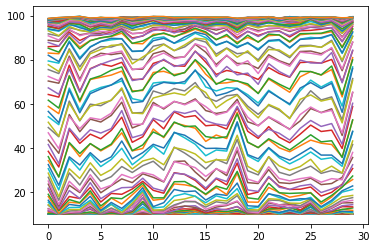

In [24]:
import matplotlib.pyplot as plt

plt.plot(acc_list)
plt.show()

In [ ]:
acc_list

In [ ]:
model.sc1.conv1.weight

In [ ]:
model.eval()

In [ ]:
len(trainloader)

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for images in tqdm(testloader):
        c1 = images[0][0].to(device)
        c2 = images[1][0].to(device)
        c3 = images[2][0].to(device)
        c4 = images[3][0].to(device)
        c5 = images[4][0].to(device)
        labels = images[0][1].to(device)
        outputs = model(c1,c2,c3,c4,c5)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print(total,correct,end='')

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

In [ ]:
c1.size()[0]

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for images in tqdm(testloader):
        c1 = images[0][0].to(device)
        c2 = images[1][0].to(device)
        c3 = images[2][0].to(device)
        c4 = images[3][0].to(device)
        c5 = images[4][0].to(device)
        labels = images[0][1].to(device)
        outputs = model(c1,c2,c3,c4,c5)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (i, 100 * class_correct[i] / class_total[i]))

In [ ]:
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (i, 100 * class_correct[i] / class_total[i]))

In [ ]:
labels

In [ ]:
output.size()

In [ ]:
c6.size()

In [ ]:
SIZED_VAL_PATH = 'sized_val'

new_path = []

for i in os.listdir('mnist_sized'):
    #print(i)
    temp = []
    for j in range(1,6):
        temp.append(os.path.join(SIZED_VAL_PATH,str(i),'ds'+str(j)))
    new_path.append(temp)

#new_path

In [ ]:
new_path.sort(key=lambda x:int(x[0].split('/')[1]))
new_path

In [ ]:
val_gen_arr = []
for i in tqdm(range(len(new_path))):
    transform = transforms.Compose(
        [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    testMnistDataset = SizedMnistDataset(new_path[i],transform)

    testloader = torch.utils.data.DataLoader(testMnistDataset,
                                              batch_size = batch_size, 
                                              shuffle=False,
                                            num_workers=8,
                                            pin_memory=True)
    val_gen_arr.append(testloader)

In [ ]:
#val_gen_arr

In [ ]:
accuracy = []

for testloader in tqdm(val_gen_arr):
    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for images in testloader:
            c1 = images[0][0].to(device)
            c2 = images[1][0].to(device)
            c3 = images[2][0].to(device)
            c4 = images[3][0].to(device)
            c5 = images[4][0].to(device)
            val_labels = images[0][1].to(device)
            outputs = model(c1,c2,c3,c4,c5)
            _, predicted = torch.max(outputs.data, 1)
            c = (predicted == val_labels).squeeze()
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item()
            for i in range(len(val_labels)):
                val_label = val_labels[i]
                class_correct[val_label] += c[i].item()
                class_total[val_label] += 1

        for i in range(10):
            if class_total[i]==0:
                print('class_total = 0',class_correct,class_total)
            else:
                print('Accuracy of %5s : %2d %%' % (i, 100 * class_correct[i] / class_total[i]))
            #print(total,correct,end='')

    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
    accuracy.append((100 * correct / total))

In [ ]:
for i in range(len(accuracy)):
    print(i,accuracy[i])

In [ ]:
for i in range(len(accuracy)):
    print(accuracy[i],',',end='')

In [ ]:
torch.save(model.state_dict(),'deepscln_jan20.pt')

In [ ]:
import matplotlib.pyplot as plt

plt.plot(accuracy)
plt.show()

In [ ]:
import csv

csvfile = open('test.csv','w',newline="")

csvwriter = csv.writer(csvfile)
for row in [accuracy]:
    csvwriter.writerow(row)
    
csvfile.close()